In [1]:
# Cell 1:imports

import os, random, time, math, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
import torchvision.models as models

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
import umap.umap_ as umap

torch.__version__, models.__version__ if hasattr(models, "__version__") else "tv"


2025-09-12 06:19:41.974546: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757657982.167078      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757657982.219706      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


('2.6.0+cu124', 'tv')

In [2]:
#Cell 2: Device & Paths

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = "/kaggle/input/monkeypox-skin-lesion-dataset/Augmented Images/Augmented Images"
SAVE_DIR = "/kaggle/working"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f"Device: {DEVICE}")


Device: cuda


In [3]:
#Cell 3: Hyperparameters & Seeding

SEED = 42
BATCH_SIZE_SSL = 64           # for MoCo pretraining
BATCH_SIZE_SUP = 64           # for supervised eval/test
EPOCHS_SSL = 2000             # MoCo pretraining epochs
EPOCHS_LINEAR = 2000        # linear eval epochs

FEATURE_DIM = 512             # ResNet-18 penultimate feature size
PROJ_DIM = 128                # projection dim for MoCo
IMG_SIZE = 224
LR_SSL = 3e-4
LR_LINEAR = 3e-4

# MoCo-specific
MOMENTUM = 0.999              # momentum for key encoder
QUEUE_SIZE = 1024             # dictionary size
TEMPERATURE = 0.2             # contrastive temperature

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


In [4]:
#Cell 4: Small Utils

def set_seed(seed=SEED):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_curve(values, title, xlab="Epoch", ylab="Value"):
    plt.figure()
    plt.plot(range(1, len(values)+1), values)
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.grid(True)
    plt.show()


In [5]:
# Cell 5: Transforms

# Two random augmentations for MoCo (query & key)
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return q, k

# MoCo augmentations (SimCLR-style are fine for MoCo too)
ssl_transform = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.2, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    T.RandomGrayscale(p=0.2),
    T.GaussianBlur(kernel_size=3),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])

# Supervised (linear eval/test) transform
SUPERVISED_TRANSFORM = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),
])


In [6]:
# Cell 6: Datasets & 30/70 Split + Loaders

# Full supervised dataset (for splits & labels)
full_dataset_supervised = ImageFolder(root=DATA_DIR, transform=SUPERVISED_TRANSFORM)
CLASS_TO_IDX = full_dataset_supervised.class_to_idx
IDX_TO_CLASS = {v:k for k,v in CLASS_TO_IDX.items()}
NUM_CLASSES = len(CLASS_TO_IDX)
print("Classes:", CLASS_TO_IDX)

# 30% train, 70% test
n_total = len(full_dataset_supervised)
n_train = int(0.3 * n_total)
n_test = n_total - n_train

train_sup, test_sup = random_split(
    full_dataset_supervised, [n_train, n_test],
    generator=torch.Generator().manual_seed(SEED)
)

# SSL dataset: same images but produces (q,k) pairs
ssl_dataset = ImageFolder(root=DATA_DIR, transform=TwoCropsTransform(ssl_transform))
ssl_train_subset = Subset(ssl_dataset, train_sup.indices)

# DataLoaders
ssl_train_loader = DataLoader(ssl_train_subset, batch_size=BATCH_SIZE_SSL, shuffle=True,
                              num_workers=2, drop_last=True)

train_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_sup,  batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

# For visualizations (t-SNE/UMAP) over train portion
vis_loader = DataLoader(train_sup, batch_size=BATCH_SIZE_SUP, shuffle=False, num_workers=2)

print(f"Total: {n_total} | Train: {len(train_sup)} | Test: {len(test_sup)}")


Classes: {'Monkeypox_augmented': 0, 'Others_augmented': 1}
Total: 3192 | Train: 957 | Test: 2235


In [7]:
# Cell 7: MoCo Definition (ResNet-18 Backbones)

class MoCo(nn.Module):
    """
    Minimal MoCo v1-style implementation:
    - encoder_q: online (query) encoder
    - encoder_k: momentum (key) encoder
    - queue: negative dictionary
    """
    def __init__(self, base_encoder, feature_dim=128, K=1024, m=0.999, T=0.4):
        super().__init__()
        self.K = K
        self.m = m
        self.T = T

        # Build encoders: output = feature_dim
        self.encoder_q = base_encoder(num_classes=feature_dim)
        self.encoder_k = base_encoder(num_classes=feature_dim)

        # Initialize encoder_k to encoder_q, and set to not require grad
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue
        self.register_buffer("queue", torch.randn(feature_dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update key encoder."""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        """Enqueue the current keys and dequeue the oldest ones."""
        batch_size = keys.shape[0]
        ptr = int(self.queue_ptr)
        # For simplicity, require queue size divisible by batch size
        if self.K % batch_size != 0:
            # If not divisible, only fill to the end
            end = min(ptr + batch_size, self.K)
            span = end - ptr
            self.queue[:, ptr:end] = keys[:span].T
            ptr = end % self.K
            self.queue_ptr[0] = ptr
            return

        self.queue[:, ptr:ptr + batch_size] = keys.T
        ptr = (ptr + batch_size) % self.K
        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_k):
        # Compute query features
        q = self.encoder_q(im_q)
        q = nn.functional.normalize(q, dim=1)

        # Compute key features with momentum encoder (no grad)
        with torch.no_grad():
            self._momentum_update_key_encoder()
            k = self.encoder_k(im_k)
            k = nn.functional.normalize(k, dim=1)

        # Positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # Negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # Concatenate and apply temperature
        logits = torch.cat([l_pos, l_neg], dim=1)
        logits /= self.T

        # Labels: positives are the 0-th
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Update dictionary
        self._dequeue_and_enqueue(k)

        return logits, labels

def resnet18_moco(num_classes=128):
    """ResNet-18 backbone with final fc replaced by projection to num_classes."""
    model = models.resnet18(weights=None)
    dim_mlp = model.fc.in_features
    model.fc = nn.Linear(dim_mlp, num_classes)
    return model


In [8]:
# Cell 8: Train MoCo Pretraining

moco = MoCo(base_encoder=resnet18_moco, feature_dim=PROJ_DIM,
            K=QUEUE_SIZE, m=MOMENTUM, T=TEMPERATURE).to(DEVICE)

opt_moco = torch.optim.Adam(moco.parameters(), lr=LR_SSL)
moco_loss_history = []

print("Starting MoCo pretraining...")
for epoch in range(1, EPOCHS_SSL + 1):
    moco.train()
    running = 0.0
    for (im_q, im_k), _ in tqdm(ssl_train_loader, desc=f"MoCo Epoch {epoch}/{EPOCHS_SSL}"):
        im_q, im_k = im_q.to(DEVICE), im_k.to(DEVICE)
        logits, labels = moco(im_q, im_k)
        loss = F.cross_entropy(logits, labels)

        opt_moco.zero_grad()
        loss.backward()
        opt_moco.step()

        running += loss.item() * im_q.size(0)

    epoch_loss = running / len(ssl_train_loader.dataset)
    moco_loss_history.append(epoch_loss)
    print(f"MoCo Epoch {epoch}: loss={epoch_loss:.4f}")

# Save the query encoder (backbone+proj) – we will load as backbone and strip fc
torch.save(moco.encoder_q.state_dict(), os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))
print("Saved MoCo encoder to:", os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"))


Starting MoCo pretraining...


MoCo Epoch 1/2000: 100%|██████████| 14/14 [00:12<00:00,  1.13it/s]


MoCo Epoch 1: loss=5.1833


MoCo Epoch 2/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 2: loss=6.1721


MoCo Epoch 3/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 3: loss=6.1098


MoCo Epoch 4/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 4: loss=6.1091


MoCo Epoch 5/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 5: loss=6.0411


MoCo Epoch 6/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 6: loss=6.0025


MoCo Epoch 7/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 7: loss=5.9666


MoCo Epoch 8/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 8: loss=5.9507


MoCo Epoch 9/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 9: loss=5.9072


MoCo Epoch 10/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 10: loss=5.8574


MoCo Epoch 11/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 11: loss=5.8246


MoCo Epoch 12/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 12: loss=5.8433


MoCo Epoch 13/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 13: loss=5.8057


MoCo Epoch 14/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 14: loss=5.7725


MoCo Epoch 15/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 15: loss=5.7367


MoCo Epoch 16/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 16: loss=5.7608


MoCo Epoch 17/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 17: loss=5.7689


MoCo Epoch 18/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 18: loss=5.6611


MoCo Epoch 19/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 19: loss=5.6454


MoCo Epoch 20/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 20: loss=5.6495


MoCo Epoch 21/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 21: loss=5.6186


MoCo Epoch 22/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 22: loss=5.6307


MoCo Epoch 23/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 23: loss=5.5943


MoCo Epoch 24/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 24: loss=5.5923


MoCo Epoch 25/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 25: loss=5.5968


MoCo Epoch 26/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 26: loss=5.6025


MoCo Epoch 27/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 27: loss=5.5338


MoCo Epoch 28/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 28: loss=5.5751


MoCo Epoch 29/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 29: loss=5.5030


MoCo Epoch 30/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 30: loss=5.5476


MoCo Epoch 31/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 31: loss=5.4813


MoCo Epoch 32/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 32: loss=5.4573


MoCo Epoch 33/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 33: loss=5.4846


MoCo Epoch 34/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 34: loss=5.4869


MoCo Epoch 35/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 35: loss=5.4304


MoCo Epoch 36/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 36: loss=5.4789


MoCo Epoch 37/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 37: loss=5.4370


MoCo Epoch 38/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 38: loss=5.4241


MoCo Epoch 39/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 39: loss=5.3948


MoCo Epoch 40/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 40: loss=5.4186


MoCo Epoch 41/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 41: loss=5.3467


MoCo Epoch 42/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 42: loss=5.3638


MoCo Epoch 43/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 43: loss=5.3050


MoCo Epoch 44/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 44: loss=5.3165


MoCo Epoch 45/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 45: loss=5.2996


MoCo Epoch 46/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 46: loss=5.2952


MoCo Epoch 47/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 47: loss=5.3238


MoCo Epoch 48/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 48: loss=5.2907


MoCo Epoch 49/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 49: loss=5.2337


MoCo Epoch 50/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 50: loss=5.2082


MoCo Epoch 51/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 51: loss=5.2331


MoCo Epoch 52/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 52: loss=5.2346


MoCo Epoch 53/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 53: loss=5.1925


MoCo Epoch 54/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 54: loss=5.2089


MoCo Epoch 55/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 55: loss=5.1625


MoCo Epoch 56/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 56: loss=5.2535


MoCo Epoch 57/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 57: loss=5.1304


MoCo Epoch 58/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 58: loss=5.2127


MoCo Epoch 59/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 59: loss=5.1621


MoCo Epoch 60/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 60: loss=5.1961


MoCo Epoch 61/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 61: loss=5.1255


MoCo Epoch 62/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 62: loss=5.1198


MoCo Epoch 63/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 63: loss=5.1129


MoCo Epoch 64/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 64: loss=5.1666


MoCo Epoch 65/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 65: loss=5.0881


MoCo Epoch 66/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 66: loss=5.1289


MoCo Epoch 67/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 67: loss=5.0810


MoCo Epoch 68/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 68: loss=5.0695


MoCo Epoch 69/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 69: loss=5.0726


MoCo Epoch 70/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 70: loss=5.0457


MoCo Epoch 71/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 71: loss=5.0587


MoCo Epoch 72/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 72: loss=5.0662


MoCo Epoch 73/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 73: loss=5.0304


MoCo Epoch 74/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 74: loss=4.9792


MoCo Epoch 75/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 75: loss=5.0135


MoCo Epoch 76/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 76: loss=4.9986


MoCo Epoch 77/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 77: loss=5.0041


MoCo Epoch 78/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 78: loss=4.9785


MoCo Epoch 79/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 79: loss=4.9863


MoCo Epoch 80/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 80: loss=4.9812


MoCo Epoch 81/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 81: loss=4.9522


MoCo Epoch 82/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 82: loss=4.8663


MoCo Epoch 83/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 83: loss=4.9599


MoCo Epoch 84/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 84: loss=4.9164


MoCo Epoch 85/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 85: loss=4.9088


MoCo Epoch 86/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 86: loss=4.9217


MoCo Epoch 87/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 87: loss=4.9327


MoCo Epoch 88/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 88: loss=4.8731


MoCo Epoch 89/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 89: loss=4.8879


MoCo Epoch 90/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 90: loss=4.9063


MoCo Epoch 91/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 91: loss=4.9051


MoCo Epoch 92/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 92: loss=4.8471


MoCo Epoch 93/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 93: loss=4.8337


MoCo Epoch 94/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 94: loss=4.8161


MoCo Epoch 95/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 95: loss=4.8149


MoCo Epoch 96/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 96: loss=4.8036


MoCo Epoch 97/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 97: loss=4.8443


MoCo Epoch 98/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 98: loss=4.7583


MoCo Epoch 99/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 99: loss=4.8031


MoCo Epoch 100/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 100: loss=4.7624


MoCo Epoch 101/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 101: loss=4.8248


MoCo Epoch 102/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 102: loss=4.8038


MoCo Epoch 103/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 103: loss=4.8059


MoCo Epoch 104/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 104: loss=4.7335


MoCo Epoch 105/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 105: loss=4.7341


MoCo Epoch 106/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 106: loss=4.7369


MoCo Epoch 107/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 107: loss=4.6786


MoCo Epoch 108/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 108: loss=4.7442


MoCo Epoch 109/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 109: loss=4.6943


MoCo Epoch 110/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 110: loss=4.7144


MoCo Epoch 111/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 111: loss=4.7122


MoCo Epoch 112/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 112: loss=4.7824


MoCo Epoch 113/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 113: loss=4.6949


MoCo Epoch 114/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 114: loss=4.7515


MoCo Epoch 115/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 115: loss=4.7528


MoCo Epoch 116/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 116: loss=4.6770


MoCo Epoch 117/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 117: loss=4.6434


MoCo Epoch 118/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 118: loss=4.6582


MoCo Epoch 119/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 119: loss=4.6618


MoCo Epoch 120/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 120: loss=4.6589


MoCo Epoch 121/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 121: loss=4.6242


MoCo Epoch 122/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 122: loss=4.6498


MoCo Epoch 123/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 123: loss=4.6515


MoCo Epoch 124/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 124: loss=4.6086


MoCo Epoch 125/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 125: loss=4.6463


MoCo Epoch 126/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 126: loss=4.5668


MoCo Epoch 127/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 127: loss=4.6147


MoCo Epoch 128/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 128: loss=4.5737


MoCo Epoch 129/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 129: loss=4.6007


MoCo Epoch 130/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 130: loss=4.6272


MoCo Epoch 131/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 131: loss=4.5765


MoCo Epoch 132/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 132: loss=4.5866


MoCo Epoch 133/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 133: loss=4.5817


MoCo Epoch 134/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 134: loss=4.5751


MoCo Epoch 135/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 135: loss=4.6000


MoCo Epoch 136/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 136: loss=4.5708


MoCo Epoch 137/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 137: loss=4.5709


MoCo Epoch 138/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 138: loss=4.5943


MoCo Epoch 139/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 139: loss=4.5601


MoCo Epoch 140/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 140: loss=4.5687


MoCo Epoch 141/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 141: loss=4.5198


MoCo Epoch 142/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 142: loss=4.4935


MoCo Epoch 143/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 143: loss=4.5488


MoCo Epoch 144/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 144: loss=4.5244


MoCo Epoch 145/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 145: loss=4.5233


MoCo Epoch 146/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 146: loss=4.5004


MoCo Epoch 147/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 147: loss=4.5074


MoCo Epoch 148/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 148: loss=4.4806


MoCo Epoch 149/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 149: loss=4.4636


MoCo Epoch 150/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 150: loss=4.4564


MoCo Epoch 151/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 151: loss=4.5253


MoCo Epoch 152/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 152: loss=4.4703


MoCo Epoch 153/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 153: loss=4.4158


MoCo Epoch 154/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 154: loss=4.4653


MoCo Epoch 155/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 155: loss=4.4097


MoCo Epoch 156/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 156: loss=4.4389


MoCo Epoch 157/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 157: loss=4.4447


MoCo Epoch 158/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 158: loss=4.4846


MoCo Epoch 159/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 159: loss=4.4344


MoCo Epoch 160/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 160: loss=4.4232


MoCo Epoch 161/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 161: loss=4.4137


MoCo Epoch 162/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 162: loss=4.4056


MoCo Epoch 163/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 163: loss=4.3935


MoCo Epoch 164/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 164: loss=4.4103


MoCo Epoch 165/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 165: loss=4.4532


MoCo Epoch 166/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 166: loss=4.4108


MoCo Epoch 167/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 167: loss=4.4069


MoCo Epoch 168/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 168: loss=4.3963


MoCo Epoch 169/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 169: loss=4.4272


MoCo Epoch 170/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 170: loss=4.3855


MoCo Epoch 171/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 171: loss=4.3717


MoCo Epoch 172/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 172: loss=4.3990


MoCo Epoch 173/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 173: loss=4.4171


MoCo Epoch 174/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 174: loss=4.3884


MoCo Epoch 175/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 175: loss=4.3407


MoCo Epoch 176/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 176: loss=4.3753


MoCo Epoch 177/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 177: loss=4.3691


MoCo Epoch 178/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 178: loss=4.3195


MoCo Epoch 179/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 179: loss=4.3615


MoCo Epoch 180/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 180: loss=4.3567


MoCo Epoch 181/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 181: loss=4.3519


MoCo Epoch 182/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 182: loss=4.3675


MoCo Epoch 183/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 183: loss=4.3238


MoCo Epoch 184/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 184: loss=4.3118


MoCo Epoch 185/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 185: loss=4.3449


MoCo Epoch 186/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 186: loss=4.3218


MoCo Epoch 187/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 187: loss=4.2946


MoCo Epoch 188/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 188: loss=4.3243


MoCo Epoch 189/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 189: loss=4.2825


MoCo Epoch 190/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 190: loss=4.2437


MoCo Epoch 191/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 191: loss=4.2800


MoCo Epoch 192/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 192: loss=4.2712


MoCo Epoch 193/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 193: loss=4.2654


MoCo Epoch 194/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 194: loss=4.3124


MoCo Epoch 195/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 195: loss=4.2639


MoCo Epoch 196/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 196: loss=4.2901


MoCo Epoch 197/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 197: loss=4.2591


MoCo Epoch 198/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 198: loss=4.2027


MoCo Epoch 199/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 199: loss=4.2908


MoCo Epoch 200/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 200: loss=4.2358


MoCo Epoch 201/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 201: loss=4.2662


MoCo Epoch 202/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 202: loss=4.2117


MoCo Epoch 203/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 203: loss=4.2372


MoCo Epoch 204/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 204: loss=4.2203


MoCo Epoch 205/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 205: loss=4.2185


MoCo Epoch 206/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 206: loss=4.2867


MoCo Epoch 207/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 207: loss=4.2823


MoCo Epoch 208/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 208: loss=4.2244


MoCo Epoch 209/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 209: loss=4.1840


MoCo Epoch 210/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 210: loss=4.1647


MoCo Epoch 211/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 211: loss=4.1589


MoCo Epoch 212/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 212: loss=4.2138


MoCo Epoch 213/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 213: loss=4.2052


MoCo Epoch 214/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 214: loss=4.1811


MoCo Epoch 215/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 215: loss=4.2025


MoCo Epoch 216/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 216: loss=4.1996


MoCo Epoch 217/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 217: loss=4.1584


MoCo Epoch 218/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 218: loss=4.1960


MoCo Epoch 219/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 219: loss=4.1693


MoCo Epoch 220/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 220: loss=4.1509


MoCo Epoch 221/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 221: loss=4.1576


MoCo Epoch 222/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 222: loss=4.1643


MoCo Epoch 223/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 223: loss=4.1880


MoCo Epoch 224/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 224: loss=4.1610


MoCo Epoch 225/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 225: loss=4.1290


MoCo Epoch 226/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 226: loss=4.1400


MoCo Epoch 227/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 227: loss=4.0865


MoCo Epoch 228/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 228: loss=4.1703


MoCo Epoch 229/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 229: loss=4.1109


MoCo Epoch 230/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 230: loss=4.0958


MoCo Epoch 231/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 231: loss=4.1215


MoCo Epoch 232/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 232: loss=4.1180


MoCo Epoch 233/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 233: loss=4.0999


MoCo Epoch 234/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 234: loss=4.0728


MoCo Epoch 235/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 235: loss=4.1166


MoCo Epoch 236/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 236: loss=4.1377


MoCo Epoch 237/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 237: loss=4.1323


MoCo Epoch 238/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 238: loss=4.1096


MoCo Epoch 239/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 239: loss=4.0814


MoCo Epoch 240/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 240: loss=4.0539


MoCo Epoch 241/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 241: loss=4.1164


MoCo Epoch 242/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 242: loss=4.0886


MoCo Epoch 243/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 243: loss=4.0969


MoCo Epoch 244/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 244: loss=4.0860


MoCo Epoch 245/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 245: loss=4.0570


MoCo Epoch 246/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 246: loss=4.0590


MoCo Epoch 247/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 247: loss=4.0657


MoCo Epoch 248/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 248: loss=4.0318


MoCo Epoch 249/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 249: loss=4.0189


MoCo Epoch 250/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 250: loss=4.0675


MoCo Epoch 251/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 251: loss=4.0923


MoCo Epoch 252/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 252: loss=4.0362


MoCo Epoch 253/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 253: loss=4.0049


MoCo Epoch 254/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 254: loss=4.0160


MoCo Epoch 255/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 255: loss=4.0760


MoCo Epoch 256/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 256: loss=4.0234


MoCo Epoch 257/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 257: loss=4.0101


MoCo Epoch 258/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 258: loss=3.9689


MoCo Epoch 259/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 259: loss=4.0308


MoCo Epoch 260/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 260: loss=4.0080


MoCo Epoch 261/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 261: loss=4.0391


MoCo Epoch 262/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 262: loss=3.9883


MoCo Epoch 263/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 263: loss=3.9935


MoCo Epoch 264/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 264: loss=3.9982


MoCo Epoch 265/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 265: loss=3.9307


MoCo Epoch 266/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 266: loss=3.9916


MoCo Epoch 267/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 267: loss=3.9873


MoCo Epoch 268/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 268: loss=3.9739


MoCo Epoch 269/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 269: loss=3.9688


MoCo Epoch 270/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 270: loss=3.9439


MoCo Epoch 271/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 271: loss=3.9466


MoCo Epoch 272/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 272: loss=4.0035


MoCo Epoch 273/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 273: loss=3.9698


MoCo Epoch 274/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 274: loss=3.9461


MoCo Epoch 275/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 275: loss=3.9281


MoCo Epoch 276/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 276: loss=3.9282


MoCo Epoch 277/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 277: loss=3.9525


MoCo Epoch 278/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 278: loss=3.9099


MoCo Epoch 279/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 279: loss=3.9304


MoCo Epoch 280/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 280: loss=3.9125


MoCo Epoch 281/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 281: loss=3.9239


MoCo Epoch 282/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 282: loss=3.9416


MoCo Epoch 283/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 283: loss=3.9275


MoCo Epoch 284/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 284: loss=3.9525


MoCo Epoch 285/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 285: loss=3.8781


MoCo Epoch 286/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 286: loss=3.8970


MoCo Epoch 287/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 287: loss=3.9139


MoCo Epoch 288/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 288: loss=3.9043


MoCo Epoch 289/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 289: loss=3.8865


MoCo Epoch 290/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 290: loss=3.8961


MoCo Epoch 291/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 291: loss=3.8878


MoCo Epoch 292/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 292: loss=3.8937


MoCo Epoch 293/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 293: loss=3.9180


MoCo Epoch 294/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 294: loss=3.9041


MoCo Epoch 295/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 295: loss=3.8599


MoCo Epoch 296/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 296: loss=3.8866


MoCo Epoch 297/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 297: loss=3.8688


MoCo Epoch 298/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 298: loss=3.9008


MoCo Epoch 299/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 299: loss=3.8743


MoCo Epoch 300/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 300: loss=3.8696


MoCo Epoch 301/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 301: loss=3.8841


MoCo Epoch 302/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 302: loss=3.8396


MoCo Epoch 303/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 303: loss=3.8493


MoCo Epoch 304/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 304: loss=3.8160


MoCo Epoch 305/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 305: loss=3.8490


MoCo Epoch 306/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 306: loss=3.8597


MoCo Epoch 307/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 307: loss=3.8236


MoCo Epoch 308/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 308: loss=3.8186


MoCo Epoch 309/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 309: loss=3.8489


MoCo Epoch 310/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 310: loss=3.8820


MoCo Epoch 311/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 311: loss=3.8484


MoCo Epoch 312/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 312: loss=3.8694


MoCo Epoch 313/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 313: loss=3.8616


MoCo Epoch 314/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 314: loss=3.8284


MoCo Epoch 315/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 315: loss=3.8110


MoCo Epoch 316/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 316: loss=3.7870


MoCo Epoch 317/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 317: loss=3.7995


MoCo Epoch 318/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 318: loss=3.8020


MoCo Epoch 319/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 319: loss=3.7954


MoCo Epoch 320/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 320: loss=3.7974


MoCo Epoch 321/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 321: loss=3.7947


MoCo Epoch 322/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 322: loss=3.8103


MoCo Epoch 323/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 323: loss=3.7495


MoCo Epoch 324/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 324: loss=3.8244


MoCo Epoch 325/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 325: loss=3.7919


MoCo Epoch 326/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 326: loss=3.7713


MoCo Epoch 327/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 327: loss=3.7832


MoCo Epoch 328/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 328: loss=3.7754


MoCo Epoch 329/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 329: loss=3.7849


MoCo Epoch 330/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 330: loss=3.7990


MoCo Epoch 331/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 331: loss=3.8148


MoCo Epoch 332/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 332: loss=3.7120


MoCo Epoch 333/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 333: loss=3.7837


MoCo Epoch 334/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 334: loss=3.7819


MoCo Epoch 335/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 335: loss=3.7717


MoCo Epoch 336/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 336: loss=3.7581


MoCo Epoch 337/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 337: loss=3.7722


MoCo Epoch 338/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 338: loss=3.7641


MoCo Epoch 339/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 339: loss=3.7284


MoCo Epoch 340/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 340: loss=3.7433


MoCo Epoch 341/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 341: loss=3.7376


MoCo Epoch 342/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 342: loss=3.7621


MoCo Epoch 343/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 343: loss=3.7518


MoCo Epoch 344/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 344: loss=3.7296


MoCo Epoch 345/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 345: loss=3.7557


MoCo Epoch 346/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 346: loss=3.7125


MoCo Epoch 347/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 347: loss=3.7004


MoCo Epoch 348/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 348: loss=3.7352


MoCo Epoch 349/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 349: loss=3.6884


MoCo Epoch 350/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 350: loss=3.7151


MoCo Epoch 351/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 351: loss=3.7109


MoCo Epoch 352/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 352: loss=3.7155


MoCo Epoch 353/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 353: loss=3.7254


MoCo Epoch 354/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 354: loss=3.7022


MoCo Epoch 355/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 355: loss=3.7298


MoCo Epoch 356/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 356: loss=3.7271


MoCo Epoch 357/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 357: loss=3.6653


MoCo Epoch 358/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 358: loss=3.6576


MoCo Epoch 359/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 359: loss=3.6794


MoCo Epoch 360/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 360: loss=3.7222


MoCo Epoch 361/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 361: loss=3.6887


MoCo Epoch 362/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 362: loss=3.7007


MoCo Epoch 363/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 363: loss=3.6551


MoCo Epoch 364/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 364: loss=3.7103


MoCo Epoch 365/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 365: loss=3.6848


MoCo Epoch 366/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 366: loss=3.6844


MoCo Epoch 367/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 367: loss=3.6722


MoCo Epoch 368/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 368: loss=3.6614


MoCo Epoch 369/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 369: loss=3.6714


MoCo Epoch 370/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 370: loss=3.6599


MoCo Epoch 371/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 371: loss=3.6529


MoCo Epoch 372/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 372: loss=3.7032


MoCo Epoch 373/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 373: loss=3.6849


MoCo Epoch 374/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 374: loss=3.6496


MoCo Epoch 375/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 375: loss=3.6280


MoCo Epoch 376/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 376: loss=3.6077


MoCo Epoch 377/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 377: loss=3.6419


MoCo Epoch 378/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 378: loss=3.6057


MoCo Epoch 379/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 379: loss=3.6558


MoCo Epoch 380/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 380: loss=3.6442


MoCo Epoch 381/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 381: loss=3.6337


MoCo Epoch 382/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 382: loss=3.6137


MoCo Epoch 383/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 383: loss=3.6203


MoCo Epoch 384/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 384: loss=3.6551


MoCo Epoch 385/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 385: loss=3.6724


MoCo Epoch 386/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 386: loss=3.6064


MoCo Epoch 387/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 387: loss=3.6103


MoCo Epoch 388/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 388: loss=3.6129


MoCo Epoch 389/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 389: loss=3.6467


MoCo Epoch 390/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 390: loss=3.5771


MoCo Epoch 391/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 391: loss=3.6056


MoCo Epoch 392/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 392: loss=3.6350


MoCo Epoch 393/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 393: loss=3.6066


MoCo Epoch 394/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 394: loss=3.6021


MoCo Epoch 395/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 395: loss=3.6094


MoCo Epoch 396/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 396: loss=3.6171


MoCo Epoch 397/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 397: loss=3.6062


MoCo Epoch 398/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 398: loss=3.5720


MoCo Epoch 399/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 399: loss=3.6298


MoCo Epoch 400/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 400: loss=3.6070


MoCo Epoch 401/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 401: loss=3.6248


MoCo Epoch 402/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 402: loss=3.5995


MoCo Epoch 403/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 403: loss=3.6169


MoCo Epoch 404/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 404: loss=3.6268


MoCo Epoch 405/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 405: loss=3.5816


MoCo Epoch 406/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 406: loss=3.5650


MoCo Epoch 407/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 407: loss=3.5460


MoCo Epoch 408/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 408: loss=3.5426


MoCo Epoch 409/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 409: loss=3.5631


MoCo Epoch 410/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 410: loss=3.5515


MoCo Epoch 411/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 411: loss=3.5639


MoCo Epoch 412/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 412: loss=3.5725


MoCo Epoch 413/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 413: loss=3.5667


MoCo Epoch 414/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 414: loss=3.5634


MoCo Epoch 415/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 415: loss=3.5708


MoCo Epoch 416/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 416: loss=3.5849


MoCo Epoch 417/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 417: loss=3.5547


MoCo Epoch 418/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 418: loss=3.5548


MoCo Epoch 419/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 419: loss=3.5680


MoCo Epoch 420/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 420: loss=3.5446


MoCo Epoch 421/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 421: loss=3.5629


MoCo Epoch 422/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 422: loss=3.5485


MoCo Epoch 423/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 423: loss=3.5311


MoCo Epoch 424/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 424: loss=3.5760


MoCo Epoch 425/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 425: loss=3.5441


MoCo Epoch 426/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 426: loss=3.5428


MoCo Epoch 427/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 427: loss=3.5276


MoCo Epoch 428/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 428: loss=3.5471


MoCo Epoch 429/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 429: loss=3.5394


MoCo Epoch 430/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 430: loss=3.5621


MoCo Epoch 431/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 431: loss=3.5391


MoCo Epoch 432/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 432: loss=3.5228


MoCo Epoch 433/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 433: loss=3.5336


MoCo Epoch 434/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 434: loss=3.5089


MoCo Epoch 435/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 435: loss=3.5204


MoCo Epoch 436/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 436: loss=3.5419


MoCo Epoch 437/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 437: loss=3.5178


MoCo Epoch 438/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 438: loss=3.5488


MoCo Epoch 439/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 439: loss=3.5326


MoCo Epoch 440/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 440: loss=3.4912


MoCo Epoch 441/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 441: loss=3.4975


MoCo Epoch 442/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 442: loss=3.5114


MoCo Epoch 443/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 443: loss=3.5238


MoCo Epoch 444/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 444: loss=3.5000


MoCo Epoch 445/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 445: loss=3.5255


MoCo Epoch 446/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 446: loss=3.5121


MoCo Epoch 447/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 447: loss=3.4897


MoCo Epoch 448/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 448: loss=3.4796


MoCo Epoch 449/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 449: loss=3.4881


MoCo Epoch 450/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 450: loss=3.5122


MoCo Epoch 451/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 451: loss=3.5205


MoCo Epoch 452/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 452: loss=3.4976


MoCo Epoch 453/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 453: loss=3.4928


MoCo Epoch 454/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 454: loss=3.4873


MoCo Epoch 455/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 455: loss=3.4925


MoCo Epoch 456/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 456: loss=3.4983


MoCo Epoch 457/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 457: loss=3.5095


MoCo Epoch 458/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 458: loss=3.4824


MoCo Epoch 459/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 459: loss=3.4702


MoCo Epoch 460/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 460: loss=3.4460


MoCo Epoch 461/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 461: loss=3.4722


MoCo Epoch 462/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 462: loss=3.4593


MoCo Epoch 463/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 463: loss=3.4848


MoCo Epoch 464/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 464: loss=3.4674


MoCo Epoch 465/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 465: loss=3.4693


MoCo Epoch 466/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 466: loss=3.4434


MoCo Epoch 467/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 467: loss=3.4810


MoCo Epoch 468/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 468: loss=3.4798


MoCo Epoch 469/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 469: loss=3.4603


MoCo Epoch 470/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 470: loss=3.4632


MoCo Epoch 471/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 471: loss=3.4289


MoCo Epoch 472/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 472: loss=3.4857


MoCo Epoch 473/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 473: loss=3.4629


MoCo Epoch 474/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 474: loss=3.4947


MoCo Epoch 475/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 475: loss=3.4160


MoCo Epoch 476/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 476: loss=3.4498


MoCo Epoch 477/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 477: loss=3.4189


MoCo Epoch 478/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 478: loss=3.4487


MoCo Epoch 479/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 479: loss=3.4101


MoCo Epoch 480/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 480: loss=3.4166


MoCo Epoch 481/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 481: loss=3.4236


MoCo Epoch 482/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 482: loss=3.4286


MoCo Epoch 483/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 483: loss=3.4075


MoCo Epoch 484/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 484: loss=3.4205


MoCo Epoch 485/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 485: loss=3.4284


MoCo Epoch 486/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 486: loss=3.4064


MoCo Epoch 487/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 487: loss=3.4463


MoCo Epoch 488/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 488: loss=3.4558


MoCo Epoch 489/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 489: loss=3.4081


MoCo Epoch 490/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 490: loss=3.4118


MoCo Epoch 491/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 491: loss=3.4085


MoCo Epoch 492/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 492: loss=3.4149


MoCo Epoch 493/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 493: loss=3.4293


MoCo Epoch 494/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 494: loss=3.4255


MoCo Epoch 495/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 495: loss=3.4173


MoCo Epoch 496/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 496: loss=3.4123


MoCo Epoch 497/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 497: loss=3.4116


MoCo Epoch 498/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 498: loss=3.3858


MoCo Epoch 499/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 499: loss=3.4044


MoCo Epoch 500/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 500: loss=3.4159


MoCo Epoch 501/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 501: loss=3.4133


MoCo Epoch 502/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 502: loss=3.3732


MoCo Epoch 503/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 503: loss=3.3980


MoCo Epoch 504/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 504: loss=3.4077


MoCo Epoch 505/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 505: loss=3.4088


MoCo Epoch 506/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 506: loss=3.4090


MoCo Epoch 507/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 507: loss=3.3909


MoCo Epoch 508/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 508: loss=3.4089


MoCo Epoch 509/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 509: loss=3.3850


MoCo Epoch 510/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 510: loss=3.3861


MoCo Epoch 511/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 511: loss=3.4007


MoCo Epoch 512/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 512: loss=3.4078


MoCo Epoch 513/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 513: loss=3.3993


MoCo Epoch 514/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 514: loss=3.3712


MoCo Epoch 515/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 515: loss=3.3802


MoCo Epoch 516/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 516: loss=3.3741


MoCo Epoch 517/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 517: loss=3.3664


MoCo Epoch 518/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 518: loss=3.3645


MoCo Epoch 519/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 519: loss=3.4195


MoCo Epoch 520/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 520: loss=3.3601


MoCo Epoch 521/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 521: loss=3.3656


MoCo Epoch 522/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 522: loss=3.3524


MoCo Epoch 523/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 523: loss=3.3867


MoCo Epoch 524/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 524: loss=3.3976


MoCo Epoch 525/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 525: loss=3.3779


MoCo Epoch 526/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 526: loss=3.3588


MoCo Epoch 527/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 527: loss=3.3652


MoCo Epoch 528/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 528: loss=3.3562


MoCo Epoch 529/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 529: loss=3.3827


MoCo Epoch 530/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 530: loss=3.3574


MoCo Epoch 531/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 531: loss=3.3592


MoCo Epoch 532/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 532: loss=3.3482


MoCo Epoch 533/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 533: loss=3.3381


MoCo Epoch 534/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 534: loss=3.3457


MoCo Epoch 535/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 535: loss=3.3419


MoCo Epoch 536/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 536: loss=3.3456


MoCo Epoch 537/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 537: loss=3.3376


MoCo Epoch 538/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 538: loss=3.3659


MoCo Epoch 539/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 539: loss=3.3653


MoCo Epoch 540/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 540: loss=3.3441


MoCo Epoch 541/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 541: loss=3.3464


MoCo Epoch 542/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 542: loss=3.3533


MoCo Epoch 543/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 543: loss=3.3407


MoCo Epoch 544/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 544: loss=3.3251


MoCo Epoch 545/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 545: loss=3.3364


MoCo Epoch 546/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 546: loss=3.3142


MoCo Epoch 547/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 547: loss=3.3184


MoCo Epoch 548/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 548: loss=3.3490


MoCo Epoch 549/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 549: loss=3.3202


MoCo Epoch 550/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 550: loss=3.3177


MoCo Epoch 551/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 551: loss=3.3274


MoCo Epoch 552/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 552: loss=3.3602


MoCo Epoch 553/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 553: loss=3.3137


MoCo Epoch 554/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 554: loss=3.3247


MoCo Epoch 555/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 555: loss=3.3166


MoCo Epoch 556/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 556: loss=3.3228


MoCo Epoch 557/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 557: loss=3.3260


MoCo Epoch 558/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 558: loss=3.3307


MoCo Epoch 559/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 559: loss=3.3041


MoCo Epoch 560/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 560: loss=3.3090


MoCo Epoch 561/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 561: loss=3.2948


MoCo Epoch 562/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 562: loss=3.3012


MoCo Epoch 563/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 563: loss=3.3137


MoCo Epoch 564/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 564: loss=3.3141


MoCo Epoch 565/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 565: loss=3.3203


MoCo Epoch 566/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 566: loss=3.2930


MoCo Epoch 567/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 567: loss=3.2966


MoCo Epoch 568/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 568: loss=3.2867


MoCo Epoch 569/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 569: loss=3.2988


MoCo Epoch 570/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 570: loss=3.2795


MoCo Epoch 571/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 571: loss=3.2742


MoCo Epoch 572/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 572: loss=3.2991


MoCo Epoch 573/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 573: loss=3.2930


MoCo Epoch 574/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 574: loss=3.3031


MoCo Epoch 575/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 575: loss=3.2941


MoCo Epoch 576/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 576: loss=3.2933


MoCo Epoch 577/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 577: loss=3.2832


MoCo Epoch 578/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 578: loss=3.3000


MoCo Epoch 579/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 579: loss=3.2747


MoCo Epoch 580/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 580: loss=3.2761


MoCo Epoch 581/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 581: loss=3.2730


MoCo Epoch 582/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 582: loss=3.2870


MoCo Epoch 583/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 583: loss=3.2644


MoCo Epoch 584/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 584: loss=3.2907


MoCo Epoch 585/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 585: loss=3.2901


MoCo Epoch 586/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 586: loss=3.3100


MoCo Epoch 587/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 587: loss=3.2602


MoCo Epoch 588/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 588: loss=3.2830


MoCo Epoch 589/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 589: loss=3.2812


MoCo Epoch 590/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 590: loss=3.2786


MoCo Epoch 591/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 591: loss=3.2545


MoCo Epoch 592/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 592: loss=3.2873


MoCo Epoch 593/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 593: loss=3.2802


MoCo Epoch 594/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 594: loss=3.2902


MoCo Epoch 595/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 595: loss=3.2458


MoCo Epoch 596/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 596: loss=3.2864


MoCo Epoch 597/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 597: loss=3.2444


MoCo Epoch 598/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 598: loss=3.2698


MoCo Epoch 599/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 599: loss=3.2821


MoCo Epoch 600/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 600: loss=3.2573


MoCo Epoch 601/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 601: loss=3.2561


MoCo Epoch 602/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 602: loss=3.2499


MoCo Epoch 603/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 603: loss=3.2513


MoCo Epoch 604/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 604: loss=3.2583


MoCo Epoch 605/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 605: loss=3.2475


MoCo Epoch 606/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 606: loss=3.2546


MoCo Epoch 607/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 607: loss=3.2629


MoCo Epoch 608/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 608: loss=3.2493


MoCo Epoch 609/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 609: loss=3.2383


MoCo Epoch 610/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 610: loss=3.2429


MoCo Epoch 611/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 611: loss=3.2485


MoCo Epoch 612/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 612: loss=3.2211


MoCo Epoch 613/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 613: loss=3.2482


MoCo Epoch 614/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 614: loss=3.2568


MoCo Epoch 615/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 615: loss=3.2576


MoCo Epoch 616/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 616: loss=3.2702


MoCo Epoch 617/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 617: loss=3.2384


MoCo Epoch 618/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 618: loss=3.2559


MoCo Epoch 619/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 619: loss=3.2363


MoCo Epoch 620/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 620: loss=3.2504


MoCo Epoch 621/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 621: loss=3.2419


MoCo Epoch 622/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 622: loss=3.2062


MoCo Epoch 623/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 623: loss=3.2024


MoCo Epoch 624/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 624: loss=3.2315


MoCo Epoch 625/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 625: loss=3.2239


MoCo Epoch 626/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 626: loss=3.2427


MoCo Epoch 627/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 627: loss=3.2427


MoCo Epoch 628/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 628: loss=3.2527


MoCo Epoch 629/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 629: loss=3.2079


MoCo Epoch 630/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 630: loss=3.2150


MoCo Epoch 631/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 631: loss=3.2274


MoCo Epoch 632/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 632: loss=3.2304


MoCo Epoch 633/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 633: loss=3.2383


MoCo Epoch 634/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 634: loss=3.2354


MoCo Epoch 635/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 635: loss=3.2261


MoCo Epoch 636/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 636: loss=3.2011


MoCo Epoch 637/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 637: loss=3.2106


MoCo Epoch 638/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 638: loss=3.2112


MoCo Epoch 639/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 639: loss=3.2326


MoCo Epoch 640/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 640: loss=3.2184


MoCo Epoch 641/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 641: loss=3.2039


MoCo Epoch 642/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 642: loss=3.2322


MoCo Epoch 643/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 643: loss=3.1854


MoCo Epoch 644/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 644: loss=3.1855


MoCo Epoch 645/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 645: loss=3.1741


MoCo Epoch 646/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 646: loss=3.2002


MoCo Epoch 647/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 647: loss=3.1801


MoCo Epoch 648/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 648: loss=3.1700


MoCo Epoch 649/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 649: loss=3.1966


MoCo Epoch 650/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 650: loss=3.2180


MoCo Epoch 651/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 651: loss=3.2051


MoCo Epoch 652/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 652: loss=3.2075


MoCo Epoch 653/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 653: loss=3.2041


MoCo Epoch 654/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 654: loss=3.2087


MoCo Epoch 655/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 655: loss=3.1636


MoCo Epoch 656/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 656: loss=3.2040


MoCo Epoch 657/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 657: loss=3.1756


MoCo Epoch 658/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 658: loss=3.1932


MoCo Epoch 659/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 659: loss=3.1521


MoCo Epoch 660/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 660: loss=3.1804


MoCo Epoch 661/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 661: loss=3.1781


MoCo Epoch 662/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 662: loss=3.1819


MoCo Epoch 663/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 663: loss=3.1976


MoCo Epoch 664/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 664: loss=3.1670


MoCo Epoch 665/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 665: loss=3.2128


MoCo Epoch 666/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 666: loss=3.1896


MoCo Epoch 667/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 667: loss=3.1848


MoCo Epoch 668/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 668: loss=3.1759


MoCo Epoch 669/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 669: loss=3.1862


MoCo Epoch 670/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 670: loss=3.1636


MoCo Epoch 671/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 671: loss=3.1572


MoCo Epoch 672/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 672: loss=3.1885


MoCo Epoch 673/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 673: loss=3.1588


MoCo Epoch 674/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 674: loss=3.1361


MoCo Epoch 675/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 675: loss=3.1594


MoCo Epoch 676/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 676: loss=3.1897


MoCo Epoch 677/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 677: loss=3.1585


MoCo Epoch 678/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 678: loss=3.1403


MoCo Epoch 679/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 679: loss=3.1726


MoCo Epoch 680/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 680: loss=3.1447


MoCo Epoch 681/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 681: loss=3.1614


MoCo Epoch 682/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 682: loss=3.1534


MoCo Epoch 683/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 683: loss=3.1546


MoCo Epoch 684/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 684: loss=3.1698


MoCo Epoch 685/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 685: loss=3.1626


MoCo Epoch 686/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 686: loss=3.1619


MoCo Epoch 687/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 687: loss=3.1403


MoCo Epoch 688/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 688: loss=3.1718


MoCo Epoch 689/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 689: loss=3.1389


MoCo Epoch 690/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 690: loss=3.1448


MoCo Epoch 691/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 691: loss=3.1657


MoCo Epoch 692/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 692: loss=3.1210


MoCo Epoch 693/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 693: loss=3.1365


MoCo Epoch 694/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 694: loss=3.1493


MoCo Epoch 695/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 695: loss=3.1349


MoCo Epoch 696/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 696: loss=3.1793


MoCo Epoch 697/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 697: loss=3.1271


MoCo Epoch 698/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 698: loss=3.1631


MoCo Epoch 699/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 699: loss=3.1448


MoCo Epoch 700/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 700: loss=3.1472


MoCo Epoch 701/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 701: loss=3.1709


MoCo Epoch 702/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 702: loss=3.1221


MoCo Epoch 703/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 703: loss=3.1527


MoCo Epoch 704/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 704: loss=3.1200


MoCo Epoch 705/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 705: loss=3.1009


MoCo Epoch 706/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 706: loss=3.1457


MoCo Epoch 707/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 707: loss=3.1145


MoCo Epoch 708/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 708: loss=3.1313


MoCo Epoch 709/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 709: loss=3.1455


MoCo Epoch 710/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 710: loss=3.1482


MoCo Epoch 711/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 711: loss=3.1421


MoCo Epoch 712/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 712: loss=3.1397


MoCo Epoch 713/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 713: loss=3.1222


MoCo Epoch 714/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 714: loss=3.0986


MoCo Epoch 715/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 715: loss=3.1430


MoCo Epoch 716/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 716: loss=3.1122


MoCo Epoch 717/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 717: loss=3.1273


MoCo Epoch 718/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 718: loss=3.1171


MoCo Epoch 719/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 719: loss=3.1250


MoCo Epoch 720/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 720: loss=3.1095


MoCo Epoch 721/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 721: loss=3.1156


MoCo Epoch 722/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 722: loss=3.0866


MoCo Epoch 723/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 723: loss=3.1080


MoCo Epoch 724/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 724: loss=3.1190


MoCo Epoch 725/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 725: loss=3.1117


MoCo Epoch 726/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 726: loss=3.0918


MoCo Epoch 727/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 727: loss=3.1122


MoCo Epoch 728/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 728: loss=3.1144


MoCo Epoch 729/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 729: loss=3.0904


MoCo Epoch 730/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 730: loss=3.1174


MoCo Epoch 731/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 731: loss=3.1199


MoCo Epoch 732/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 732: loss=3.1110


MoCo Epoch 733/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 733: loss=3.1230


MoCo Epoch 734/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 734: loss=3.1049


MoCo Epoch 735/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 735: loss=3.1149


MoCo Epoch 736/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 736: loss=3.0961


MoCo Epoch 737/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 737: loss=3.1258


MoCo Epoch 738/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 738: loss=3.1012


MoCo Epoch 739/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 739: loss=3.1078


MoCo Epoch 740/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 740: loss=3.0822


MoCo Epoch 741/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 741: loss=3.0907


MoCo Epoch 742/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 742: loss=3.0856


MoCo Epoch 743/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 743: loss=3.0909


MoCo Epoch 744/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 744: loss=3.1123


MoCo Epoch 745/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 745: loss=3.0852


MoCo Epoch 746/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 746: loss=3.0938


MoCo Epoch 747/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 747: loss=3.0730


MoCo Epoch 748/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 748: loss=3.0883


MoCo Epoch 749/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 749: loss=3.0831


MoCo Epoch 750/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 750: loss=3.0830


MoCo Epoch 751/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 751: loss=3.1083


MoCo Epoch 752/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 752: loss=3.0941


MoCo Epoch 753/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 753: loss=3.0814


MoCo Epoch 754/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 754: loss=3.0898


MoCo Epoch 755/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 755: loss=3.0665


MoCo Epoch 756/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 756: loss=3.0893


MoCo Epoch 757/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 757: loss=3.0645


MoCo Epoch 758/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 758: loss=3.0751


MoCo Epoch 759/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 759: loss=3.0707


MoCo Epoch 760/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 760: loss=3.0636


MoCo Epoch 761/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 761: loss=3.0708


MoCo Epoch 762/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 762: loss=3.0642


MoCo Epoch 763/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 763: loss=3.0574


MoCo Epoch 764/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 764: loss=3.0758


MoCo Epoch 765/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 765: loss=3.0658


MoCo Epoch 766/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 766: loss=3.0622


MoCo Epoch 767/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 767: loss=3.0818


MoCo Epoch 768/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 768: loss=3.0706


MoCo Epoch 769/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 769: loss=3.0614


MoCo Epoch 770/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 770: loss=3.0678


MoCo Epoch 771/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 771: loss=3.0478


MoCo Epoch 772/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 772: loss=3.0632


MoCo Epoch 773/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 773: loss=3.0810


MoCo Epoch 774/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 774: loss=3.0749


MoCo Epoch 775/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 775: loss=3.0522


MoCo Epoch 776/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 776: loss=3.0740


MoCo Epoch 777/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 777: loss=3.0689


MoCo Epoch 778/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 778: loss=3.0776


MoCo Epoch 779/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 779: loss=3.0611


MoCo Epoch 780/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 780: loss=3.0658


MoCo Epoch 781/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 781: loss=3.0473


MoCo Epoch 782/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 782: loss=3.0440


MoCo Epoch 783/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 783: loss=3.0723


MoCo Epoch 784/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 784: loss=3.0565


MoCo Epoch 785/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 785: loss=3.0487


MoCo Epoch 786/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 786: loss=3.0657


MoCo Epoch 787/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 787: loss=3.0403


MoCo Epoch 788/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 788: loss=3.0407


MoCo Epoch 789/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 789: loss=3.0662


MoCo Epoch 790/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 790: loss=3.0510


MoCo Epoch 791/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 791: loss=3.0259


MoCo Epoch 792/2000: 100%|██████████| 14/14 [00:09<00:00,  1.45it/s]


MoCo Epoch 792: loss=3.0694


MoCo Epoch 793/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 793: loss=3.0330


MoCo Epoch 794/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 794: loss=3.0334


MoCo Epoch 795/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 795: loss=3.0435


MoCo Epoch 796/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 796: loss=3.0492


MoCo Epoch 797/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 797: loss=3.0601


MoCo Epoch 798/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 798: loss=3.0518


MoCo Epoch 799/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 799: loss=3.0445


MoCo Epoch 800/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 800: loss=3.0314


MoCo Epoch 801/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 801: loss=3.0314


MoCo Epoch 802/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 802: loss=3.0440


MoCo Epoch 803/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 803: loss=3.0512


MoCo Epoch 804/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 804: loss=3.0258


MoCo Epoch 805/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 805: loss=3.0272


MoCo Epoch 806/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 806: loss=3.0267


MoCo Epoch 807/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 807: loss=3.0265


MoCo Epoch 808/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 808: loss=3.0320


MoCo Epoch 809/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 809: loss=3.0206


MoCo Epoch 810/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 810: loss=3.0291


MoCo Epoch 811/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 811: loss=3.0381


MoCo Epoch 812/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 812: loss=3.0073


MoCo Epoch 813/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 813: loss=3.0345


MoCo Epoch 814/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 814: loss=3.0138


MoCo Epoch 815/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 815: loss=3.0427


MoCo Epoch 816/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 816: loss=3.0102


MoCo Epoch 817/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 817: loss=2.9882


MoCo Epoch 818/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 818: loss=3.0161


MoCo Epoch 819/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 819: loss=3.0274


MoCo Epoch 820/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 820: loss=3.0105


MoCo Epoch 821/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 821: loss=3.0248


MoCo Epoch 822/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 822: loss=3.0301


MoCo Epoch 823/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 823: loss=3.0145


MoCo Epoch 824/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 824: loss=3.0223


MoCo Epoch 825/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 825: loss=3.0176


MoCo Epoch 826/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 826: loss=3.0007


MoCo Epoch 827/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 827: loss=3.0060


MoCo Epoch 828/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 828: loss=2.9883


MoCo Epoch 829/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 829: loss=3.0243


MoCo Epoch 830/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 830: loss=3.0337


MoCo Epoch 831/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 831: loss=3.0309


MoCo Epoch 832/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 832: loss=3.0074


MoCo Epoch 833/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 833: loss=3.0242


MoCo Epoch 834/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 834: loss=3.0280


MoCo Epoch 835/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 835: loss=3.0233


MoCo Epoch 836/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 836: loss=2.9894


MoCo Epoch 837/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 837: loss=3.0213


MoCo Epoch 838/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 838: loss=2.9916


MoCo Epoch 839/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 839: loss=2.9752


MoCo Epoch 840/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 840: loss=3.0186


MoCo Epoch 841/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 841: loss=3.0008


MoCo Epoch 842/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 842: loss=2.9844


MoCo Epoch 843/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 843: loss=2.9987


MoCo Epoch 844/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 844: loss=3.0120


MoCo Epoch 845/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 845: loss=2.9812


MoCo Epoch 846/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 846: loss=2.9790


MoCo Epoch 847/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 847: loss=2.9872


MoCo Epoch 848/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 848: loss=3.0068


MoCo Epoch 849/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 849: loss=2.9954


MoCo Epoch 850/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 850: loss=2.9858


MoCo Epoch 851/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 851: loss=3.0080


MoCo Epoch 852/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 852: loss=2.9931


MoCo Epoch 853/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 853: loss=2.9811


MoCo Epoch 854/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 854: loss=2.9940


MoCo Epoch 855/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 855: loss=2.9891


MoCo Epoch 856/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 856: loss=2.9765


MoCo Epoch 857/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 857: loss=2.9978


MoCo Epoch 858/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 858: loss=2.9747


MoCo Epoch 859/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 859: loss=2.9878


MoCo Epoch 860/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 860: loss=2.9875


MoCo Epoch 861/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 861: loss=2.9923


MoCo Epoch 862/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 862: loss=2.9852


MoCo Epoch 863/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 863: loss=2.9917


MoCo Epoch 864/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 864: loss=2.9572


MoCo Epoch 865/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 865: loss=2.9822


MoCo Epoch 866/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 866: loss=2.9706


MoCo Epoch 867/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 867: loss=2.9644


MoCo Epoch 868/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 868: loss=2.9647


MoCo Epoch 869/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 869: loss=2.9798


MoCo Epoch 870/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 870: loss=2.9684


MoCo Epoch 871/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 871: loss=2.9726


MoCo Epoch 872/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 872: loss=2.9544


MoCo Epoch 873/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 873: loss=2.9702


MoCo Epoch 874/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 874: loss=2.9703


MoCo Epoch 875/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 875: loss=2.9725


MoCo Epoch 876/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 876: loss=2.9705


MoCo Epoch 877/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 877: loss=2.9618


MoCo Epoch 878/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 878: loss=2.9589


MoCo Epoch 879/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 879: loss=2.9612


MoCo Epoch 880/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 880: loss=2.9724


MoCo Epoch 881/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 881: loss=2.9573


MoCo Epoch 882/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 882: loss=2.9488


MoCo Epoch 883/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 883: loss=2.9791


MoCo Epoch 884/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 884: loss=2.9837


MoCo Epoch 885/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 885: loss=2.9562


MoCo Epoch 886/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 886: loss=2.9765


MoCo Epoch 887/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 887: loss=2.9552


MoCo Epoch 888/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 888: loss=2.9687


MoCo Epoch 889/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 889: loss=2.9592


MoCo Epoch 890/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 890: loss=2.9366


MoCo Epoch 891/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 891: loss=2.9704


MoCo Epoch 892/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 892: loss=2.9455


MoCo Epoch 893/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 893: loss=2.9601


MoCo Epoch 894/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 894: loss=2.9467


MoCo Epoch 895/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 895: loss=2.9586


MoCo Epoch 896/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 896: loss=2.9605


MoCo Epoch 897/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 897: loss=2.9475


MoCo Epoch 898/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 898: loss=2.9603


MoCo Epoch 899/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 899: loss=2.9568


MoCo Epoch 900/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 900: loss=2.9566


MoCo Epoch 901/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 901: loss=2.9579


MoCo Epoch 902/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 902: loss=2.9721


MoCo Epoch 903/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 903: loss=2.9405


MoCo Epoch 904/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 904: loss=2.9404


MoCo Epoch 905/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 905: loss=2.9400


MoCo Epoch 906/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 906: loss=2.9322


MoCo Epoch 907/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 907: loss=2.9288


MoCo Epoch 908/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 908: loss=2.9383


MoCo Epoch 909/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 909: loss=2.9316


MoCo Epoch 910/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 910: loss=2.9445


MoCo Epoch 911/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 911: loss=2.9489


MoCo Epoch 912/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 912: loss=2.9201


MoCo Epoch 913/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 913: loss=2.9557


MoCo Epoch 914/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 914: loss=2.9355


MoCo Epoch 915/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 915: loss=2.9243


MoCo Epoch 916/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 916: loss=2.9222


MoCo Epoch 917/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 917: loss=2.9269


MoCo Epoch 918/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 918: loss=2.9290


MoCo Epoch 919/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 919: loss=2.9150


MoCo Epoch 920/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 920: loss=2.9159


MoCo Epoch 921/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 921: loss=2.9425


MoCo Epoch 922/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 922: loss=2.9224


MoCo Epoch 923/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 923: loss=2.9399


MoCo Epoch 924/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 924: loss=2.9288


MoCo Epoch 925/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 925: loss=2.9239


MoCo Epoch 926/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 926: loss=2.9369


MoCo Epoch 927/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 927: loss=2.9166


MoCo Epoch 928/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 928: loss=2.9161


MoCo Epoch 929/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 929: loss=2.9368


MoCo Epoch 930/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 930: loss=2.9273


MoCo Epoch 931/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 931: loss=2.9201


MoCo Epoch 932/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 932: loss=2.9230


MoCo Epoch 933/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 933: loss=2.9210


MoCo Epoch 934/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 934: loss=2.9244


MoCo Epoch 935/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 935: loss=2.9064


MoCo Epoch 936/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 936: loss=2.9139


MoCo Epoch 937/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 937: loss=2.9198


MoCo Epoch 938/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 938: loss=2.9104


MoCo Epoch 939/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 939: loss=2.9052


MoCo Epoch 940/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 940: loss=2.9105


MoCo Epoch 941/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 941: loss=2.9114


MoCo Epoch 942/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 942: loss=2.9137


MoCo Epoch 943/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 943: loss=2.9280


MoCo Epoch 944/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 944: loss=2.9219


MoCo Epoch 945/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 945: loss=2.9117


MoCo Epoch 946/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 946: loss=2.9152


MoCo Epoch 947/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 947: loss=2.9089


MoCo Epoch 948/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 948: loss=2.9114


MoCo Epoch 949/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 949: loss=2.9144


MoCo Epoch 950/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 950: loss=2.8952


MoCo Epoch 951/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 951: loss=2.9085


MoCo Epoch 952/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 952: loss=2.9144


MoCo Epoch 953/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 953: loss=2.9055


MoCo Epoch 954/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 954: loss=2.9030


MoCo Epoch 955/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 955: loss=2.8968


MoCo Epoch 956/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 956: loss=2.8917


MoCo Epoch 957/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 957: loss=2.9049


MoCo Epoch 958/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 958: loss=2.9059


MoCo Epoch 959/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 959: loss=2.8973


MoCo Epoch 960/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 960: loss=2.9004


MoCo Epoch 961/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 961: loss=2.8891


MoCo Epoch 962/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 962: loss=2.8885


MoCo Epoch 963/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 963: loss=2.8973


MoCo Epoch 964/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 964: loss=2.9038


MoCo Epoch 965/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 965: loss=2.9129


MoCo Epoch 966/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 966: loss=2.8844


MoCo Epoch 967/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 967: loss=2.9113


MoCo Epoch 968/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 968: loss=2.8817


MoCo Epoch 969/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 969: loss=2.9020


MoCo Epoch 970/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 970: loss=2.8962


MoCo Epoch 971/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 971: loss=2.8818


MoCo Epoch 972/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 972: loss=2.8677


MoCo Epoch 973/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 973: loss=2.8938


MoCo Epoch 974/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 974: loss=2.8851


MoCo Epoch 975/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 975: loss=2.8759


MoCo Epoch 976/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 976: loss=2.9088


MoCo Epoch 977/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 977: loss=2.8856


MoCo Epoch 978/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 978: loss=2.8935


MoCo Epoch 979/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 979: loss=2.9005


MoCo Epoch 980/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 980: loss=2.8898


MoCo Epoch 981/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 981: loss=2.8892


MoCo Epoch 982/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 982: loss=2.8966


MoCo Epoch 983/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 983: loss=2.8717


MoCo Epoch 984/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 984: loss=2.8780


MoCo Epoch 985/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 985: loss=2.9002


MoCo Epoch 986/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 986: loss=2.8897


MoCo Epoch 987/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 987: loss=2.8888


MoCo Epoch 988/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 988: loss=2.8654


MoCo Epoch 989/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 989: loss=2.8948


MoCo Epoch 990/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 990: loss=2.8918


MoCo Epoch 991/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 991: loss=2.8947


MoCo Epoch 992/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 992: loss=2.8725


MoCo Epoch 993/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 993: loss=2.8706


MoCo Epoch 994/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 994: loss=2.8844


MoCo Epoch 995/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 995: loss=2.8726


MoCo Epoch 996/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 996: loss=2.8689


MoCo Epoch 997/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 997: loss=2.8840


MoCo Epoch 998/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 998: loss=2.8758


MoCo Epoch 999/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 999: loss=2.8720


MoCo Epoch 1000/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1000: loss=2.8566


MoCo Epoch 1001/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1001: loss=2.8763


MoCo Epoch 1002/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1002: loss=2.8600


MoCo Epoch 1003/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1003: loss=2.8531


MoCo Epoch 1004/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1004: loss=2.8621


MoCo Epoch 1005/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1005: loss=2.8589


MoCo Epoch 1006/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1006: loss=2.8770


MoCo Epoch 1007/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1007: loss=2.8679


MoCo Epoch 1008/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1008: loss=2.8919


MoCo Epoch 1009/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1009: loss=2.8546


MoCo Epoch 1010/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1010: loss=2.8598


MoCo Epoch 1011/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1011: loss=2.8621


MoCo Epoch 1012/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1012: loss=2.8510


MoCo Epoch 1013/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1013: loss=2.8571


MoCo Epoch 1014/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1014: loss=2.8610


MoCo Epoch 1015/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1015: loss=2.8518


MoCo Epoch 1016/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1016: loss=2.8550


MoCo Epoch 1017/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1017: loss=2.8635


MoCo Epoch 1018/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1018: loss=2.8530


MoCo Epoch 1019/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1019: loss=2.8495


MoCo Epoch 1020/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1020: loss=2.8563


MoCo Epoch 1021/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1021: loss=2.8811


MoCo Epoch 1022/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1022: loss=2.8629


MoCo Epoch 1023/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1023: loss=2.8542


MoCo Epoch 1024/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1024: loss=2.8703


MoCo Epoch 1025/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1025: loss=2.8553


MoCo Epoch 1026/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1026: loss=2.8649


MoCo Epoch 1027/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1027: loss=2.8579


MoCo Epoch 1028/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1028: loss=2.8558


MoCo Epoch 1029/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1029: loss=2.8456


MoCo Epoch 1030/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1030: loss=2.8537


MoCo Epoch 1031/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1031: loss=2.8415


MoCo Epoch 1032/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1032: loss=2.8426


MoCo Epoch 1033/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1033: loss=2.8336


MoCo Epoch 1034/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1034: loss=2.8319


MoCo Epoch 1035/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1035: loss=2.8384


MoCo Epoch 1036/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1036: loss=2.8339


MoCo Epoch 1037/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1037: loss=2.8474


MoCo Epoch 1038/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1038: loss=2.8457


MoCo Epoch 1039/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1039: loss=2.8324


MoCo Epoch 1040/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1040: loss=2.8413


MoCo Epoch 1041/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1041: loss=2.8316


MoCo Epoch 1042/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1042: loss=2.8304


MoCo Epoch 1043/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1043: loss=2.8484


MoCo Epoch 1044/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1044: loss=2.8455


MoCo Epoch 1045/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1045: loss=2.8421


MoCo Epoch 1046/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1046: loss=2.8613


MoCo Epoch 1047/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1047: loss=2.8576


MoCo Epoch 1048/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1048: loss=2.8334


MoCo Epoch 1049/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1049: loss=2.8375


MoCo Epoch 1050/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1050: loss=2.8502


MoCo Epoch 1051/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1051: loss=2.8327


MoCo Epoch 1052/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1052: loss=2.8260


MoCo Epoch 1053/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1053: loss=2.8174


MoCo Epoch 1054/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1054: loss=2.8367


MoCo Epoch 1055/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1055: loss=2.8269


MoCo Epoch 1056/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1056: loss=2.8523


MoCo Epoch 1057/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1057: loss=2.8486


MoCo Epoch 1058/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1058: loss=2.8275


MoCo Epoch 1059/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1059: loss=2.8094


MoCo Epoch 1060/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1060: loss=2.8276


MoCo Epoch 1061/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1061: loss=2.8378


MoCo Epoch 1062/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1062: loss=2.8382


MoCo Epoch 1063/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1063: loss=2.8551


MoCo Epoch 1064/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1064: loss=2.8294


MoCo Epoch 1065/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1065: loss=2.8291


MoCo Epoch 1066/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1066: loss=2.8273


MoCo Epoch 1067/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1067: loss=2.8197


MoCo Epoch 1068/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1068: loss=2.8179


MoCo Epoch 1069/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1069: loss=2.8204


MoCo Epoch 1070/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1070: loss=2.8258


MoCo Epoch 1071/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1071: loss=2.8204


MoCo Epoch 1072/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1072: loss=2.8148


MoCo Epoch 1073/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1073: loss=2.8158


MoCo Epoch 1074/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1074: loss=2.8202


MoCo Epoch 1075/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1075: loss=2.8216


MoCo Epoch 1076/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1076: loss=2.8273


MoCo Epoch 1077/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1077: loss=2.8136


MoCo Epoch 1078/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1078: loss=2.7980


MoCo Epoch 1079/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1079: loss=2.8107


MoCo Epoch 1080/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1080: loss=2.8067


MoCo Epoch 1081/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1081: loss=2.8071


MoCo Epoch 1082/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1082: loss=2.8083


MoCo Epoch 1083/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1083: loss=2.8348


MoCo Epoch 1084/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1084: loss=2.8095


MoCo Epoch 1085/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1085: loss=2.7991


MoCo Epoch 1086/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1086: loss=2.8074


MoCo Epoch 1087/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1087: loss=2.8285


MoCo Epoch 1088/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1088: loss=2.8279


MoCo Epoch 1089/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1089: loss=2.8128


MoCo Epoch 1090/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1090: loss=2.8066


MoCo Epoch 1091/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1091: loss=2.8407


MoCo Epoch 1092/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1092: loss=2.8170


MoCo Epoch 1093/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1093: loss=2.8203


MoCo Epoch 1094/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1094: loss=2.7992


MoCo Epoch 1095/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1095: loss=2.8011


MoCo Epoch 1096/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1096: loss=2.8069


MoCo Epoch 1097/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1097: loss=2.8099


MoCo Epoch 1098/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1098: loss=2.8187


MoCo Epoch 1099/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1099: loss=2.7953


MoCo Epoch 1100/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1100: loss=2.8037


MoCo Epoch 1101/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1101: loss=2.8080


MoCo Epoch 1102/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1102: loss=2.8066


MoCo Epoch 1103/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1103: loss=2.8108


MoCo Epoch 1104/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1104: loss=2.8025


MoCo Epoch 1105/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1105: loss=2.7864


MoCo Epoch 1106/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1106: loss=2.7908


MoCo Epoch 1107/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1107: loss=2.7823


MoCo Epoch 1108/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1108: loss=2.8106


MoCo Epoch 1109/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1109: loss=2.8002


MoCo Epoch 1110/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 1110: loss=2.8046


MoCo Epoch 1111/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1111: loss=2.8090


MoCo Epoch 1112/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1112: loss=2.8155


MoCo Epoch 1113/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1113: loss=2.7912


MoCo Epoch 1114/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1114: loss=2.7955


MoCo Epoch 1115/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1115: loss=2.8112


MoCo Epoch 1116/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1116: loss=2.7958


MoCo Epoch 1117/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1117: loss=2.7926


MoCo Epoch 1118/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1118: loss=2.7956


MoCo Epoch 1119/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1119: loss=2.7809


MoCo Epoch 1120/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1120: loss=2.7806


MoCo Epoch 1121/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1121: loss=2.7821


MoCo Epoch 1122/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1122: loss=2.8075


MoCo Epoch 1123/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1123: loss=2.7930


MoCo Epoch 1124/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1124: loss=2.7947


MoCo Epoch 1125/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1125: loss=2.8090


MoCo Epoch 1126/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1126: loss=2.7991


MoCo Epoch 1127/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1127: loss=2.7979


MoCo Epoch 1128/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1128: loss=2.7899


MoCo Epoch 1129/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1129: loss=2.7812


MoCo Epoch 1130/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1130: loss=2.7967


MoCo Epoch 1131/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1131: loss=2.7926


MoCo Epoch 1132/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1132: loss=2.7760


MoCo Epoch 1133/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1133: loss=2.7916


MoCo Epoch 1134/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1134: loss=2.7796


MoCo Epoch 1135/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1135: loss=2.7860


MoCo Epoch 1136/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1136: loss=2.7634


MoCo Epoch 1137/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1137: loss=2.7779


MoCo Epoch 1138/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1138: loss=2.7734


MoCo Epoch 1139/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1139: loss=2.7849


MoCo Epoch 1140/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1140: loss=2.7652


MoCo Epoch 1141/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1141: loss=2.7778


MoCo Epoch 1142/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1142: loss=2.7743


MoCo Epoch 1143/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1143: loss=2.7585


MoCo Epoch 1144/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1144: loss=2.7727


MoCo Epoch 1145/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1145: loss=2.7797


MoCo Epoch 1146/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1146: loss=2.7723


MoCo Epoch 1147/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1147: loss=2.7731


MoCo Epoch 1148/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1148: loss=2.7702


MoCo Epoch 1149/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1149: loss=2.7797


MoCo Epoch 1150/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1150: loss=2.7584


MoCo Epoch 1151/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1151: loss=2.7796


MoCo Epoch 1152/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1152: loss=2.7641


MoCo Epoch 1153/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1153: loss=2.7764


MoCo Epoch 1154/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1154: loss=2.7735


MoCo Epoch 1155/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1155: loss=2.7584


MoCo Epoch 1156/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1156: loss=2.7702


MoCo Epoch 1157/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1157: loss=2.7600


MoCo Epoch 1158/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1158: loss=2.7598


MoCo Epoch 1159/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1159: loss=2.7805


MoCo Epoch 1160/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1160: loss=2.7730


MoCo Epoch 1161/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1161: loss=2.7571


MoCo Epoch 1162/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1162: loss=2.7608


MoCo Epoch 1163/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1163: loss=2.7579


MoCo Epoch 1164/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1164: loss=2.7681


MoCo Epoch 1165/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1165: loss=2.7579


MoCo Epoch 1166/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1166: loss=2.7569


MoCo Epoch 1167/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1167: loss=2.7633


MoCo Epoch 1168/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1168: loss=2.7496


MoCo Epoch 1169/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1169: loss=2.7632


MoCo Epoch 1170/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1170: loss=2.7472


MoCo Epoch 1171/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1171: loss=2.7690


MoCo Epoch 1172/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1172: loss=2.7509


MoCo Epoch 1173/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1173: loss=2.7632


MoCo Epoch 1174/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1174: loss=2.7516


MoCo Epoch 1175/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1175: loss=2.7586


MoCo Epoch 1176/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1176: loss=2.7477


MoCo Epoch 1177/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1177: loss=2.7739


MoCo Epoch 1178/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1178: loss=2.7519


MoCo Epoch 1179/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1179: loss=2.7578


MoCo Epoch 1180/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1180: loss=2.7633


MoCo Epoch 1181/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1181: loss=2.7542


MoCo Epoch 1182/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1182: loss=2.7622


MoCo Epoch 1183/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1183: loss=2.7533


MoCo Epoch 1184/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1184: loss=2.7592


MoCo Epoch 1185/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1185: loss=2.7716


MoCo Epoch 1186/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1186: loss=2.7510


MoCo Epoch 1187/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1187: loss=2.7416


MoCo Epoch 1188/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1188: loss=2.7492


MoCo Epoch 1189/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1189: loss=2.7494


MoCo Epoch 1190/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1190: loss=2.7511


MoCo Epoch 1191/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1191: loss=2.7514


MoCo Epoch 1192/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1192: loss=2.7449


MoCo Epoch 1193/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1193: loss=2.7447


MoCo Epoch 1194/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1194: loss=2.7467


MoCo Epoch 1195/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1195: loss=2.7329


MoCo Epoch 1196/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1196: loss=2.7315


MoCo Epoch 1197/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1197: loss=2.7485


MoCo Epoch 1198/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1198: loss=2.7346


MoCo Epoch 1199/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1199: loss=2.7341


MoCo Epoch 1200/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1200: loss=2.7430


MoCo Epoch 1201/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1201: loss=2.7371


MoCo Epoch 1202/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1202: loss=2.7378


MoCo Epoch 1203/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1203: loss=2.7564


MoCo Epoch 1204/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1204: loss=2.7264


MoCo Epoch 1205/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1205: loss=2.7311


MoCo Epoch 1206/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1206: loss=2.7329


MoCo Epoch 1207/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1207: loss=2.7455


MoCo Epoch 1208/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1208: loss=2.7332


MoCo Epoch 1209/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1209: loss=2.7366


MoCo Epoch 1210/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1210: loss=2.7396


MoCo Epoch 1211/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1211: loss=2.7548


MoCo Epoch 1212/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1212: loss=2.7501


MoCo Epoch 1213/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1213: loss=2.7357


MoCo Epoch 1214/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1214: loss=2.7354


MoCo Epoch 1215/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1215: loss=2.7224


MoCo Epoch 1216/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1216: loss=2.7449


MoCo Epoch 1217/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1217: loss=2.7488


MoCo Epoch 1218/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1218: loss=2.7341


MoCo Epoch 1219/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1219: loss=2.7404


MoCo Epoch 1220/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1220: loss=2.7386


MoCo Epoch 1221/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1221: loss=2.7482


MoCo Epoch 1222/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1222: loss=2.7432


MoCo Epoch 1223/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1223: loss=2.7175


MoCo Epoch 1224/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1224: loss=2.7364


MoCo Epoch 1225/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1225: loss=2.7470


MoCo Epoch 1226/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1226: loss=2.7349


MoCo Epoch 1227/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1227: loss=2.7239


MoCo Epoch 1228/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1228: loss=2.7216


MoCo Epoch 1229/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1229: loss=2.7385


MoCo Epoch 1230/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1230: loss=2.7171


MoCo Epoch 1231/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1231: loss=2.7501


MoCo Epoch 1232/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1232: loss=2.7387


MoCo Epoch 1233/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1233: loss=2.7468


MoCo Epoch 1234/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1234: loss=2.7196


MoCo Epoch 1235/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1235: loss=2.7300


MoCo Epoch 1236/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1236: loss=2.7467


MoCo Epoch 1237/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1237: loss=2.7346


MoCo Epoch 1238/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1238: loss=2.7117


MoCo Epoch 1239/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1239: loss=2.7238


MoCo Epoch 1240/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1240: loss=2.7382


MoCo Epoch 1241/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1241: loss=2.7254


MoCo Epoch 1242/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1242: loss=2.7212


MoCo Epoch 1243/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1243: loss=2.7337


MoCo Epoch 1244/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1244: loss=2.7259


MoCo Epoch 1245/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1245: loss=2.7169


MoCo Epoch 1246/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1246: loss=2.7238


MoCo Epoch 1247/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1247: loss=2.7090


MoCo Epoch 1248/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1248: loss=2.7035


MoCo Epoch 1249/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1249: loss=2.7156


MoCo Epoch 1250/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1250: loss=2.7111


MoCo Epoch 1251/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1251: loss=2.7134


MoCo Epoch 1252/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1252: loss=2.6994


MoCo Epoch 1253/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1253: loss=2.7140


MoCo Epoch 1254/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1254: loss=2.7148


MoCo Epoch 1255/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1255: loss=2.7204


MoCo Epoch 1256/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1256: loss=2.7142


MoCo Epoch 1257/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1257: loss=2.7035


MoCo Epoch 1258/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1258: loss=2.7189


MoCo Epoch 1259/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1259: loss=2.7198


MoCo Epoch 1260/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1260: loss=2.7146


MoCo Epoch 1261/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1261: loss=2.7048


MoCo Epoch 1262/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1262: loss=2.6982


MoCo Epoch 1263/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1263: loss=2.7130


MoCo Epoch 1264/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1264: loss=2.6932


MoCo Epoch 1265/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1265: loss=2.7265


MoCo Epoch 1266/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1266: loss=2.7187


MoCo Epoch 1267/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1267: loss=2.7175


MoCo Epoch 1268/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1268: loss=2.7186


MoCo Epoch 1269/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1269: loss=2.7104


MoCo Epoch 1270/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1270: loss=2.7039


MoCo Epoch 1271/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1271: loss=2.6996


MoCo Epoch 1272/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1272: loss=2.7037


MoCo Epoch 1273/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1273: loss=2.7057


MoCo Epoch 1274/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1274: loss=2.7123


MoCo Epoch 1275/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1275: loss=2.7057


MoCo Epoch 1276/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1276: loss=2.7060


MoCo Epoch 1277/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1277: loss=2.6990


MoCo Epoch 1278/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1278: loss=2.7054


MoCo Epoch 1279/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1279: loss=2.6856


MoCo Epoch 1280/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1280: loss=2.7017


MoCo Epoch 1281/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1281: loss=2.7079


MoCo Epoch 1282/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1282: loss=2.7197


MoCo Epoch 1283/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1283: loss=2.7118


MoCo Epoch 1284/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1284: loss=2.7077


MoCo Epoch 1285/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1285: loss=2.6956


MoCo Epoch 1286/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1286: loss=2.6943


MoCo Epoch 1287/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1287: loss=2.7034


MoCo Epoch 1288/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1288: loss=2.7118


MoCo Epoch 1289/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1289: loss=2.6875


MoCo Epoch 1290/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1290: loss=2.6830


MoCo Epoch 1291/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1291: loss=2.6844


MoCo Epoch 1292/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1292: loss=2.6983


MoCo Epoch 1293/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1293: loss=2.6971


MoCo Epoch 1294/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1294: loss=2.6967


MoCo Epoch 1295/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1295: loss=2.6857


MoCo Epoch 1296/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1296: loss=2.6949


MoCo Epoch 1297/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1297: loss=2.6960


MoCo Epoch 1298/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1298: loss=2.7002


MoCo Epoch 1299/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1299: loss=2.7040


MoCo Epoch 1300/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1300: loss=2.6787


MoCo Epoch 1301/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1301: loss=2.6864


MoCo Epoch 1302/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1302: loss=2.6830


MoCo Epoch 1303/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1303: loss=2.7041


MoCo Epoch 1304/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1304: loss=2.6980


MoCo Epoch 1305/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1305: loss=2.6897


MoCo Epoch 1306/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1306: loss=2.7038


MoCo Epoch 1307/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1307: loss=2.6829


MoCo Epoch 1308/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1308: loss=2.6839


MoCo Epoch 1309/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1309: loss=2.6924


MoCo Epoch 1310/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1310: loss=2.6780


MoCo Epoch 1311/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1311: loss=2.6830


MoCo Epoch 1312/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1312: loss=2.6751


MoCo Epoch 1313/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1313: loss=2.6740


MoCo Epoch 1314/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1314: loss=2.6749


MoCo Epoch 1315/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1315: loss=2.6939


MoCo Epoch 1316/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1316: loss=2.6829


MoCo Epoch 1317/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1317: loss=2.6847


MoCo Epoch 1318/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1318: loss=2.6977


MoCo Epoch 1319/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1319: loss=2.6929


MoCo Epoch 1320/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1320: loss=2.6899


MoCo Epoch 1321/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1321: loss=2.6910


MoCo Epoch 1322/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1322: loss=2.6905


MoCo Epoch 1323/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1323: loss=2.6875


MoCo Epoch 1324/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1324: loss=2.6745


MoCo Epoch 1325/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1325: loss=2.6777


MoCo Epoch 1326/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1326: loss=2.6698


MoCo Epoch 1327/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1327: loss=2.6752


MoCo Epoch 1328/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1328: loss=2.6925


MoCo Epoch 1329/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1329: loss=2.6950


MoCo Epoch 1330/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1330: loss=2.6815


MoCo Epoch 1331/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1331: loss=2.6884


MoCo Epoch 1332/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1332: loss=2.6857


MoCo Epoch 1333/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1333: loss=2.6818


MoCo Epoch 1334/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1334: loss=2.6687


MoCo Epoch 1335/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1335: loss=2.6907


MoCo Epoch 1336/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1336: loss=2.6743


MoCo Epoch 1337/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1337: loss=2.6718


MoCo Epoch 1338/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1338: loss=2.6725


MoCo Epoch 1339/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1339: loss=2.6774


MoCo Epoch 1340/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1340: loss=2.6786


MoCo Epoch 1341/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1341: loss=2.6724


MoCo Epoch 1342/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1342: loss=2.6769


MoCo Epoch 1343/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1343: loss=2.6632


MoCo Epoch 1344/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1344: loss=2.6766


MoCo Epoch 1345/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1345: loss=2.6719


MoCo Epoch 1346/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1346: loss=2.6835


MoCo Epoch 1347/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1347: loss=2.6895


MoCo Epoch 1348/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1348: loss=2.6796


MoCo Epoch 1349/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1349: loss=2.6762


MoCo Epoch 1350/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1350: loss=2.6621


MoCo Epoch 1351/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1351: loss=2.6599


MoCo Epoch 1352/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1352: loss=2.6747


MoCo Epoch 1353/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1353: loss=2.6749


MoCo Epoch 1354/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1354: loss=2.6639


MoCo Epoch 1355/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1355: loss=2.6646


MoCo Epoch 1356/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1356: loss=2.6659


MoCo Epoch 1357/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1357: loss=2.6779


MoCo Epoch 1358/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1358: loss=2.6723


MoCo Epoch 1359/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1359: loss=2.6771


MoCo Epoch 1360/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1360: loss=2.6586


MoCo Epoch 1361/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1361: loss=2.6595


MoCo Epoch 1362/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1362: loss=2.6712


MoCo Epoch 1363/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1363: loss=2.6580


MoCo Epoch 1364/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1364: loss=2.6745


MoCo Epoch 1365/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1365: loss=2.6609


MoCo Epoch 1366/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1366: loss=2.6720


MoCo Epoch 1367/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1367: loss=2.6627


MoCo Epoch 1368/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1368: loss=2.6793


MoCo Epoch 1369/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1369: loss=2.6510


MoCo Epoch 1370/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1370: loss=2.6705


MoCo Epoch 1371/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1371: loss=2.6604


MoCo Epoch 1372/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1372: loss=2.6608


MoCo Epoch 1373/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1373: loss=2.6562


MoCo Epoch 1374/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1374: loss=2.6658


MoCo Epoch 1375/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1375: loss=2.6516


MoCo Epoch 1376/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1376: loss=2.6545


MoCo Epoch 1377/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1377: loss=2.6572


MoCo Epoch 1378/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1378: loss=2.6546


MoCo Epoch 1379/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1379: loss=2.6697


MoCo Epoch 1380/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1380: loss=2.6538


MoCo Epoch 1381/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1381: loss=2.6524


MoCo Epoch 1382/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1382: loss=2.6522


MoCo Epoch 1383/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1383: loss=2.6513


MoCo Epoch 1384/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1384: loss=2.6560


MoCo Epoch 1385/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1385: loss=2.6527


MoCo Epoch 1386/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1386: loss=2.6544


MoCo Epoch 1387/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1387: loss=2.6559


MoCo Epoch 1388/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1388: loss=2.6673


MoCo Epoch 1389/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1389: loss=2.6458


MoCo Epoch 1390/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1390: loss=2.6597


MoCo Epoch 1391/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1391: loss=2.6588


MoCo Epoch 1392/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1392: loss=2.6620


MoCo Epoch 1393/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1393: loss=2.6639


MoCo Epoch 1394/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1394: loss=2.6586


MoCo Epoch 1395/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1395: loss=2.6587


MoCo Epoch 1396/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1396: loss=2.6570


MoCo Epoch 1397/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1397: loss=2.6471


MoCo Epoch 1398/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1398: loss=2.6514


MoCo Epoch 1399/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1399: loss=2.6529


MoCo Epoch 1400/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1400: loss=2.6527


MoCo Epoch 1401/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1401: loss=2.6627


MoCo Epoch 1402/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1402: loss=2.6494


MoCo Epoch 1403/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1403: loss=2.6527


MoCo Epoch 1404/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1404: loss=2.6505


MoCo Epoch 1405/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1405: loss=2.6758


MoCo Epoch 1406/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1406: loss=2.6452


MoCo Epoch 1407/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1407: loss=2.6626


MoCo Epoch 1408/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1408: loss=2.6537


MoCo Epoch 1409/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1409: loss=2.6436


MoCo Epoch 1410/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1410: loss=2.6357


MoCo Epoch 1411/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1411: loss=2.6305


MoCo Epoch 1412/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1412: loss=2.6325


MoCo Epoch 1413/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1413: loss=2.6432


MoCo Epoch 1414/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1414: loss=2.6346


MoCo Epoch 1415/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1415: loss=2.6545


MoCo Epoch 1416/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1416: loss=2.6384


MoCo Epoch 1417/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1417: loss=2.6517


MoCo Epoch 1418/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1418: loss=2.6449


MoCo Epoch 1419/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1419: loss=2.6444


MoCo Epoch 1420/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1420: loss=2.6533


MoCo Epoch 1421/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1421: loss=2.6292


MoCo Epoch 1422/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1422: loss=2.6352


MoCo Epoch 1423/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1423: loss=2.6458


MoCo Epoch 1424/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1424: loss=2.6557


MoCo Epoch 1425/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1425: loss=2.6438


MoCo Epoch 1426/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1426: loss=2.6458


MoCo Epoch 1427/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1427: loss=2.6398


MoCo Epoch 1428/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1428: loss=2.6351


MoCo Epoch 1429/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1429: loss=2.6393


MoCo Epoch 1430/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1430: loss=2.6438


MoCo Epoch 1431/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1431: loss=2.6393


MoCo Epoch 1432/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1432: loss=2.6259


MoCo Epoch 1433/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1433: loss=2.6416


MoCo Epoch 1434/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1434: loss=2.6261


MoCo Epoch 1435/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1435: loss=2.6412


MoCo Epoch 1436/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1436: loss=2.6449


MoCo Epoch 1437/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1437: loss=2.6507


MoCo Epoch 1438/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1438: loss=2.6380


MoCo Epoch 1439/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1439: loss=2.6338


MoCo Epoch 1440/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1440: loss=2.6442


MoCo Epoch 1441/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1441: loss=2.6264


MoCo Epoch 1442/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1442: loss=2.6384


MoCo Epoch 1443/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1443: loss=2.6330


MoCo Epoch 1444/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1444: loss=2.6472


MoCo Epoch 1445/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1445: loss=2.6412


MoCo Epoch 1446/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1446: loss=2.6316


MoCo Epoch 1447/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1447: loss=2.6254


MoCo Epoch 1448/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1448: loss=2.6096


MoCo Epoch 1449/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1449: loss=2.6328


MoCo Epoch 1450/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1450: loss=2.6215


MoCo Epoch 1451/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1451: loss=2.6256


MoCo Epoch 1452/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1452: loss=2.6324


MoCo Epoch 1453/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1453: loss=2.6274


MoCo Epoch 1454/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1454: loss=2.6284


MoCo Epoch 1455/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1455: loss=2.6320


MoCo Epoch 1456/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1456: loss=2.6230


MoCo Epoch 1457/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1457: loss=2.6250


MoCo Epoch 1458/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1458: loss=2.6104


MoCo Epoch 1459/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1459: loss=2.6232


MoCo Epoch 1460/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1460: loss=2.6200


MoCo Epoch 1461/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1461: loss=2.6246


MoCo Epoch 1462/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1462: loss=2.6332


MoCo Epoch 1463/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1463: loss=2.6096


MoCo Epoch 1464/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1464: loss=2.6321


MoCo Epoch 1465/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1465: loss=2.6047


MoCo Epoch 1466/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1466: loss=2.6109


MoCo Epoch 1467/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1467: loss=2.6256


MoCo Epoch 1468/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1468: loss=2.6150


MoCo Epoch 1469/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1469: loss=2.6256


MoCo Epoch 1470/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1470: loss=2.6236


MoCo Epoch 1471/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1471: loss=2.6297


MoCo Epoch 1472/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1472: loss=2.6264


MoCo Epoch 1473/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1473: loss=2.6212


MoCo Epoch 1474/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1474: loss=2.6317


MoCo Epoch 1475/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1475: loss=2.6130


MoCo Epoch 1476/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1476: loss=2.6185


MoCo Epoch 1477/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1477: loss=2.6109


MoCo Epoch 1478/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1478: loss=2.6041


MoCo Epoch 1479/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1479: loss=2.6245


MoCo Epoch 1480/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1480: loss=2.6244


MoCo Epoch 1481/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1481: loss=2.6356


MoCo Epoch 1482/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1482: loss=2.6250


MoCo Epoch 1483/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1483: loss=2.6117


MoCo Epoch 1484/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1484: loss=2.6205


MoCo Epoch 1485/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1485: loss=2.6243


MoCo Epoch 1486/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1486: loss=2.6296


MoCo Epoch 1487/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1487: loss=2.6101


MoCo Epoch 1488/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1488: loss=2.6204


MoCo Epoch 1489/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1489: loss=2.6171


MoCo Epoch 1490/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1490: loss=2.6195


MoCo Epoch 1491/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1491: loss=2.6037


MoCo Epoch 1492/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1492: loss=2.6049


MoCo Epoch 1493/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1493: loss=2.6129


MoCo Epoch 1494/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1494: loss=2.6095


MoCo Epoch 1495/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1495: loss=2.6101


MoCo Epoch 1496/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1496: loss=2.6141


MoCo Epoch 1497/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1497: loss=2.5977


MoCo Epoch 1498/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1498: loss=2.6038


MoCo Epoch 1499/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1499: loss=2.6073


MoCo Epoch 1500/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1500: loss=2.6020


MoCo Epoch 1501/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1501: loss=2.5958


MoCo Epoch 1502/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1502: loss=2.6114


MoCo Epoch 1503/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1503: loss=2.5973


MoCo Epoch 1504/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1504: loss=2.6233


MoCo Epoch 1505/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1505: loss=2.6107


MoCo Epoch 1506/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1506: loss=2.6126


MoCo Epoch 1507/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1507: loss=2.6084


MoCo Epoch 1508/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1508: loss=2.6143


MoCo Epoch 1509/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1509: loss=2.5972


MoCo Epoch 1510/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1510: loss=2.5975


MoCo Epoch 1511/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1511: loss=2.6091


MoCo Epoch 1512/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1512: loss=2.5916


MoCo Epoch 1513/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1513: loss=2.6039


MoCo Epoch 1514/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1514: loss=2.6027


MoCo Epoch 1515/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1515: loss=2.6159


MoCo Epoch 1516/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1516: loss=2.6052


MoCo Epoch 1517/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1517: loss=2.6012


MoCo Epoch 1518/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1518: loss=2.6143


MoCo Epoch 1519/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1519: loss=2.6198


MoCo Epoch 1520/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1520: loss=2.6282


MoCo Epoch 1521/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1521: loss=2.6160


MoCo Epoch 1522/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1522: loss=2.6120


MoCo Epoch 1523/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1523: loss=2.6280


MoCo Epoch 1524/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1524: loss=2.6084


MoCo Epoch 1525/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1525: loss=2.6137


MoCo Epoch 1526/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1526: loss=2.6008


MoCo Epoch 1527/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1527: loss=2.6007


MoCo Epoch 1528/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1528: loss=2.5870


MoCo Epoch 1529/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1529: loss=2.5978


MoCo Epoch 1530/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1530: loss=2.5888


MoCo Epoch 1531/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1531: loss=2.6038


MoCo Epoch 1532/2000: 100%|██████████| 14/14 [00:09<00:00,  1.43it/s]


MoCo Epoch 1532: loss=2.6033


MoCo Epoch 1533/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1533: loss=2.6092


MoCo Epoch 1534/2000: 100%|██████████| 14/14 [00:09<00:00,  1.46it/s]


MoCo Epoch 1534: loss=2.5987


MoCo Epoch 1535/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1535: loss=2.6021


MoCo Epoch 1536/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1536: loss=2.5874


MoCo Epoch 1537/2000: 100%|██████████| 14/14 [00:09<00:00,  1.47it/s]


MoCo Epoch 1537: loss=2.5993


MoCo Epoch 1538/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1538: loss=2.5819


MoCo Epoch 1539/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1539: loss=2.5900


MoCo Epoch 1540/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1540: loss=2.5988


MoCo Epoch 1541/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1541: loss=2.6015


MoCo Epoch 1542/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1542: loss=2.6039


MoCo Epoch 1543/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1543: loss=2.5988


MoCo Epoch 1544/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1544: loss=2.6013


MoCo Epoch 1545/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1545: loss=2.5919


MoCo Epoch 1546/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1546: loss=2.6050


MoCo Epoch 1547/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1547: loss=2.5981


MoCo Epoch 1548/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1548: loss=2.5871


MoCo Epoch 1549/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1549: loss=2.5816


MoCo Epoch 1550/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1550: loss=2.5884


MoCo Epoch 1551/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1551: loss=2.5909


MoCo Epoch 1552/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1552: loss=2.5943


MoCo Epoch 1553/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1553: loss=2.5954


MoCo Epoch 1554/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1554: loss=2.6098


MoCo Epoch 1555/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1555: loss=2.5996


MoCo Epoch 1556/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1556: loss=2.5953


MoCo Epoch 1557/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1557: loss=2.5924


MoCo Epoch 1558/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1558: loss=2.5914


MoCo Epoch 1559/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1559: loss=2.6067


MoCo Epoch 1560/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1560: loss=2.6080


MoCo Epoch 1561/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1561: loss=2.5978


MoCo Epoch 1562/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1562: loss=2.5955


MoCo Epoch 1563/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1563: loss=2.5792


MoCo Epoch 1564/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1564: loss=2.5709


MoCo Epoch 1565/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1565: loss=2.6024


MoCo Epoch 1566/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1566: loss=2.5916


MoCo Epoch 1567/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1567: loss=2.5835


MoCo Epoch 1568/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1568: loss=2.5836


MoCo Epoch 1569/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1569: loss=2.5787


MoCo Epoch 1570/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1570: loss=2.5694


MoCo Epoch 1571/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1571: loss=2.5780


MoCo Epoch 1572/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1572: loss=2.5805


MoCo Epoch 1573/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1573: loss=2.5838


MoCo Epoch 1574/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1574: loss=2.5902


MoCo Epoch 1575/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1575: loss=2.5879


MoCo Epoch 1576/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1576: loss=2.5936


MoCo Epoch 1577/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1577: loss=2.6116


MoCo Epoch 1578/2000: 100%|██████████| 14/14 [00:10<00:00,  1.39it/s]


MoCo Epoch 1578: loss=2.5902


MoCo Epoch 1579/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1579: loss=2.5818


MoCo Epoch 1580/2000: 100%|██████████| 14/14 [00:09<00:00,  1.44it/s]


MoCo Epoch 1580: loss=2.5888


MoCo Epoch 1581/2000: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


MoCo Epoch 1581: loss=2.5987


MoCo Epoch 1582/2000: 100%|██████████| 14/14 [00:09<00:00,  1.42it/s]


MoCo Epoch 1582: loss=2.5868


MoCo Epoch 1583/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1583: loss=2.5927


MoCo Epoch 1584/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1584: loss=2.5850


MoCo Epoch 1585/2000: 100%|██████████| 14/14 [00:09<00:00,  1.40it/s]


MoCo Epoch 1585: loss=2.5915


MoCo Epoch 1586/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1586: loss=2.5703


MoCo Epoch 1587/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1587: loss=2.5785


MoCo Epoch 1588/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1588: loss=2.5831


MoCo Epoch 1589/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1589: loss=2.5719


MoCo Epoch 1590/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1590: loss=2.5886


MoCo Epoch 1591/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1591: loss=2.5732


MoCo Epoch 1592/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1592: loss=2.5962


MoCo Epoch 1593/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1593: loss=2.5900


MoCo Epoch 1594/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1594: loss=2.5671


MoCo Epoch 1595/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1595: loss=2.5654


MoCo Epoch 1596/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1596: loss=2.5853


MoCo Epoch 1597/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1597: loss=2.5750


MoCo Epoch 1598/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1598: loss=2.5724


MoCo Epoch 1599/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1599: loss=2.5747


MoCo Epoch 1600/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1600: loss=2.5652


MoCo Epoch 1601/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1601: loss=2.5699


MoCo Epoch 1602/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1602: loss=2.5682


MoCo Epoch 1603/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1603: loss=2.5724


MoCo Epoch 1604/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1604: loss=2.5756


MoCo Epoch 1605/2000: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


MoCo Epoch 1605: loss=2.5825


MoCo Epoch 1606/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1606: loss=2.5746


MoCo Epoch 1607/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1607: loss=2.5786


MoCo Epoch 1608/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1608: loss=2.5705


MoCo Epoch 1609/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1609: loss=2.5607


MoCo Epoch 1610/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1610: loss=2.5720


MoCo Epoch 1611/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1611: loss=2.5598


MoCo Epoch 1612/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1612: loss=2.5712


MoCo Epoch 1613/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1613: loss=2.5612


MoCo Epoch 1614/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1614: loss=2.5598


MoCo Epoch 1615/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1615: loss=2.5725


MoCo Epoch 1616/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1616: loss=2.5746


MoCo Epoch 1617/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1617: loss=2.5666


MoCo Epoch 1618/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1618: loss=2.5774


MoCo Epoch 1619/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1619: loss=2.5601


MoCo Epoch 1620/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1620: loss=2.5711


MoCo Epoch 1621/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1621: loss=2.5739


MoCo Epoch 1622/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1622: loss=2.5818


MoCo Epoch 1623/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1623: loss=2.5569


MoCo Epoch 1624/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1624: loss=2.5593


MoCo Epoch 1625/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1625: loss=2.5643


MoCo Epoch 1626/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1626: loss=2.5586


MoCo Epoch 1627/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1627: loss=2.5639


MoCo Epoch 1628/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1628: loss=2.5637


MoCo Epoch 1629/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1629: loss=2.5676


MoCo Epoch 1630/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1630: loss=2.5580


MoCo Epoch 1631/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1631: loss=2.5649


MoCo Epoch 1632/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1632: loss=2.5519


MoCo Epoch 1633/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1633: loss=2.5607


MoCo Epoch 1634/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1634: loss=2.5735


MoCo Epoch 1635/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1635: loss=2.5680


MoCo Epoch 1636/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1636: loss=2.5767


MoCo Epoch 1637/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1637: loss=2.5670


MoCo Epoch 1638/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1638: loss=2.5593


MoCo Epoch 1639/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1639: loss=2.5726


MoCo Epoch 1640/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1640: loss=2.5538


MoCo Epoch 1641/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1641: loss=2.5549


MoCo Epoch 1642/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1642: loss=2.5681


MoCo Epoch 1643/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1643: loss=2.5572


MoCo Epoch 1644/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1644: loss=2.5652


MoCo Epoch 1645/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1645: loss=2.5733


MoCo Epoch 1646/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1646: loss=2.5706


MoCo Epoch 1647/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1647: loss=2.5607


MoCo Epoch 1648/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1648: loss=2.5717


MoCo Epoch 1649/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1649: loss=2.5556


MoCo Epoch 1650/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1650: loss=2.5490


MoCo Epoch 1651/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1651: loss=2.5510


MoCo Epoch 1652/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1652: loss=2.5474


MoCo Epoch 1653/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1653: loss=2.5496


MoCo Epoch 1654/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1654: loss=2.5733


MoCo Epoch 1655/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1655: loss=2.5669


MoCo Epoch 1656/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1656: loss=2.5606


MoCo Epoch 1657/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1657: loss=2.5526


MoCo Epoch 1658/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1658: loss=2.5426


MoCo Epoch 1659/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1659: loss=2.5465


MoCo Epoch 1660/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1660: loss=2.5361


MoCo Epoch 1661/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1661: loss=2.5506


MoCo Epoch 1662/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1662: loss=2.5469


MoCo Epoch 1663/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1663: loss=2.5659


MoCo Epoch 1664/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1664: loss=2.5502


MoCo Epoch 1665/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1665: loss=2.5734


MoCo Epoch 1666/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1666: loss=2.5488


MoCo Epoch 1667/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1667: loss=2.5537


MoCo Epoch 1668/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1668: loss=2.5558


MoCo Epoch 1669/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1669: loss=2.5647


MoCo Epoch 1670/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1670: loss=2.5552


MoCo Epoch 1671/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1671: loss=2.5570


MoCo Epoch 1672/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1672: loss=2.5631


MoCo Epoch 1673/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1673: loss=2.5578


MoCo Epoch 1674/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1674: loss=2.5522


MoCo Epoch 1675/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1675: loss=2.5621


MoCo Epoch 1676/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1676: loss=2.5622


MoCo Epoch 1677/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1677: loss=2.5563


MoCo Epoch 1678/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1678: loss=2.5637


MoCo Epoch 1679/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1679: loss=2.5508


MoCo Epoch 1680/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1680: loss=2.5617


MoCo Epoch 1681/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1681: loss=2.5544


MoCo Epoch 1682/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1682: loss=2.5518


MoCo Epoch 1683/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1683: loss=2.5452


MoCo Epoch 1684/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1684: loss=2.5367


MoCo Epoch 1685/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1685: loss=2.5479


MoCo Epoch 1686/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1686: loss=2.5496


MoCo Epoch 1687/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1687: loss=2.5646


MoCo Epoch 1688/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1688: loss=2.5677


MoCo Epoch 1689/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1689: loss=2.5544


MoCo Epoch 1690/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1690: loss=2.5521


MoCo Epoch 1691/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1691: loss=2.5517


MoCo Epoch 1692/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1692: loss=2.5473


MoCo Epoch 1693/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1693: loss=2.5534


MoCo Epoch 1694/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1694: loss=2.5542


MoCo Epoch 1695/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1695: loss=2.5732


MoCo Epoch 1696/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1696: loss=2.5543


MoCo Epoch 1697/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1697: loss=2.5478


MoCo Epoch 1698/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1698: loss=2.5495


MoCo Epoch 1699/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1699: loss=2.5540


MoCo Epoch 1700/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1700: loss=2.5479


MoCo Epoch 1701/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1701: loss=2.5518


MoCo Epoch 1702/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1702: loss=2.5549


MoCo Epoch 1703/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1703: loss=2.5365


MoCo Epoch 1704/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1704: loss=2.5398


MoCo Epoch 1705/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1705: loss=2.5377


MoCo Epoch 1706/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1706: loss=2.5373


MoCo Epoch 1707/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1707: loss=2.5410


MoCo Epoch 1708/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1708: loss=2.5371


MoCo Epoch 1709/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1709: loss=2.5352


MoCo Epoch 1710/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1710: loss=2.5480


MoCo Epoch 1711/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1711: loss=2.5378


MoCo Epoch 1712/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1712: loss=2.5358


MoCo Epoch 1713/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1713: loss=2.5452


MoCo Epoch 1714/2000: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


MoCo Epoch 1714: loss=2.5421


MoCo Epoch 1715/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1715: loss=2.5454


MoCo Epoch 1716/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1716: loss=2.5526


MoCo Epoch 1717/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1717: loss=2.5430


MoCo Epoch 1718/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1718: loss=2.5340


MoCo Epoch 1719/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1719: loss=2.5378


MoCo Epoch 1720/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1720: loss=2.5379


MoCo Epoch 1721/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1721: loss=2.5244


MoCo Epoch 1722/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1722: loss=2.5350


MoCo Epoch 1723/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1723: loss=2.5516


MoCo Epoch 1724/2000: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


MoCo Epoch 1724: loss=2.5357


MoCo Epoch 1725/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1725: loss=2.5519


MoCo Epoch 1726/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1726: loss=2.5498


MoCo Epoch 1727/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1727: loss=2.5598


MoCo Epoch 1728/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1728: loss=2.5420


MoCo Epoch 1729/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1729: loss=2.5350


MoCo Epoch 1730/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1730: loss=2.5440


MoCo Epoch 1731/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1731: loss=2.5536


MoCo Epoch 1732/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1732: loss=2.5402


MoCo Epoch 1733/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1733: loss=2.5459


MoCo Epoch 1734/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1734: loss=2.5194


MoCo Epoch 1735/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1735: loss=2.5311


MoCo Epoch 1736/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1736: loss=2.5279


MoCo Epoch 1737/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1737: loss=2.5326


MoCo Epoch 1738/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1738: loss=2.5282


MoCo Epoch 1739/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1739: loss=2.5266


MoCo Epoch 1740/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1740: loss=2.5378


MoCo Epoch 1741/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1741: loss=2.5462


MoCo Epoch 1742/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1742: loss=2.5433


MoCo Epoch 1743/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1743: loss=2.5343


MoCo Epoch 1744/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1744: loss=2.5342


MoCo Epoch 1745/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1745: loss=2.5456


MoCo Epoch 1746/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1746: loss=2.5288


MoCo Epoch 1747/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1747: loss=2.5282


MoCo Epoch 1748/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1748: loss=2.5337


MoCo Epoch 1749/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1749: loss=2.5383


MoCo Epoch 1750/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1750: loss=2.5305


MoCo Epoch 1751/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1751: loss=2.5185


MoCo Epoch 1752/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1752: loss=2.5306


MoCo Epoch 1753/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1753: loss=2.5433


MoCo Epoch 1754/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1754: loss=2.5394


MoCo Epoch 1755/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1755: loss=2.5268


MoCo Epoch 1756/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1756: loss=2.5312


MoCo Epoch 1757/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1757: loss=2.5219


MoCo Epoch 1758/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1758: loss=2.5270


MoCo Epoch 1759/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1759: loss=2.5180


MoCo Epoch 1760/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1760: loss=2.5132


MoCo Epoch 1761/2000: 100%|██████████| 14/14 [00:10<00:00,  1.40it/s]


MoCo Epoch 1761: loss=2.5219


MoCo Epoch 1762/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1762: loss=2.5289


MoCo Epoch 1763/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1763: loss=2.5086


MoCo Epoch 1764/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1764: loss=2.5210


MoCo Epoch 1765/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1765: loss=2.5202


MoCo Epoch 1766/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1766: loss=2.5224


MoCo Epoch 1767/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1767: loss=2.5205


MoCo Epoch 1768/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1768: loss=2.5192


MoCo Epoch 1769/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1769: loss=2.5266


MoCo Epoch 1770/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1770: loss=2.5202


MoCo Epoch 1771/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1771: loss=2.5030


MoCo Epoch 1772/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1772: loss=2.5251


MoCo Epoch 1773/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1773: loss=2.5231


MoCo Epoch 1774/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1774: loss=2.5179


MoCo Epoch 1775/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1775: loss=2.5068


MoCo Epoch 1776/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1776: loss=2.5214


MoCo Epoch 1777/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1777: loss=2.5144


MoCo Epoch 1778/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1778: loss=2.5082


MoCo Epoch 1779/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1779: loss=2.5090


MoCo Epoch 1780/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1780: loss=2.5298


MoCo Epoch 1781/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1781: loss=2.5069


MoCo Epoch 1782/2000: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


MoCo Epoch 1782: loss=2.5149


MoCo Epoch 1783/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1783: loss=2.5200


MoCo Epoch 1784/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1784: loss=2.5257


MoCo Epoch 1785/2000: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


MoCo Epoch 1785: loss=2.5192


MoCo Epoch 1786/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1786: loss=2.5125


MoCo Epoch 1787/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1787: loss=2.5223


MoCo Epoch 1788/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1788: loss=2.5272


MoCo Epoch 1789/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1789: loss=2.5178


MoCo Epoch 1790/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1790: loss=2.5171


MoCo Epoch 1791/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1791: loss=2.5263


MoCo Epoch 1792/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1792: loss=2.5215


MoCo Epoch 1793/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1793: loss=2.5115


MoCo Epoch 1794/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1794: loss=2.5218


MoCo Epoch 1795/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1795: loss=2.5202


MoCo Epoch 1796/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1796: loss=2.5334


MoCo Epoch 1797/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1797: loss=2.5181


MoCo Epoch 1798/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1798: loss=2.5262


MoCo Epoch 1799/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1799: loss=2.5267


MoCo Epoch 1800/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1800: loss=2.5153


MoCo Epoch 1801/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1801: loss=2.5086


MoCo Epoch 1802/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1802: loss=2.5184


MoCo Epoch 1803/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1803: loss=2.5226


MoCo Epoch 1804/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1804: loss=2.5108


MoCo Epoch 1805/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1805: loss=2.5098


MoCo Epoch 1806/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1806: loss=2.5270


MoCo Epoch 1807/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1807: loss=2.5167


MoCo Epoch 1808/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1808: loss=2.5186


MoCo Epoch 1809/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1809: loss=2.5058


MoCo Epoch 1810/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1810: loss=2.5109


MoCo Epoch 1811/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1811: loss=2.5149


MoCo Epoch 1812/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1812: loss=2.5122


MoCo Epoch 1813/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1813: loss=2.5233


MoCo Epoch 1814/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1814: loss=2.5184


MoCo Epoch 1815/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1815: loss=2.5173


MoCo Epoch 1816/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1816: loss=2.5046


MoCo Epoch 1817/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1817: loss=2.5170


MoCo Epoch 1818/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1818: loss=2.5289


MoCo Epoch 1819/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1819: loss=2.5197


MoCo Epoch 1820/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1820: loss=2.5139


MoCo Epoch 1821/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1821: loss=2.5092


MoCo Epoch 1822/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1822: loss=2.5201


MoCo Epoch 1823/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1823: loss=2.5108


MoCo Epoch 1824/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1824: loss=2.5095


MoCo Epoch 1825/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1825: loss=2.4920


MoCo Epoch 1826/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1826: loss=2.5065


MoCo Epoch 1827/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1827: loss=2.4999


MoCo Epoch 1828/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1828: loss=2.5033


MoCo Epoch 1829/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1829: loss=2.5044


MoCo Epoch 1830/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1830: loss=2.4989


MoCo Epoch 1831/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1831: loss=2.5051


MoCo Epoch 1832/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1832: loss=2.4945


MoCo Epoch 1833/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1833: loss=2.4981


MoCo Epoch 1834/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1834: loss=2.4939


MoCo Epoch 1835/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1835: loss=2.5089


MoCo Epoch 1836/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1836: loss=2.4975


MoCo Epoch 1837/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1837: loss=2.5084


MoCo Epoch 1838/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1838: loss=2.5128


MoCo Epoch 1839/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1839: loss=2.5123


MoCo Epoch 1840/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1840: loss=2.5170


MoCo Epoch 1841/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1841: loss=2.5107


MoCo Epoch 1842/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1842: loss=2.5061


MoCo Epoch 1843/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1843: loss=2.4978


MoCo Epoch 1844/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1844: loss=2.4968


MoCo Epoch 1845/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1845: loss=2.5064


MoCo Epoch 1846/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1846: loss=2.5056


MoCo Epoch 1847/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1847: loss=2.5076


MoCo Epoch 1848/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1848: loss=2.5031


MoCo Epoch 1849/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1849: loss=2.5232


MoCo Epoch 1850/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1850: loss=2.4901


MoCo Epoch 1851/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1851: loss=2.5086


MoCo Epoch 1852/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1852: loss=2.4947


MoCo Epoch 1853/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1853: loss=2.4980


MoCo Epoch 1854/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1854: loss=2.4963


MoCo Epoch 1855/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1855: loss=2.5126


MoCo Epoch 1856/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1856: loss=2.5017


MoCo Epoch 1857/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1857: loss=2.4989


MoCo Epoch 1858/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1858: loss=2.4876


MoCo Epoch 1859/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1859: loss=2.5062


MoCo Epoch 1860/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1860: loss=2.5048


MoCo Epoch 1861/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1861: loss=2.4981


MoCo Epoch 1862/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1862: loss=2.5106


MoCo Epoch 1863/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1863: loss=2.5015


MoCo Epoch 1864/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1864: loss=2.5047


MoCo Epoch 1865/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1865: loss=2.5041


MoCo Epoch 1866/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1866: loss=2.5152


MoCo Epoch 1867/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1867: loss=2.4964


MoCo Epoch 1868/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1868: loss=2.5023


MoCo Epoch 1869/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1869: loss=2.5048


MoCo Epoch 1870/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1870: loss=2.5032


MoCo Epoch 1871/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1871: loss=2.4962


MoCo Epoch 1872/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1872: loss=2.4920


MoCo Epoch 1873/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1873: loss=2.4872


MoCo Epoch 1874/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1874: loss=2.4892


MoCo Epoch 1875/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1875: loss=2.4890


MoCo Epoch 1876/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1876: loss=2.4905


MoCo Epoch 1877/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1877: loss=2.4914


MoCo Epoch 1878/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1878: loss=2.4938


MoCo Epoch 1879/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1879: loss=2.4984


MoCo Epoch 1880/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1880: loss=2.4992


MoCo Epoch 1881/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1881: loss=2.4816


MoCo Epoch 1882/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1882: loss=2.4912


MoCo Epoch 1883/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1883: loss=2.4931


MoCo Epoch 1884/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1884: loss=2.4818


MoCo Epoch 1885/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1885: loss=2.4842


MoCo Epoch 1886/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1886: loss=2.4907


MoCo Epoch 1887/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1887: loss=2.4907


MoCo Epoch 1888/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1888: loss=2.4877


MoCo Epoch 1889/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1889: loss=2.4818


MoCo Epoch 1890/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1890: loss=2.4802


MoCo Epoch 1891/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1891: loss=2.4913


MoCo Epoch 1892/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1892: loss=2.4866


MoCo Epoch 1893/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1893: loss=2.4970


MoCo Epoch 1894/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1894: loss=2.4869


MoCo Epoch 1895/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1895: loss=2.4836


MoCo Epoch 1896/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1896: loss=2.4832


MoCo Epoch 1897/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1897: loss=2.4898


MoCo Epoch 1898/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1898: loss=2.4876


MoCo Epoch 1899/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1899: loss=2.4883


MoCo Epoch 1900/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1900: loss=2.4853


MoCo Epoch 1901/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1901: loss=2.4812


MoCo Epoch 1902/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1902: loss=2.4987


MoCo Epoch 1903/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1903: loss=2.4964


MoCo Epoch 1904/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1904: loss=2.4900


MoCo Epoch 1905/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1905: loss=2.4928


MoCo Epoch 1906/2000: 100%|██████████| 14/14 [00:10<00:00,  1.38it/s]


MoCo Epoch 1906: loss=2.4864


MoCo Epoch 1907/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1907: loss=2.4907


MoCo Epoch 1908/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1908: loss=2.4932


MoCo Epoch 1909/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1909: loss=2.4859


MoCo Epoch 1910/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1910: loss=2.4931


MoCo Epoch 1911/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1911: loss=2.4874


MoCo Epoch 1912/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1912: loss=2.4820


MoCo Epoch 1913/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1913: loss=2.4909


MoCo Epoch 1914/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1914: loss=2.4820


MoCo Epoch 1915/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1915: loss=2.4826


MoCo Epoch 1916/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1916: loss=2.4746


MoCo Epoch 1917/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1917: loss=2.4863


MoCo Epoch 1918/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1918: loss=2.4704


MoCo Epoch 1919/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1919: loss=2.4843


MoCo Epoch 1920/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1920: loss=2.4858


MoCo Epoch 1921/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1921: loss=2.4764


MoCo Epoch 1922/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1922: loss=2.4723


MoCo Epoch 1923/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1923: loss=2.4811


MoCo Epoch 1924/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1924: loss=2.4791


MoCo Epoch 1925/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1925: loss=2.4949


MoCo Epoch 1926/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1926: loss=2.4914


MoCo Epoch 1927/2000: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


MoCo Epoch 1927: loss=2.4795


MoCo Epoch 1928/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1928: loss=2.4953


MoCo Epoch 1929/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1929: loss=2.4963


MoCo Epoch 1930/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1930: loss=2.4982


MoCo Epoch 1931/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1931: loss=2.4941


MoCo Epoch 1932/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1932: loss=2.4837


MoCo Epoch 1933/2000: 100%|██████████| 14/14 [00:11<00:00,  1.22it/s]


MoCo Epoch 1933: loss=2.4789


MoCo Epoch 1934/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1934: loss=2.4897


MoCo Epoch 1935/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1935: loss=2.4824


MoCo Epoch 1936/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1936: loss=2.4710


MoCo Epoch 1937/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1937: loss=2.4818


MoCo Epoch 1938/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1938: loss=2.4836


MoCo Epoch 1939/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1939: loss=2.4801


MoCo Epoch 1940/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1940: loss=2.4785


MoCo Epoch 1941/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1941: loss=2.4759


MoCo Epoch 1942/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1942: loss=2.4786


MoCo Epoch 1943/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1943: loss=2.4751


MoCo Epoch 1944/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1944: loss=2.4904


MoCo Epoch 1945/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1945: loss=2.4837


MoCo Epoch 1946/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1946: loss=2.4895


MoCo Epoch 1947/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1947: loss=2.4786


MoCo Epoch 1948/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1948: loss=2.4831


MoCo Epoch 1949/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1949: loss=2.4701


MoCo Epoch 1950/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1950: loss=2.4683


MoCo Epoch 1951/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1951: loss=2.4926


MoCo Epoch 1952/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1952: loss=2.4736


MoCo Epoch 1953/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1953: loss=2.4728


MoCo Epoch 1954/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1954: loss=2.4716


MoCo Epoch 1955/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1955: loss=2.4592


MoCo Epoch 1956/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1956: loss=2.4646


MoCo Epoch 1957/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1957: loss=2.4683


MoCo Epoch 1958/2000: 100%|██████████| 14/14 [00:11<00:00,  1.27it/s]


MoCo Epoch 1958: loss=2.4629


MoCo Epoch 1959/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1959: loss=2.4678


MoCo Epoch 1960/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1960: loss=2.4582


MoCo Epoch 1961/2000: 100%|██████████| 14/14 [00:11<00:00,  1.24it/s]


MoCo Epoch 1961: loss=2.4760


MoCo Epoch 1962/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1962: loss=2.4761


MoCo Epoch 1963/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1963: loss=2.4863


MoCo Epoch 1964/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1964: loss=2.4927


MoCo Epoch 1965/2000: 100%|██████████| 14/14 [00:10<00:00,  1.36it/s]


MoCo Epoch 1965: loss=2.4876


MoCo Epoch 1966/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1966: loss=2.4795


MoCo Epoch 1967/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1967: loss=2.4767


MoCo Epoch 1968/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1968: loss=2.4695


MoCo Epoch 1969/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1969: loss=2.4631


MoCo Epoch 1970/2000: 100%|██████████| 14/14 [00:11<00:00,  1.25it/s]


MoCo Epoch 1970: loss=2.4732


MoCo Epoch 1971/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1971: loss=2.4856


MoCo Epoch 1972/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1972: loss=2.4838


MoCo Epoch 1973/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1973: loss=2.4721


MoCo Epoch 1974/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1974: loss=2.4798


MoCo Epoch 1975/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1975: loss=2.4796


MoCo Epoch 1976/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1976: loss=2.4758


MoCo Epoch 1977/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1977: loss=2.4770


MoCo Epoch 1978/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1978: loss=2.4608


MoCo Epoch 1979/2000: 100%|██████████| 14/14 [00:10<00:00,  1.32it/s]


MoCo Epoch 1979: loss=2.4616


MoCo Epoch 1980/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1980: loss=2.4614


MoCo Epoch 1981/2000: 100%|██████████| 14/14 [00:10<00:00,  1.35it/s]


MoCo Epoch 1981: loss=2.4636


MoCo Epoch 1982/2000: 100%|██████████| 14/14 [00:10<00:00,  1.37it/s]


MoCo Epoch 1982: loss=2.4593


MoCo Epoch 1983/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1983: loss=2.4617


MoCo Epoch 1984/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1984: loss=2.4601


MoCo Epoch 1985/2000: 100%|██████████| 14/14 [00:10<00:00,  1.34it/s]


MoCo Epoch 1985: loss=2.4574


MoCo Epoch 1986/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1986: loss=2.4691


MoCo Epoch 1987/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1987: loss=2.4551


MoCo Epoch 1988/2000: 100%|██████████| 14/14 [00:10<00:00,  1.33it/s]


MoCo Epoch 1988: loss=2.4560


MoCo Epoch 1989/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1989: loss=2.4666


MoCo Epoch 1990/2000: 100%|██████████| 14/14 [00:10<00:00,  1.30it/s]


MoCo Epoch 1990: loss=2.4758


MoCo Epoch 1991/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]


MoCo Epoch 1991: loss=2.4684


MoCo Epoch 1992/2000: 100%|██████████| 14/14 [00:11<00:00,  1.18it/s]


MoCo Epoch 1992: loss=2.4616


MoCo Epoch 1993/2000: 100%|██████████| 14/14 [00:11<00:00,  1.26it/s]


MoCo Epoch 1993: loss=2.4498


MoCo Epoch 1994/2000: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


MoCo Epoch 1994: loss=2.4440


MoCo Epoch 1995/2000: 100%|██████████| 14/14 [00:11<00:00,  1.23it/s]


MoCo Epoch 1995: loss=2.4517


MoCo Epoch 1996/2000: 100%|██████████| 14/14 [00:10<00:00,  1.31it/s]


MoCo Epoch 1996: loss=2.4444


MoCo Epoch 1997/2000: 100%|██████████| 14/14 [00:10<00:00,  1.29it/s]


MoCo Epoch 1997: loss=2.4525


MoCo Epoch 1998/2000: 100%|██████████| 14/14 [00:11<00:00,  1.21it/s]


MoCo Epoch 1998: loss=2.4647


MoCo Epoch 1999/2000: 100%|██████████| 14/14 [00:10<00:00,  1.28it/s]


MoCo Epoch 1999: loss=2.4553


MoCo Epoch 2000/2000: 100%|██████████| 14/14 [00:10<00:00,  1.27it/s]

MoCo Epoch 2000: loss=2.4483
Saved MoCo encoder to: /kaggle/working/moco_resnet18_encoder.pth


In [9]:
# Cell 9: Helper – Feature Extraction (No Grad)

@torch.no_grad()
def extract_features(loader, encoder_backbone):
    encoder_backbone.eval()
    feats_all, labels_all = [], []
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        feats = encoder_backbone(imgs)  # expects encoder with Identity fc
        feats_all.append(feats.cpu().numpy())
        labels_all.append(labels.numpy())
    feats_all = np.concatenate(feats_all, axis=0)
    labels_all = np.concatenate(labels_all, axis=0)
    return feats_all, labels_all


Computing t-SNE on TRAIN features...


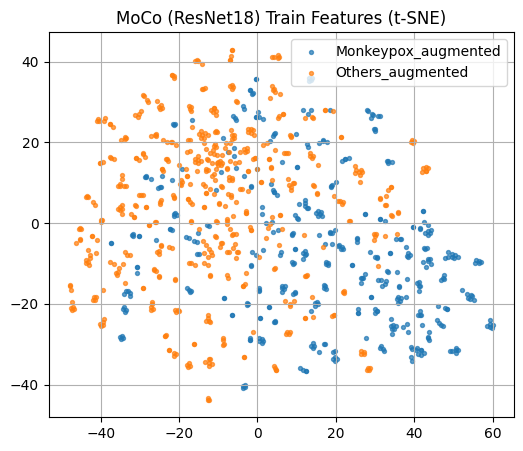

In [10]:
# Cell 10: Build a Plain ResNet-18 Encoder for Visualization + Train Feature t-SNE

# Load encoder for visualization with Identity head (no projection)
encoder_vis = models.resnet18(weights=None)
encoder_vis.fc = nn.Identity()
state = torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"), map_location=DEVICE)

# The saved weights include a projection head (fc) sized PROJ_DIM.
# We load them into a model with Identity fc; only matching layers will load.
missing, unexpected = encoder_vis.load_state_dict(state, strict=False)
# It's normal that 'fc.weight'/'fc.bias' are missing due to Identity.
encoder_vis = encoder_vis.to(DEVICE)
encoder_vis.eval()

vis_features, vis_labels = extract_features(vis_loader, encoder_vis)

print("Computing t-SNE on TRAIN features...")
tsne = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_2d = tsne.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(tsne_2d[idx,0], tsne_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (t-SNE)")
plt.grid(True)
plt.show()


Computing UMAP on TRAIN features...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


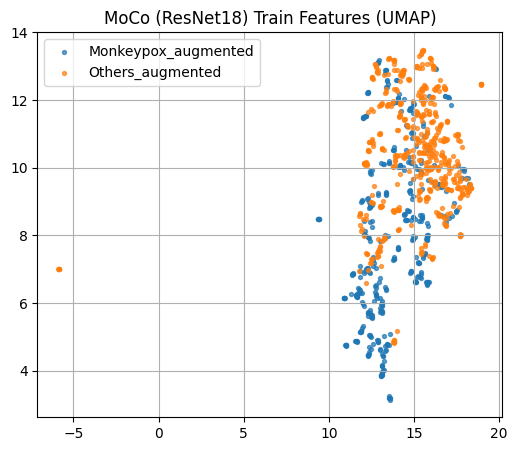

In [11]:
# Cell 11: UMAP on Train Features

print("Computing UMAP on TRAIN features...")
reducer = umap.UMAP(n_components=2, random_state=SEED)
umap_2d = reducer.fit_transform(vis_features)
plt.figure(figsize=(6,5))
for c in np.unique(vis_labels):
    idx = vis_labels == c
    plt.scatter(umap_2d[idx,0], umap_2d[idx,1], s=8, label=IDX_TO_CLASS[c], alpha=0.7)
plt.legend()
plt.title("MoCo (ResNet18) Train Features (UMAP)")
plt.grid(True)
plt.show()


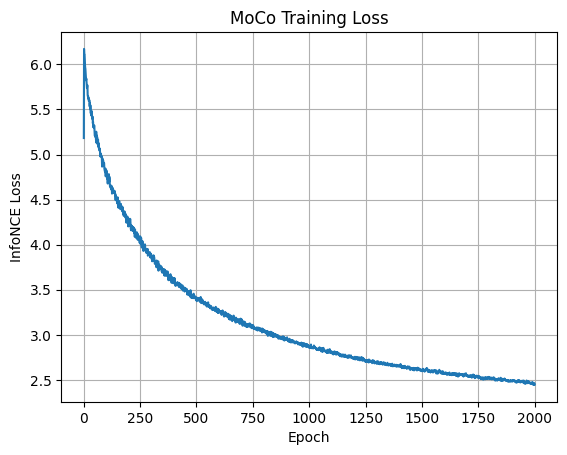

In [12]:
# Cell 12: SSL Loss Curve

plot_curve(moco_loss_history, "MoCo Training Loss", "Epoch", "InfoNCE Loss")


In [13]:
# Cell 13: Linear Evaluation (Train on 30% Train Split)

# Freeze encoder backbone (no projection) for linear eval
encoder_linear = models.resnet18(weights=None)
encoder_linear.fc = nn.Identity()
encoder_linear.load_state_dict(torch.load(os.path.join(SAVE_DIR, "moco_resnet18_encoder.pth"),
                                          map_location=DEVICE), strict=False)
encoder_linear = encoder_linear.to(DEVICE)
for p in encoder_linear.parameters():
    p.requires_grad = False
encoder_linear.eval()

classifier = nn.Linear(FEATURE_DIM, NUM_CLASSES).to(DEVICE)
opt_lin = torch.optim.Adam(classifier.parameters(), lr=LR_LINEAR)
criterion_ce = nn.CrossEntropyLoss()

lin_train_losses, lin_val_losses = [], []   # (we don't have a separate val split here)
lin_train_accs, lin_val_accs = [], []

print("Starting linear evaluation (training on 30% train split)...")
for epoch in range(1, EPOCHS_LINEAR + 1):
    classifier.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in tqdm(train_loader, desc=f"Linear Epoch {epoch}/{EPOCHS_LINEAR}"):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        with torch.no_grad():
            feats = encoder_linear(imgs)
        logits = classifier(feats)
        loss = criterion_ce(logits, labels)

        opt_lin.zero_grad()
        loss.backward()
        opt_lin.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    lin_train_losses.append(train_loss)
    lin_train_accs.append(train_acc)

    print(f"Linear Epoch {epoch}: TrainLoss={train_loss:.4f} Acc={train_acc:.3f}")


Starting linear evaluation (training on 30% train split)...


Linear Epoch 1/2000: 100%|██████████| 15/15 [00:01<00:00,  7.88it/s]


Linear Epoch 1: TrainLoss=0.6737 Acc=0.573


Linear Epoch 2/2000: 100%|██████████| 15/15 [00:01<00:00,  7.86it/s]


Linear Epoch 2: TrainLoss=0.6174 Acc=0.657


Linear Epoch 3/2000: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]


Linear Epoch 3: TrainLoss=0.5803 Acc=0.745


Linear Epoch 4/2000: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


Linear Epoch 4: TrainLoss=0.5537 Acc=0.774


Linear Epoch 5/2000: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]


Linear Epoch 5: TrainLoss=0.5329 Acc=0.790


Linear Epoch 6/2000: 100%|██████████| 15/15 [00:01<00:00,  8.19it/s]


Linear Epoch 6: TrainLoss=0.5162 Acc=0.799


Linear Epoch 7/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 7: TrainLoss=0.5022 Acc=0.805


Linear Epoch 8/2000: 100%|██████████| 15/15 [00:01<00:00,  8.16it/s]


Linear Epoch 8: TrainLoss=0.4908 Acc=0.809


Linear Epoch 9/2000: 100%|██████████| 15/15 [00:01<00:00,  8.20it/s]


Linear Epoch 9: TrainLoss=0.4799 Acc=0.809


Linear Epoch 10/2000: 100%|██████████| 15/15 [00:01<00:00,  8.35it/s]


Linear Epoch 10: TrainLoss=0.4699 Acc=0.812


Linear Epoch 11/2000: 100%|██████████| 15/15 [00:01<00:00,  8.11it/s]


Linear Epoch 11: TrainLoss=0.4613 Acc=0.814


Linear Epoch 12/2000: 100%|██████████| 15/15 [00:01<00:00,  7.91it/s]


Linear Epoch 12: TrainLoss=0.4534 Acc=0.815


Linear Epoch 13/2000: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


Linear Epoch 13: TrainLoss=0.4462 Acc=0.820


Linear Epoch 14/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 14: TrainLoss=0.4394 Acc=0.828


Linear Epoch 15/2000: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


Linear Epoch 15: TrainLoss=0.4331 Acc=0.830


Linear Epoch 16/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 16: TrainLoss=0.4269 Acc=0.832


Linear Epoch 17/2000: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Linear Epoch 17: TrainLoss=0.4215 Acc=0.835


Linear Epoch 18/2000: 100%|██████████| 15/15 [00:01<00:00,  8.27it/s]


Linear Epoch 18: TrainLoss=0.4158 Acc=0.837


Linear Epoch 19/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 19: TrainLoss=0.4112 Acc=0.839


Linear Epoch 20/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 20: TrainLoss=0.4064 Acc=0.839


Linear Epoch 21/2000: 100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


Linear Epoch 21: TrainLoss=0.4010 Acc=0.843


Linear Epoch 22/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 22: TrainLoss=0.3966 Acc=0.845


Linear Epoch 23/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 23: TrainLoss=0.3924 Acc=0.846


Linear Epoch 24/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 24: TrainLoss=0.3884 Acc=0.844


Linear Epoch 25/2000: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


Linear Epoch 25: TrainLoss=0.3840 Acc=0.850


Linear Epoch 26/2000: 100%|██████████| 15/15 [00:01<00:00,  8.57it/s]


Linear Epoch 26: TrainLoss=0.3803 Acc=0.853


Linear Epoch 27/2000: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


Linear Epoch 27: TrainLoss=0.3764 Acc=0.853


Linear Epoch 28/2000: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Linear Epoch 28: TrainLoss=0.3726 Acc=0.850


Linear Epoch 29/2000: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


Linear Epoch 29: TrainLoss=0.3691 Acc=0.853


Linear Epoch 30/2000: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


Linear Epoch 30: TrainLoss=0.3657 Acc=0.856


Linear Epoch 31/2000: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Linear Epoch 31: TrainLoss=0.3624 Acc=0.856


Linear Epoch 32/2000: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


Linear Epoch 32: TrainLoss=0.3589 Acc=0.860


Linear Epoch 33/2000: 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


Linear Epoch 33: TrainLoss=0.3558 Acc=0.862


Linear Epoch 34/2000: 100%|██████████| 15/15 [00:01<00:00,  8.48it/s]


Linear Epoch 34: TrainLoss=0.3526 Acc=0.867


Linear Epoch 35/2000: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


Linear Epoch 35: TrainLoss=0.3498 Acc=0.865


Linear Epoch 36/2000: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


Linear Epoch 36: TrainLoss=0.3467 Acc=0.864


Linear Epoch 37/2000: 100%|██████████| 15/15 [00:01<00:00,  8.08it/s]


Linear Epoch 37: TrainLoss=0.3439 Acc=0.866


Linear Epoch 38/2000: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


Linear Epoch 38: TrainLoss=0.3412 Acc=0.869


Linear Epoch 39/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 39: TrainLoss=0.3383 Acc=0.868


Linear Epoch 40/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 40: TrainLoss=0.3356 Acc=0.870


Linear Epoch 41/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 41: TrainLoss=0.3333 Acc=0.868


Linear Epoch 42/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 42: TrainLoss=0.3303 Acc=0.871


Linear Epoch 43/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 43: TrainLoss=0.3277 Acc=0.877


Linear Epoch 44/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 44: TrainLoss=0.3253 Acc=0.880


Linear Epoch 45/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 45: TrainLoss=0.3230 Acc=0.878


Linear Epoch 46/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 46: TrainLoss=0.3205 Acc=0.882


Linear Epoch 47/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 47: TrainLoss=0.3180 Acc=0.882


Linear Epoch 48/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 48: TrainLoss=0.3161 Acc=0.878


Linear Epoch 49/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 49: TrainLoss=0.3134 Acc=0.884


Linear Epoch 50/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 50: TrainLoss=0.3113 Acc=0.882


Linear Epoch 51/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 51: TrainLoss=0.3090 Acc=0.882


Linear Epoch 52/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 52: TrainLoss=0.3068 Acc=0.883


Linear Epoch 53/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 53: TrainLoss=0.3049 Acc=0.883


Linear Epoch 54/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 54: TrainLoss=0.3025 Acc=0.884


Linear Epoch 55/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 55: TrainLoss=0.3007 Acc=0.882


Linear Epoch 56/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 56: TrainLoss=0.2987 Acc=0.886


Linear Epoch 57/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 57: TrainLoss=0.2969 Acc=0.888


Linear Epoch 58/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 58: TrainLoss=0.2950 Acc=0.890


Linear Epoch 59/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 59: TrainLoss=0.2927 Acc=0.889


Linear Epoch 60/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 60: TrainLoss=0.2909 Acc=0.887


Linear Epoch 61/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 61: TrainLoss=0.2889 Acc=0.891


Linear Epoch 62/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 62: TrainLoss=0.2871 Acc=0.893


Linear Epoch 63/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 63: TrainLoss=0.2853 Acc=0.892


Linear Epoch 64/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 64: TrainLoss=0.2835 Acc=0.892


Linear Epoch 65/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 65: TrainLoss=0.2817 Acc=0.891


Linear Epoch 66/2000: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Linear Epoch 66: TrainLoss=0.2799 Acc=0.894


Linear Epoch 67/2000: 100%|██████████| 15/15 [00:01<00:00,  8.99it/s]


Linear Epoch 67: TrainLoss=0.2783 Acc=0.898


Linear Epoch 68/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 68: TrainLoss=0.2769 Acc=0.898


Linear Epoch 69/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 69: TrainLoss=0.2750 Acc=0.902


Linear Epoch 70/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 70: TrainLoss=0.2738 Acc=0.909


Linear Epoch 71/2000: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Linear Epoch 71: TrainLoss=0.2718 Acc=0.908


Linear Epoch 72/2000: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


Linear Epoch 72: TrainLoss=0.2701 Acc=0.905


Linear Epoch 73/2000: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


Linear Epoch 73: TrainLoss=0.2684 Acc=0.909


Linear Epoch 74/2000: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Linear Epoch 74: TrainLoss=0.2671 Acc=0.909


Linear Epoch 75/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 75: TrainLoss=0.2654 Acc=0.911


Linear Epoch 76/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 76: TrainLoss=0.2639 Acc=0.911


Linear Epoch 77/2000: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


Linear Epoch 77: TrainLoss=0.2627 Acc=0.913


Linear Epoch 78/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 78: TrainLoss=0.2608 Acc=0.915


Linear Epoch 79/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 79: TrainLoss=0.2594 Acc=0.915


Linear Epoch 80/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 80: TrainLoss=0.2580 Acc=0.916


Linear Epoch 81/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 81: TrainLoss=0.2565 Acc=0.916


Linear Epoch 82/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 82: TrainLoss=0.2552 Acc=0.918


Linear Epoch 83/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 83: TrainLoss=0.2538 Acc=0.921


Linear Epoch 84/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 84: TrainLoss=0.2525 Acc=0.918


Linear Epoch 85/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 85: TrainLoss=0.2510 Acc=0.921


Linear Epoch 86/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 86: TrainLoss=0.2497 Acc=0.921


Linear Epoch 87/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 87: TrainLoss=0.2487 Acc=0.921


Linear Epoch 88/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 88: TrainLoss=0.2472 Acc=0.923


Linear Epoch 89/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 89: TrainLoss=0.2458 Acc=0.921


Linear Epoch 90/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 90: TrainLoss=0.2443 Acc=0.923


Linear Epoch 91/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 91: TrainLoss=0.2431 Acc=0.923


Linear Epoch 92/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 92: TrainLoss=0.2419 Acc=0.923


Linear Epoch 93/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 93: TrainLoss=0.2407 Acc=0.924


Linear Epoch 94/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 94: TrainLoss=0.2395 Acc=0.924


Linear Epoch 95/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 95: TrainLoss=0.2381 Acc=0.927


Linear Epoch 96/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 96: TrainLoss=0.2370 Acc=0.927


Linear Epoch 97/2000: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Linear Epoch 97: TrainLoss=0.2358 Acc=0.927


Linear Epoch 98/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 98: TrainLoss=0.2345 Acc=0.927


Linear Epoch 99/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 99: TrainLoss=0.2335 Acc=0.927


Linear Epoch 100/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 100: TrainLoss=0.2325 Acc=0.929


Linear Epoch 101/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 101: TrainLoss=0.2312 Acc=0.931


Linear Epoch 102/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 102: TrainLoss=0.2303 Acc=0.928


Linear Epoch 103/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 103: TrainLoss=0.2291 Acc=0.929


Linear Epoch 104/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 104: TrainLoss=0.2277 Acc=0.932


Linear Epoch 105/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 105: TrainLoss=0.2266 Acc=0.933


Linear Epoch 106/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 106: TrainLoss=0.2257 Acc=0.932


Linear Epoch 107/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 107: TrainLoss=0.2244 Acc=0.932


Linear Epoch 108/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 108: TrainLoss=0.2234 Acc=0.933


Linear Epoch 109/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 109: TrainLoss=0.2225 Acc=0.933


Linear Epoch 110/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 110: TrainLoss=0.2214 Acc=0.933


Linear Epoch 111/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 111: TrainLoss=0.2203 Acc=0.933


Linear Epoch 112/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 112: TrainLoss=0.2193 Acc=0.933


Linear Epoch 113/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 113: TrainLoss=0.2183 Acc=0.933


Linear Epoch 114/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 114: TrainLoss=0.2173 Acc=0.935


Linear Epoch 115/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 115: TrainLoss=0.2161 Acc=0.935


Linear Epoch 116/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 116: TrainLoss=0.2153 Acc=0.934


Linear Epoch 117/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 117: TrainLoss=0.2144 Acc=0.934


Linear Epoch 118/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 118: TrainLoss=0.2133 Acc=0.936


Linear Epoch 119/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 119: TrainLoss=0.2123 Acc=0.936


Linear Epoch 120/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 120: TrainLoss=0.2113 Acc=0.935


Linear Epoch 121/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 121: TrainLoss=0.2104 Acc=0.936


Linear Epoch 122/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 122: TrainLoss=0.2094 Acc=0.936


Linear Epoch 123/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 123: TrainLoss=0.2086 Acc=0.936


Linear Epoch 124/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 124: TrainLoss=0.2075 Acc=0.936


Linear Epoch 125/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 125: TrainLoss=0.2066 Acc=0.938


Linear Epoch 126/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 126: TrainLoss=0.2058 Acc=0.938


Linear Epoch 127/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 127: TrainLoss=0.2050 Acc=0.938


Linear Epoch 128/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 128: TrainLoss=0.2040 Acc=0.939


Linear Epoch 129/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 129: TrainLoss=0.2032 Acc=0.939


Linear Epoch 130/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 130: TrainLoss=0.2023 Acc=0.941


Linear Epoch 131/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 131: TrainLoss=0.2013 Acc=0.941


Linear Epoch 132/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 132: TrainLoss=0.2005 Acc=0.943


Linear Epoch 133/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 133: TrainLoss=0.1996 Acc=0.941


Linear Epoch 134/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 134: TrainLoss=0.1987 Acc=0.943


Linear Epoch 135/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 135: TrainLoss=0.1981 Acc=0.941


Linear Epoch 136/2000: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


Linear Epoch 136: TrainLoss=0.1973 Acc=0.943


Linear Epoch 137/2000: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


Linear Epoch 137: TrainLoss=0.1963 Acc=0.944


Linear Epoch 138/2000: 100%|██████████| 15/15 [00:01<00:00,  8.72it/s]


Linear Epoch 138: TrainLoss=0.1954 Acc=0.945


Linear Epoch 139/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 139: TrainLoss=0.1948 Acc=0.944


Linear Epoch 140/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 140: TrainLoss=0.1938 Acc=0.945


Linear Epoch 141/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 141: TrainLoss=0.1932 Acc=0.946


Linear Epoch 142/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 142: TrainLoss=0.1923 Acc=0.945


Linear Epoch 143/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 143: TrainLoss=0.1917 Acc=0.947


Linear Epoch 144/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 144: TrainLoss=0.1906 Acc=0.947


Linear Epoch 145/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 145: TrainLoss=0.1899 Acc=0.947


Linear Epoch 146/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 146: TrainLoss=0.1891 Acc=0.947


Linear Epoch 147/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 147: TrainLoss=0.1886 Acc=0.948


Linear Epoch 148/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 148: TrainLoss=0.1875 Acc=0.948


Linear Epoch 149/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 149: TrainLoss=0.1869 Acc=0.949


Linear Epoch 150/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 150: TrainLoss=0.1860 Acc=0.950


Linear Epoch 151/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 151: TrainLoss=0.1854 Acc=0.949


Linear Epoch 152/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 152: TrainLoss=0.1846 Acc=0.951


Linear Epoch 153/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 153: TrainLoss=0.1838 Acc=0.952


Linear Epoch 154/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 154: TrainLoss=0.1833 Acc=0.952


Linear Epoch 155/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 155: TrainLoss=0.1824 Acc=0.952


Linear Epoch 156/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 156: TrainLoss=0.1823 Acc=0.953


Linear Epoch 157/2000: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Linear Epoch 157: TrainLoss=0.1813 Acc=0.952


Linear Epoch 158/2000: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


Linear Epoch 158: TrainLoss=0.1804 Acc=0.953


Linear Epoch 159/2000: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


Linear Epoch 159: TrainLoss=0.1797 Acc=0.954


Linear Epoch 160/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 160: TrainLoss=0.1790 Acc=0.954


Linear Epoch 161/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 161: TrainLoss=0.1782 Acc=0.954


Linear Epoch 162/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 162: TrainLoss=0.1776 Acc=0.954


Linear Epoch 163/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 163: TrainLoss=0.1769 Acc=0.954


Linear Epoch 164/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 164: TrainLoss=0.1763 Acc=0.954


Linear Epoch 165/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 165: TrainLoss=0.1755 Acc=0.954


Linear Epoch 166/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 166: TrainLoss=0.1749 Acc=0.954


Linear Epoch 167/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 167: TrainLoss=0.1742 Acc=0.955


Linear Epoch 168/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 168: TrainLoss=0.1736 Acc=0.955


Linear Epoch 169/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 169: TrainLoss=0.1729 Acc=0.955


Linear Epoch 170/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 170: TrainLoss=0.1723 Acc=0.955


Linear Epoch 171/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 171: TrainLoss=0.1715 Acc=0.955


Linear Epoch 172/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 172: TrainLoss=0.1708 Acc=0.955


Linear Epoch 173/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 173: TrainLoss=0.1703 Acc=0.955


Linear Epoch 174/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 174: TrainLoss=0.1696 Acc=0.956


Linear Epoch 175/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 175: TrainLoss=0.1693 Acc=0.955


Linear Epoch 176/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 176: TrainLoss=0.1686 Acc=0.956


Linear Epoch 177/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 177: TrainLoss=0.1679 Acc=0.955


Linear Epoch 178/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 178: TrainLoss=0.1673 Acc=0.955


Linear Epoch 179/2000: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Linear Epoch 179: TrainLoss=0.1667 Acc=0.956


Linear Epoch 180/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 180: TrainLoss=0.1660 Acc=0.956


Linear Epoch 181/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 181: TrainLoss=0.1655 Acc=0.957


Linear Epoch 182/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 182: TrainLoss=0.1648 Acc=0.956


Linear Epoch 183/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 183: TrainLoss=0.1643 Acc=0.956


Linear Epoch 184/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 184: TrainLoss=0.1636 Acc=0.956


Linear Epoch 185/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 185: TrainLoss=0.1630 Acc=0.957


Linear Epoch 186/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 186: TrainLoss=0.1629 Acc=0.957


Linear Epoch 187/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 187: TrainLoss=0.1618 Acc=0.956


Linear Epoch 188/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 188: TrainLoss=0.1613 Acc=0.956


Linear Epoch 189/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 189: TrainLoss=0.1609 Acc=0.959


Linear Epoch 190/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 190: TrainLoss=0.1601 Acc=0.957


Linear Epoch 191/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 191: TrainLoss=0.1597 Acc=0.958


Linear Epoch 192/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 192: TrainLoss=0.1590 Acc=0.958


Linear Epoch 193/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 193: TrainLoss=0.1586 Acc=0.959


Linear Epoch 194/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 194: TrainLoss=0.1580 Acc=0.958


Linear Epoch 195/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 195: TrainLoss=0.1573 Acc=0.958


Linear Epoch 196/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 196: TrainLoss=0.1569 Acc=0.959


Linear Epoch 197/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 197: TrainLoss=0.1564 Acc=0.959


Linear Epoch 198/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 198: TrainLoss=0.1558 Acc=0.959


Linear Epoch 199/2000: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Linear Epoch 199: TrainLoss=0.1553 Acc=0.960


Linear Epoch 200/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 200: TrainLoss=0.1547 Acc=0.962


Linear Epoch 201/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 201: TrainLoss=0.1544 Acc=0.961


Linear Epoch 202/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 202: TrainLoss=0.1537 Acc=0.960


Linear Epoch 203/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 203: TrainLoss=0.1532 Acc=0.962


Linear Epoch 204/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 204: TrainLoss=0.1527 Acc=0.962


Linear Epoch 205/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 205: TrainLoss=0.1521 Acc=0.960


Linear Epoch 206/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 206: TrainLoss=0.1516 Acc=0.963


Linear Epoch 207/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 207: TrainLoss=0.1511 Acc=0.963


Linear Epoch 208/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 208: TrainLoss=0.1506 Acc=0.963


Linear Epoch 209/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 209: TrainLoss=0.1502 Acc=0.963


Linear Epoch 210/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 210: TrainLoss=0.1496 Acc=0.963


Linear Epoch 211/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 211: TrainLoss=0.1490 Acc=0.964


Linear Epoch 212/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 212: TrainLoss=0.1486 Acc=0.966


Linear Epoch 213/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 213: TrainLoss=0.1482 Acc=0.966


Linear Epoch 214/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 214: TrainLoss=0.1477 Acc=0.964


Linear Epoch 215/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 215: TrainLoss=0.1471 Acc=0.964


Linear Epoch 216/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 216: TrainLoss=0.1466 Acc=0.964


Linear Epoch 217/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 217: TrainLoss=0.1463 Acc=0.967


Linear Epoch 218/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 218: TrainLoss=0.1458 Acc=0.966


Linear Epoch 219/2000: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


Linear Epoch 219: TrainLoss=0.1452 Acc=0.967


Linear Epoch 220/2000: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


Linear Epoch 220: TrainLoss=0.1448 Acc=0.967


Linear Epoch 221/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 221: TrainLoss=0.1443 Acc=0.967


Linear Epoch 222/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 222: TrainLoss=0.1438 Acc=0.968


Linear Epoch 223/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 223: TrainLoss=0.1433 Acc=0.968


Linear Epoch 224/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 224: TrainLoss=0.1429 Acc=0.968


Linear Epoch 225/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 225: TrainLoss=0.1424 Acc=0.968


Linear Epoch 226/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 226: TrainLoss=0.1421 Acc=0.969


Linear Epoch 227/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 227: TrainLoss=0.1416 Acc=0.969


Linear Epoch 228/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 228: TrainLoss=0.1412 Acc=0.970


Linear Epoch 229/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 229: TrainLoss=0.1406 Acc=0.969


Linear Epoch 230/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 230: TrainLoss=0.1403 Acc=0.970


Linear Epoch 231/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 231: TrainLoss=0.1399 Acc=0.970


Linear Epoch 232/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 232: TrainLoss=0.1393 Acc=0.970


Linear Epoch 233/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 233: TrainLoss=0.1389 Acc=0.970


Linear Epoch 234/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 234: TrainLoss=0.1384 Acc=0.970


Linear Epoch 235/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 235: TrainLoss=0.1381 Acc=0.970


Linear Epoch 236/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 236: TrainLoss=0.1377 Acc=0.970


Linear Epoch 237/2000: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Linear Epoch 237: TrainLoss=0.1372 Acc=0.970


Linear Epoch 238/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 238: TrainLoss=0.1368 Acc=0.970


Linear Epoch 239/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 239: TrainLoss=0.1363 Acc=0.971


Linear Epoch 240/2000: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]


Linear Epoch 240: TrainLoss=0.1359 Acc=0.972


Linear Epoch 241/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 241: TrainLoss=0.1356 Acc=0.972


Linear Epoch 242/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 242: TrainLoss=0.1351 Acc=0.973


Linear Epoch 243/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 243: TrainLoss=0.1346 Acc=0.972


Linear Epoch 244/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 244: TrainLoss=0.1343 Acc=0.971


Linear Epoch 245/2000: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Linear Epoch 245: TrainLoss=0.1338 Acc=0.974


Linear Epoch 246/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 246: TrainLoss=0.1333 Acc=0.974


Linear Epoch 247/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 247: TrainLoss=0.1330 Acc=0.975


Linear Epoch 248/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 248: TrainLoss=0.1326 Acc=0.973


Linear Epoch 249/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 249: TrainLoss=0.1322 Acc=0.973


Linear Epoch 250/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 250: TrainLoss=0.1318 Acc=0.974


Linear Epoch 251/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 251: TrainLoss=0.1313 Acc=0.974


Linear Epoch 252/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 252: TrainLoss=0.1309 Acc=0.974


Linear Epoch 253/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 253: TrainLoss=0.1305 Acc=0.975


Linear Epoch 254/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 254: TrainLoss=0.1301 Acc=0.975


Linear Epoch 255/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 255: TrainLoss=0.1297 Acc=0.974


Linear Epoch 256/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 256: TrainLoss=0.1293 Acc=0.975


Linear Epoch 257/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 257: TrainLoss=0.1291 Acc=0.974


Linear Epoch 258/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 258: TrainLoss=0.1287 Acc=0.975


Linear Epoch 259/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 259: TrainLoss=0.1283 Acc=0.975


Linear Epoch 260/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 260: TrainLoss=0.1278 Acc=0.975


Linear Epoch 261/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 261: TrainLoss=0.1274 Acc=0.975


Linear Epoch 262/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 262: TrainLoss=0.1271 Acc=0.976


Linear Epoch 263/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 263: TrainLoss=0.1268 Acc=0.977


Linear Epoch 264/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 264: TrainLoss=0.1264 Acc=0.976


Linear Epoch 265/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 265: TrainLoss=0.1260 Acc=0.976


Linear Epoch 266/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 266: TrainLoss=0.1256 Acc=0.976


Linear Epoch 267/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 267: TrainLoss=0.1253 Acc=0.977


Linear Epoch 268/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 268: TrainLoss=0.1248 Acc=0.977


Linear Epoch 269/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 269: TrainLoss=0.1245 Acc=0.976


Linear Epoch 270/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 270: TrainLoss=0.1242 Acc=0.976


Linear Epoch 271/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 271: TrainLoss=0.1239 Acc=0.977


Linear Epoch 272/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 272: TrainLoss=0.1234 Acc=0.976


Linear Epoch 273/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 273: TrainLoss=0.1232 Acc=0.979


Linear Epoch 274/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 274: TrainLoss=0.1228 Acc=0.979


Linear Epoch 275/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 275: TrainLoss=0.1224 Acc=0.978


Linear Epoch 276/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 276: TrainLoss=0.1220 Acc=0.979


Linear Epoch 277/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 277: TrainLoss=0.1218 Acc=0.979


Linear Epoch 278/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 278: TrainLoss=0.1213 Acc=0.977


Linear Epoch 279/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 279: TrainLoss=0.1210 Acc=0.979


Linear Epoch 280/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 280: TrainLoss=0.1206 Acc=0.980


Linear Epoch 281/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 281: TrainLoss=0.1203 Acc=0.979


Linear Epoch 282/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 282: TrainLoss=0.1200 Acc=0.979


Linear Epoch 283/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 283: TrainLoss=0.1196 Acc=0.979


Linear Epoch 284/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 284: TrainLoss=0.1192 Acc=0.980


Linear Epoch 285/2000: 100%|██████████| 15/15 [00:01<00:00, 10.03it/s]


Linear Epoch 285: TrainLoss=0.1188 Acc=0.981


Linear Epoch 286/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 286: TrainLoss=0.1188 Acc=0.981


Linear Epoch 287/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 287: TrainLoss=0.1181 Acc=0.980


Linear Epoch 288/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 288: TrainLoss=0.1179 Acc=0.979


Linear Epoch 289/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 289: TrainLoss=0.1176 Acc=0.982


Linear Epoch 290/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 290: TrainLoss=0.1172 Acc=0.981


Linear Epoch 291/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 291: TrainLoss=0.1169 Acc=0.981


Linear Epoch 292/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 292: TrainLoss=0.1165 Acc=0.981


Linear Epoch 293/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 293: TrainLoss=0.1162 Acc=0.981


Linear Epoch 294/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 294: TrainLoss=0.1158 Acc=0.983


Linear Epoch 295/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 295: TrainLoss=0.1156 Acc=0.980


Linear Epoch 296/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 296: TrainLoss=0.1152 Acc=0.983


Linear Epoch 297/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 297: TrainLoss=0.1151 Acc=0.983


Linear Epoch 298/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 298: TrainLoss=0.1147 Acc=0.984


Linear Epoch 299/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 299: TrainLoss=0.1143 Acc=0.984


Linear Epoch 300/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 300: TrainLoss=0.1140 Acc=0.983


Linear Epoch 301/2000: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


Linear Epoch 301: TrainLoss=0.1138 Acc=0.983


Linear Epoch 302/2000: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


Linear Epoch 302: TrainLoss=0.1134 Acc=0.984


Linear Epoch 303/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 303: TrainLoss=0.1131 Acc=0.984


Linear Epoch 304/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 304: TrainLoss=0.1130 Acc=0.982


Linear Epoch 305/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 305: TrainLoss=0.1123 Acc=0.984


Linear Epoch 306/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 306: TrainLoss=0.1123 Acc=0.984


Linear Epoch 307/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 307: TrainLoss=0.1121 Acc=0.983


Linear Epoch 308/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 308: TrainLoss=0.1117 Acc=0.984


Linear Epoch 309/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 309: TrainLoss=0.1113 Acc=0.985


Linear Epoch 310/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 310: TrainLoss=0.1110 Acc=0.985


Linear Epoch 311/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 311: TrainLoss=0.1106 Acc=0.984


Linear Epoch 312/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 312: TrainLoss=0.1103 Acc=0.984


Linear Epoch 313/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 313: TrainLoss=0.1100 Acc=0.985


Linear Epoch 314/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 314: TrainLoss=0.1096 Acc=0.985


Linear Epoch 315/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 315: TrainLoss=0.1093 Acc=0.984


Linear Epoch 316/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 316: TrainLoss=0.1091 Acc=0.984


Linear Epoch 317/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 317: TrainLoss=0.1088 Acc=0.984


Linear Epoch 318/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 318: TrainLoss=0.1085 Acc=0.985


Linear Epoch 319/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 319: TrainLoss=0.1083 Acc=0.985


Linear Epoch 320/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 320: TrainLoss=0.1079 Acc=0.985


Linear Epoch 321/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 321: TrainLoss=0.1078 Acc=0.984


Linear Epoch 322/2000: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


Linear Epoch 322: TrainLoss=0.1075 Acc=0.985


Linear Epoch 323/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 323: TrainLoss=0.1070 Acc=0.985


Linear Epoch 324/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 324: TrainLoss=0.1068 Acc=0.984


Linear Epoch 325/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 325: TrainLoss=0.1068 Acc=0.985


Linear Epoch 326/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 326: TrainLoss=0.1062 Acc=0.985


Linear Epoch 327/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 327: TrainLoss=0.1061 Acc=0.985


Linear Epoch 328/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 328: TrainLoss=0.1058 Acc=0.985


Linear Epoch 329/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 329: TrainLoss=0.1055 Acc=0.985


Linear Epoch 330/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 330: TrainLoss=0.1051 Acc=0.985


Linear Epoch 331/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 331: TrainLoss=0.1048 Acc=0.985


Linear Epoch 332/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 332: TrainLoss=0.1046 Acc=0.985


Linear Epoch 333/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 333: TrainLoss=0.1043 Acc=0.985


Linear Epoch 334/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 334: TrainLoss=0.1040 Acc=0.985


Linear Epoch 335/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 335: TrainLoss=0.1039 Acc=0.986


Linear Epoch 336/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 336: TrainLoss=0.1036 Acc=0.985


Linear Epoch 337/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 337: TrainLoss=0.1032 Acc=0.985


Linear Epoch 338/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 338: TrainLoss=0.1029 Acc=0.985


Linear Epoch 339/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 339: TrainLoss=0.1026 Acc=0.985


Linear Epoch 340/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 340: TrainLoss=0.1024 Acc=0.986


Linear Epoch 341/2000: 100%|██████████| 15/15 [00:01<00:00,  9.18it/s]


Linear Epoch 341: TrainLoss=0.1021 Acc=0.985


Linear Epoch 342/2000: 100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


Linear Epoch 342: TrainLoss=0.1018 Acc=0.985


Linear Epoch 343/2000: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Linear Epoch 343: TrainLoss=0.1015 Acc=0.986


Linear Epoch 344/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 344: TrainLoss=0.1013 Acc=0.986


Linear Epoch 345/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 345: TrainLoss=0.1010 Acc=0.986


Linear Epoch 346/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 346: TrainLoss=0.1008 Acc=0.986


Linear Epoch 347/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 347: TrainLoss=0.1005 Acc=0.986


Linear Epoch 348/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 348: TrainLoss=0.1003 Acc=0.986


Linear Epoch 349/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 349: TrainLoss=0.1000 Acc=0.986


Linear Epoch 350/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 350: TrainLoss=0.1000 Acc=0.986


Linear Epoch 351/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 351: TrainLoss=0.0995 Acc=0.986


Linear Epoch 352/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 352: TrainLoss=0.0993 Acc=0.985


Linear Epoch 353/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 353: TrainLoss=0.0989 Acc=0.986


Linear Epoch 354/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 354: TrainLoss=0.0988 Acc=0.986


Linear Epoch 355/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 355: TrainLoss=0.0985 Acc=0.986


Linear Epoch 356/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 356: TrainLoss=0.0982 Acc=0.986


Linear Epoch 357/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 357: TrainLoss=0.0980 Acc=0.986


Linear Epoch 358/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 358: TrainLoss=0.0977 Acc=0.986


Linear Epoch 359/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 359: TrainLoss=0.0974 Acc=0.986


Linear Epoch 360/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 360: TrainLoss=0.0973 Acc=0.986


Linear Epoch 361/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 361: TrainLoss=0.0970 Acc=0.986


Linear Epoch 362/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 362: TrainLoss=0.0967 Acc=0.986


Linear Epoch 363/2000: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


Linear Epoch 363: TrainLoss=0.0965 Acc=0.986


Linear Epoch 364/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 364: TrainLoss=0.0963 Acc=0.986


Linear Epoch 365/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 365: TrainLoss=0.0960 Acc=0.986


Linear Epoch 366/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 366: TrainLoss=0.0958 Acc=0.986


Linear Epoch 367/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 367: TrainLoss=0.0955 Acc=0.986


Linear Epoch 368/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 368: TrainLoss=0.0953 Acc=0.987


Linear Epoch 369/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 369: TrainLoss=0.0950 Acc=0.987


Linear Epoch 370/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 370: TrainLoss=0.0948 Acc=0.987


Linear Epoch 371/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 371: TrainLoss=0.0949 Acc=0.987


Linear Epoch 372/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 372: TrainLoss=0.0944 Acc=0.987


Linear Epoch 373/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 373: TrainLoss=0.0941 Acc=0.987


Linear Epoch 374/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 374: TrainLoss=0.0938 Acc=0.987


Linear Epoch 375/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 375: TrainLoss=0.0936 Acc=0.987


Linear Epoch 376/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 376: TrainLoss=0.0933 Acc=0.987


Linear Epoch 377/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 377: TrainLoss=0.0932 Acc=0.987


Linear Epoch 378/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 378: TrainLoss=0.0930 Acc=0.987


Linear Epoch 379/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 379: TrainLoss=0.0926 Acc=0.987


Linear Epoch 380/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 380: TrainLoss=0.0924 Acc=0.987


Linear Epoch 381/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 381: TrainLoss=0.0922 Acc=0.987


Linear Epoch 382/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 382: TrainLoss=0.0921 Acc=0.989


Linear Epoch 383/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 383: TrainLoss=0.0917 Acc=0.987


Linear Epoch 384/2000: 100%|██████████| 15/15 [00:01<00:00,  8.24it/s]


Linear Epoch 384: TrainLoss=0.0915 Acc=0.987


Linear Epoch 385/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 385: TrainLoss=0.0913 Acc=0.987


Linear Epoch 386/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 386: TrainLoss=0.0910 Acc=0.987


Linear Epoch 387/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 387: TrainLoss=0.0908 Acc=0.989


Linear Epoch 388/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 388: TrainLoss=0.0906 Acc=0.989


Linear Epoch 389/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 389: TrainLoss=0.0905 Acc=0.989


Linear Epoch 390/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 390: TrainLoss=0.0903 Acc=0.989


Linear Epoch 391/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 391: TrainLoss=0.0900 Acc=0.989


Linear Epoch 392/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 392: TrainLoss=0.0897 Acc=0.989


Linear Epoch 393/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 393: TrainLoss=0.0895 Acc=0.989


Linear Epoch 394/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 394: TrainLoss=0.0893 Acc=0.989


Linear Epoch 395/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 395: TrainLoss=0.0891 Acc=0.989


Linear Epoch 396/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 396: TrainLoss=0.0889 Acc=0.989


Linear Epoch 397/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 397: TrainLoss=0.0886 Acc=0.989


Linear Epoch 398/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 398: TrainLoss=0.0885 Acc=0.990


Linear Epoch 399/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 399: TrainLoss=0.0883 Acc=0.989


Linear Epoch 400/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 400: TrainLoss=0.0884 Acc=0.989


Linear Epoch 401/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 401: TrainLoss=0.0879 Acc=0.990


Linear Epoch 402/2000: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Linear Epoch 402: TrainLoss=0.0876 Acc=0.990


Linear Epoch 403/2000: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Linear Epoch 403: TrainLoss=0.0875 Acc=0.990


Linear Epoch 404/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 404: TrainLoss=0.0872 Acc=0.990


Linear Epoch 405/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 405: TrainLoss=0.0870 Acc=0.990


Linear Epoch 406/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 406: TrainLoss=0.0869 Acc=0.990


Linear Epoch 407/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 407: TrainLoss=0.0868 Acc=0.990


Linear Epoch 408/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 408: TrainLoss=0.0863 Acc=0.990


Linear Epoch 409/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 409: TrainLoss=0.0861 Acc=0.990


Linear Epoch 410/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 410: TrainLoss=0.0859 Acc=0.990


Linear Epoch 411/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 411: TrainLoss=0.0857 Acc=0.990


Linear Epoch 412/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 412: TrainLoss=0.0855 Acc=0.990


Linear Epoch 413/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 413: TrainLoss=0.0855 Acc=0.990


Linear Epoch 414/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 414: TrainLoss=0.0853 Acc=0.991


Linear Epoch 415/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 415: TrainLoss=0.0849 Acc=0.990


Linear Epoch 416/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 416: TrainLoss=0.0847 Acc=0.990


Linear Epoch 417/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 417: TrainLoss=0.0845 Acc=0.991


Linear Epoch 418/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 418: TrainLoss=0.0844 Acc=0.991


Linear Epoch 419/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 419: TrainLoss=0.0842 Acc=0.991


Linear Epoch 420/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 420: TrainLoss=0.0838 Acc=0.991


Linear Epoch 421/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 421: TrainLoss=0.0837 Acc=0.992


Linear Epoch 422/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 422: TrainLoss=0.0835 Acc=0.992


Linear Epoch 423/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 423: TrainLoss=0.0833 Acc=0.991


Linear Epoch 424/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 424: TrainLoss=0.0831 Acc=0.991


Linear Epoch 425/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 425: TrainLoss=0.0829 Acc=0.991


Linear Epoch 426/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 426: TrainLoss=0.0827 Acc=0.991


Linear Epoch 427/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 427: TrainLoss=0.0826 Acc=0.991


Linear Epoch 428/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 428: TrainLoss=0.0823 Acc=0.991


Linear Epoch 429/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 429: TrainLoss=0.0821 Acc=0.992


Linear Epoch 430/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 430: TrainLoss=0.0819 Acc=0.992


Linear Epoch 431/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 431: TrainLoss=0.0817 Acc=0.992


Linear Epoch 432/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 432: TrainLoss=0.0815 Acc=0.991


Linear Epoch 433/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 433: TrainLoss=0.0813 Acc=0.991


Linear Epoch 434/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 434: TrainLoss=0.0811 Acc=0.991


Linear Epoch 435/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 435: TrainLoss=0.0810 Acc=0.992


Linear Epoch 436/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 436: TrainLoss=0.0807 Acc=0.992


Linear Epoch 437/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 437: TrainLoss=0.0805 Acc=0.992


Linear Epoch 438/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 438: TrainLoss=0.0805 Acc=0.991


Linear Epoch 439/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 439: TrainLoss=0.0802 Acc=0.992


Linear Epoch 440/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 440: TrainLoss=0.0800 Acc=0.992


Linear Epoch 441/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 441: TrainLoss=0.0799 Acc=0.992


Linear Epoch 442/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 442: TrainLoss=0.0796 Acc=0.992


Linear Epoch 443/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 443: TrainLoss=0.0796 Acc=0.992


Linear Epoch 444/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 444: TrainLoss=0.0793 Acc=0.992


Linear Epoch 445/2000: 100%|██████████| 15/15 [00:01<00:00,  8.77it/s]


Linear Epoch 445: TrainLoss=0.0791 Acc=0.992


Linear Epoch 446/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 446: TrainLoss=0.0789 Acc=0.992


Linear Epoch 447/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 447: TrainLoss=0.0787 Acc=0.992


Linear Epoch 448/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 448: TrainLoss=0.0786 Acc=0.992


Linear Epoch 449/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 449: TrainLoss=0.0783 Acc=0.992


Linear Epoch 450/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 450: TrainLoss=0.0781 Acc=0.992


Linear Epoch 451/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 451: TrainLoss=0.0779 Acc=0.992


Linear Epoch 452/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 452: TrainLoss=0.0779 Acc=0.992


Linear Epoch 453/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 453: TrainLoss=0.0778 Acc=0.992


Linear Epoch 454/2000: 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Linear Epoch 454: TrainLoss=0.0774 Acc=0.992


Linear Epoch 455/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 455: TrainLoss=0.0772 Acc=0.992


Linear Epoch 456/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 456: TrainLoss=0.0771 Acc=0.992


Linear Epoch 457/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 457: TrainLoss=0.0769 Acc=0.992


Linear Epoch 458/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 458: TrainLoss=0.0767 Acc=0.992


Linear Epoch 459/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 459: TrainLoss=0.0766 Acc=0.992


Linear Epoch 460/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 460: TrainLoss=0.0763 Acc=0.992


Linear Epoch 461/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 461: TrainLoss=0.0761 Acc=0.992


Linear Epoch 462/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 462: TrainLoss=0.0760 Acc=0.992


Linear Epoch 463/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 463: TrainLoss=0.0758 Acc=0.992


Linear Epoch 464/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 464: TrainLoss=0.0757 Acc=0.992


Linear Epoch 465/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 465: TrainLoss=0.0755 Acc=0.992


Linear Epoch 466/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 466: TrainLoss=0.0754 Acc=0.992


Linear Epoch 467/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 467: TrainLoss=0.0751 Acc=0.992


Linear Epoch 468/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 468: TrainLoss=0.0749 Acc=0.992


Linear Epoch 469/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 469: TrainLoss=0.0747 Acc=0.992


Linear Epoch 470/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 470: TrainLoss=0.0746 Acc=0.992


Linear Epoch 471/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 471: TrainLoss=0.0744 Acc=0.993


Linear Epoch 472/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 472: TrainLoss=0.0742 Acc=0.992


Linear Epoch 473/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 473: TrainLoss=0.0742 Acc=0.993


Linear Epoch 474/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 474: TrainLoss=0.0739 Acc=0.992


Linear Epoch 475/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 475: TrainLoss=0.0738 Acc=0.993


Linear Epoch 476/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 476: TrainLoss=0.0736 Acc=0.993


Linear Epoch 477/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 477: TrainLoss=0.0734 Acc=0.993


Linear Epoch 478/2000: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


Linear Epoch 478: TrainLoss=0.0733 Acc=0.993


Linear Epoch 479/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 479: TrainLoss=0.0731 Acc=0.993


Linear Epoch 480/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 480: TrainLoss=0.0730 Acc=0.993


Linear Epoch 481/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 481: TrainLoss=0.0728 Acc=0.993


Linear Epoch 482/2000: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


Linear Epoch 482: TrainLoss=0.0726 Acc=0.993


Linear Epoch 483/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 483: TrainLoss=0.0724 Acc=0.993


Linear Epoch 484/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 484: TrainLoss=0.0723 Acc=0.993


Linear Epoch 485/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 485: TrainLoss=0.0722 Acc=0.993


Linear Epoch 486/2000: 100%|██████████| 15/15 [00:01<00:00,  8.25it/s]


Linear Epoch 486: TrainLoss=0.0719 Acc=0.993


Linear Epoch 487/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 487: TrainLoss=0.0718 Acc=0.993


Linear Epoch 488/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 488: TrainLoss=0.0716 Acc=0.993


Linear Epoch 489/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 489: TrainLoss=0.0714 Acc=0.993


Linear Epoch 490/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 490: TrainLoss=0.0713 Acc=0.993


Linear Epoch 491/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 491: TrainLoss=0.0712 Acc=0.993


Linear Epoch 492/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 492: TrainLoss=0.0709 Acc=0.993


Linear Epoch 493/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 493: TrainLoss=0.0708 Acc=0.993


Linear Epoch 494/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 494: TrainLoss=0.0707 Acc=0.993


Linear Epoch 495/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 495: TrainLoss=0.0705 Acc=0.993


Linear Epoch 496/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 496: TrainLoss=0.0703 Acc=0.993


Linear Epoch 497/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 497: TrainLoss=0.0701 Acc=0.993


Linear Epoch 498/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 498: TrainLoss=0.0700 Acc=0.993


Linear Epoch 499/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 499: TrainLoss=0.0698 Acc=0.993


Linear Epoch 500/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 500: TrainLoss=0.0697 Acc=0.993


Linear Epoch 501/2000: 100%|██████████| 15/15 [00:01<00:00, 10.03it/s]


Linear Epoch 501: TrainLoss=0.0695 Acc=0.993


Linear Epoch 502/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 502: TrainLoss=0.0696 Acc=0.993


Linear Epoch 503/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 503: TrainLoss=0.0692 Acc=0.993


Linear Epoch 504/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 504: TrainLoss=0.0691 Acc=0.993


Linear Epoch 505/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 505: TrainLoss=0.0690 Acc=0.993


Linear Epoch 506/2000: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


Linear Epoch 506: TrainLoss=0.0688 Acc=0.993


Linear Epoch 507/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 507: TrainLoss=0.0686 Acc=0.993


Linear Epoch 508/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 508: TrainLoss=0.0684 Acc=0.993


Linear Epoch 509/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 509: TrainLoss=0.0684 Acc=0.993


Linear Epoch 510/2000: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Linear Epoch 510: TrainLoss=0.0681 Acc=0.993


Linear Epoch 511/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 511: TrainLoss=0.0680 Acc=0.993


Linear Epoch 512/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 512: TrainLoss=0.0679 Acc=0.993


Linear Epoch 513/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 513: TrainLoss=0.0677 Acc=0.993


Linear Epoch 514/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 514: TrainLoss=0.0676 Acc=0.993


Linear Epoch 515/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 515: TrainLoss=0.0674 Acc=0.993


Linear Epoch 516/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 516: TrainLoss=0.0672 Acc=0.993


Linear Epoch 517/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 517: TrainLoss=0.0671 Acc=0.993


Linear Epoch 518/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 518: TrainLoss=0.0669 Acc=0.993


Linear Epoch 519/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 519: TrainLoss=0.0668 Acc=0.993


Linear Epoch 520/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 520: TrainLoss=0.0666 Acc=0.993


Linear Epoch 521/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 521: TrainLoss=0.0665 Acc=0.993


Linear Epoch 522/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 522: TrainLoss=0.0663 Acc=0.993


Linear Epoch 523/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 523: TrainLoss=0.0662 Acc=0.993


Linear Epoch 524/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 524: TrainLoss=0.0660 Acc=0.993


Linear Epoch 525/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 525: TrainLoss=0.0659 Acc=0.993


Linear Epoch 526/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 526: TrainLoss=0.0657 Acc=0.993


Linear Epoch 527/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 527: TrainLoss=0.0656 Acc=0.993


Linear Epoch 528/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 528: TrainLoss=0.0654 Acc=0.993


Linear Epoch 529/2000: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Linear Epoch 529: TrainLoss=0.0653 Acc=0.993


Linear Epoch 530/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 530: TrainLoss=0.0652 Acc=0.993


Linear Epoch 531/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 531: TrainLoss=0.0650 Acc=0.993


Linear Epoch 532/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 532: TrainLoss=0.0649 Acc=0.993


Linear Epoch 533/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 533: TrainLoss=0.0647 Acc=0.993


Linear Epoch 534/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 534: TrainLoss=0.0647 Acc=0.993


Linear Epoch 535/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 535: TrainLoss=0.0644 Acc=0.993


Linear Epoch 536/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 536: TrainLoss=0.0643 Acc=0.993


Linear Epoch 537/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 537: TrainLoss=0.0642 Acc=0.993


Linear Epoch 538/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 538: TrainLoss=0.0640 Acc=0.993


Linear Epoch 539/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 539: TrainLoss=0.0639 Acc=0.993


Linear Epoch 540/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 540: TrainLoss=0.0638 Acc=0.993


Linear Epoch 541/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 541: TrainLoss=0.0636 Acc=0.993


Linear Epoch 542/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 542: TrainLoss=0.0635 Acc=0.993


Linear Epoch 543/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 543: TrainLoss=0.0633 Acc=0.993


Linear Epoch 544/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 544: TrainLoss=0.0634 Acc=0.993


Linear Epoch 545/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 545: TrainLoss=0.0630 Acc=0.993


Linear Epoch 546/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 546: TrainLoss=0.0630 Acc=0.993


Linear Epoch 547/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 547: TrainLoss=0.0629 Acc=0.993


Linear Epoch 548/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 548: TrainLoss=0.0626 Acc=0.993


Linear Epoch 549/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 549: TrainLoss=0.0625 Acc=0.993


Linear Epoch 550/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 550: TrainLoss=0.0623 Acc=0.993


Linear Epoch 551/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 551: TrainLoss=0.0623 Acc=0.993


Linear Epoch 552/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 552: TrainLoss=0.0621 Acc=0.993


Linear Epoch 553/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 553: TrainLoss=0.0619 Acc=0.993


Linear Epoch 554/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 554: TrainLoss=0.0618 Acc=0.993


Linear Epoch 555/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 555: TrainLoss=0.0616 Acc=0.993


Linear Epoch 556/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 556: TrainLoss=0.0615 Acc=0.993


Linear Epoch 557/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 557: TrainLoss=0.0614 Acc=0.993


Linear Epoch 558/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 558: TrainLoss=0.0613 Acc=0.993


Linear Epoch 559/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 559: TrainLoss=0.0612 Acc=0.993


Linear Epoch 560/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 560: TrainLoss=0.0610 Acc=0.993


Linear Epoch 561/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 561: TrainLoss=0.0609 Acc=0.993


Linear Epoch 562/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 562: TrainLoss=0.0608 Acc=0.993


Linear Epoch 563/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 563: TrainLoss=0.0606 Acc=0.993


Linear Epoch 564/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 564: TrainLoss=0.0605 Acc=0.993


Linear Epoch 565/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 565: TrainLoss=0.0603 Acc=0.993


Linear Epoch 566/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 566: TrainLoss=0.0602 Acc=0.993


Linear Epoch 567/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 567: TrainLoss=0.0601 Acc=0.993


Linear Epoch 568/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 568: TrainLoss=0.0599 Acc=0.993


Linear Epoch 569/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 569: TrainLoss=0.0598 Acc=0.993


Linear Epoch 570/2000: 100%|██████████| 15/15 [00:01<00:00,  8.45it/s]


Linear Epoch 570: TrainLoss=0.0597 Acc=0.993


Linear Epoch 571/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 571: TrainLoss=0.0596 Acc=0.993


Linear Epoch 572/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 572: TrainLoss=0.0595 Acc=0.993


Linear Epoch 573/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 573: TrainLoss=0.0594 Acc=0.994


Linear Epoch 574/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 574: TrainLoss=0.0591 Acc=0.994


Linear Epoch 575/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 575: TrainLoss=0.0590 Acc=0.993


Linear Epoch 576/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 576: TrainLoss=0.0589 Acc=0.993


Linear Epoch 577/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 577: TrainLoss=0.0589 Acc=0.993


Linear Epoch 578/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 578: TrainLoss=0.0587 Acc=0.994


Linear Epoch 579/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 579: TrainLoss=0.0586 Acc=0.994


Linear Epoch 580/2000: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s]


Linear Epoch 580: TrainLoss=0.0584 Acc=0.994


Linear Epoch 581/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 581: TrainLoss=0.0583 Acc=0.994


Linear Epoch 582/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 582: TrainLoss=0.0581 Acc=0.994


Linear Epoch 583/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 583: TrainLoss=0.0581 Acc=0.994


Linear Epoch 584/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 584: TrainLoss=0.0579 Acc=0.994


Linear Epoch 585/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 585: TrainLoss=0.0578 Acc=0.994


Linear Epoch 586/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 586: TrainLoss=0.0577 Acc=0.994


Linear Epoch 587/2000: 100%|██████████| 15/15 [00:01<00:00, 10.04it/s]


Linear Epoch 587: TrainLoss=0.0576 Acc=0.994


Linear Epoch 588/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 588: TrainLoss=0.0575 Acc=0.994


Linear Epoch 589/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 589: TrainLoss=0.0573 Acc=0.994


Linear Epoch 590/2000: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]


Linear Epoch 590: TrainLoss=0.0572 Acc=0.994


Linear Epoch 591/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 591: TrainLoss=0.0571 Acc=0.994


Linear Epoch 592/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 592: TrainLoss=0.0569 Acc=0.994


Linear Epoch 593/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 593: TrainLoss=0.0568 Acc=0.994


Linear Epoch 594/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 594: TrainLoss=0.0568 Acc=0.994


Linear Epoch 595/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 595: TrainLoss=0.0568 Acc=0.994


Linear Epoch 596/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 596: TrainLoss=0.0564 Acc=0.994


Linear Epoch 597/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 597: TrainLoss=0.0563 Acc=0.994


Linear Epoch 598/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 598: TrainLoss=0.0562 Acc=0.994


Linear Epoch 599/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 599: TrainLoss=0.0561 Acc=0.994


Linear Epoch 600/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 600: TrainLoss=0.0560 Acc=0.994


Linear Epoch 601/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 601: TrainLoss=0.0558 Acc=0.994


Linear Epoch 602/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 602: TrainLoss=0.0561 Acc=0.994


Linear Epoch 603/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 603: TrainLoss=0.0557 Acc=0.994


Linear Epoch 604/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 604: TrainLoss=0.0556 Acc=0.994


Linear Epoch 605/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 605: TrainLoss=0.0553 Acc=0.994


Linear Epoch 606/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 606: TrainLoss=0.0553 Acc=0.994


Linear Epoch 607/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 607: TrainLoss=0.0551 Acc=0.994


Linear Epoch 608/2000: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Linear Epoch 608: TrainLoss=0.0550 Acc=0.994


Linear Epoch 609/2000: 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Linear Epoch 609: TrainLoss=0.0549 Acc=0.994


Linear Epoch 610/2000: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


Linear Epoch 610: TrainLoss=0.0548 Acc=0.994


Linear Epoch 611/2000: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


Linear Epoch 611: TrainLoss=0.0548 Acc=0.994


Linear Epoch 612/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 612: TrainLoss=0.0546 Acc=0.994


Linear Epoch 613/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 613: TrainLoss=0.0545 Acc=0.994


Linear Epoch 614/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 614: TrainLoss=0.0544 Acc=0.994


Linear Epoch 615/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 615: TrainLoss=0.0543 Acc=0.994


Linear Epoch 616/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 616: TrainLoss=0.0541 Acc=0.994


Linear Epoch 617/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 617: TrainLoss=0.0540 Acc=0.994


Linear Epoch 618/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 618: TrainLoss=0.0539 Acc=0.994


Linear Epoch 619/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 619: TrainLoss=0.0538 Acc=0.994


Linear Epoch 620/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 620: TrainLoss=0.0536 Acc=0.994


Linear Epoch 621/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 621: TrainLoss=0.0536 Acc=0.994


Linear Epoch 622/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 622: TrainLoss=0.0535 Acc=0.994


Linear Epoch 623/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 623: TrainLoss=0.0534 Acc=0.994


Linear Epoch 624/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 624: TrainLoss=0.0532 Acc=0.994


Linear Epoch 625/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 625: TrainLoss=0.0531 Acc=0.994


Linear Epoch 626/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 626: TrainLoss=0.0530 Acc=0.994


Linear Epoch 627/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 627: TrainLoss=0.0529 Acc=0.994


Linear Epoch 628/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 628: TrainLoss=0.0531 Acc=0.994


Linear Epoch 629/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 629: TrainLoss=0.0526 Acc=0.994


Linear Epoch 630/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 630: TrainLoss=0.0525 Acc=0.994


Linear Epoch 631/2000: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


Linear Epoch 631: TrainLoss=0.0525 Acc=0.994


Linear Epoch 632/2000: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Linear Epoch 632: TrainLoss=0.0523 Acc=0.994


Linear Epoch 633/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 633: TrainLoss=0.0523 Acc=0.994


Linear Epoch 634/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 634: TrainLoss=0.0521 Acc=0.994


Linear Epoch 635/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 635: TrainLoss=0.0520 Acc=0.994


Linear Epoch 636/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 636: TrainLoss=0.0519 Acc=0.994


Linear Epoch 637/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 637: TrainLoss=0.0518 Acc=0.994


Linear Epoch 638/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 638: TrainLoss=0.0517 Acc=0.994


Linear Epoch 639/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 639: TrainLoss=0.0516 Acc=0.994


Linear Epoch 640/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 640: TrainLoss=0.0514 Acc=0.994


Linear Epoch 641/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 641: TrainLoss=0.0513 Acc=0.994


Linear Epoch 642/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 642: TrainLoss=0.0513 Acc=0.994


Linear Epoch 643/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 643: TrainLoss=0.0511 Acc=0.994


Linear Epoch 644/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 644: TrainLoss=0.0510 Acc=0.994


Linear Epoch 645/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 645: TrainLoss=0.0509 Acc=0.994


Linear Epoch 646/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 646: TrainLoss=0.0508 Acc=0.994


Linear Epoch 647/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 647: TrainLoss=0.0507 Acc=0.994


Linear Epoch 648/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 648: TrainLoss=0.0506 Acc=0.994


Linear Epoch 649/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 649: TrainLoss=0.0505 Acc=0.994


Linear Epoch 650/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 650: TrainLoss=0.0505 Acc=0.994


Linear Epoch 651/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 651: TrainLoss=0.0503 Acc=0.994


Linear Epoch 652/2000: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Linear Epoch 652: TrainLoss=0.0502 Acc=0.994


Linear Epoch 653/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 653: TrainLoss=0.0501 Acc=0.994


Linear Epoch 654/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 654: TrainLoss=0.0501 Acc=0.994


Linear Epoch 655/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 655: TrainLoss=0.0499 Acc=0.994


Linear Epoch 656/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 656: TrainLoss=0.0498 Acc=0.994


Linear Epoch 657/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 657: TrainLoss=0.0497 Acc=0.994


Linear Epoch 658/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 658: TrainLoss=0.0496 Acc=0.994


Linear Epoch 659/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 659: TrainLoss=0.0494 Acc=0.994


Linear Epoch 660/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 660: TrainLoss=0.0494 Acc=0.994


Linear Epoch 661/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 661: TrainLoss=0.0493 Acc=0.994


Linear Epoch 662/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 662: TrainLoss=0.0492 Acc=0.994


Linear Epoch 663/2000: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Linear Epoch 663: TrainLoss=0.0491 Acc=0.994


Linear Epoch 664/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 664: TrainLoss=0.0490 Acc=0.994


Linear Epoch 665/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 665: TrainLoss=0.0489 Acc=0.994


Linear Epoch 666/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 666: TrainLoss=0.0488 Acc=0.994


Linear Epoch 667/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 667: TrainLoss=0.0487 Acc=0.994


Linear Epoch 668/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 668: TrainLoss=0.0486 Acc=0.994


Linear Epoch 669/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 669: TrainLoss=0.0485 Acc=0.994


Linear Epoch 670/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 670: TrainLoss=0.0483 Acc=0.994


Linear Epoch 671/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 671: TrainLoss=0.0483 Acc=0.994


Linear Epoch 672/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 672: TrainLoss=0.0482 Acc=0.994


Linear Epoch 673/2000: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]


Linear Epoch 673: TrainLoss=0.0481 Acc=0.994


Linear Epoch 674/2000: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Linear Epoch 674: TrainLoss=0.0479 Acc=0.994


Linear Epoch 675/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 675: TrainLoss=0.0479 Acc=0.994


Linear Epoch 676/2000: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Linear Epoch 676: TrainLoss=0.0478 Acc=0.994


Linear Epoch 677/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 677: TrainLoss=0.0477 Acc=0.994


Linear Epoch 678/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 678: TrainLoss=0.0476 Acc=0.994


Linear Epoch 679/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 679: TrainLoss=0.0475 Acc=0.994


Linear Epoch 680/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 680: TrainLoss=0.0474 Acc=0.994


Linear Epoch 681/2000: 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Linear Epoch 681: TrainLoss=0.0472 Acc=0.994


Linear Epoch 682/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 682: TrainLoss=0.0473 Acc=0.994


Linear Epoch 683/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 683: TrainLoss=0.0471 Acc=0.994


Linear Epoch 684/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 684: TrainLoss=0.0470 Acc=0.994


Linear Epoch 685/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 685: TrainLoss=0.0469 Acc=0.994


Linear Epoch 686/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 686: TrainLoss=0.0468 Acc=0.994


Linear Epoch 687/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 687: TrainLoss=0.0467 Acc=0.994


Linear Epoch 688/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 688: TrainLoss=0.0466 Acc=0.994


Linear Epoch 689/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 689: TrainLoss=0.0467 Acc=0.994


Linear Epoch 690/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 690: TrainLoss=0.0464 Acc=0.994


Linear Epoch 691/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 691: TrainLoss=0.0464 Acc=0.994


Linear Epoch 692/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 692: TrainLoss=0.0462 Acc=0.994


Linear Epoch 693/2000: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Linear Epoch 693: TrainLoss=0.0462 Acc=0.994


Linear Epoch 694/2000: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Linear Epoch 694: TrainLoss=0.0461 Acc=0.994


Linear Epoch 695/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 695: TrainLoss=0.0459 Acc=0.994


Linear Epoch 696/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 696: TrainLoss=0.0458 Acc=0.994


Linear Epoch 697/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 697: TrainLoss=0.0457 Acc=0.994


Linear Epoch 698/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 698: TrainLoss=0.0457 Acc=0.994


Linear Epoch 699/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 699: TrainLoss=0.0456 Acc=0.994


Linear Epoch 700/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 700: TrainLoss=0.0455 Acc=0.994


Linear Epoch 701/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 701: TrainLoss=0.0454 Acc=0.994


Linear Epoch 702/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 702: TrainLoss=0.0453 Acc=0.994


Linear Epoch 703/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 703: TrainLoss=0.0452 Acc=0.994


Linear Epoch 704/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 704: TrainLoss=0.0451 Acc=0.994


Linear Epoch 705/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 705: TrainLoss=0.0450 Acc=0.994


Linear Epoch 706/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 706: TrainLoss=0.0449 Acc=0.994


Linear Epoch 707/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 707: TrainLoss=0.0448 Acc=0.994


Linear Epoch 708/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 708: TrainLoss=0.0448 Acc=0.994


Linear Epoch 709/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 709: TrainLoss=0.0448 Acc=0.994


Linear Epoch 710/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 710: TrainLoss=0.0446 Acc=0.994


Linear Epoch 711/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 711: TrainLoss=0.0445 Acc=0.994


Linear Epoch 712/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 712: TrainLoss=0.0444 Acc=0.995


Linear Epoch 713/2000: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


Linear Epoch 713: TrainLoss=0.0443 Acc=0.994


Linear Epoch 714/2000: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


Linear Epoch 714: TrainLoss=0.0442 Acc=0.994


Linear Epoch 715/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 715: TrainLoss=0.0442 Acc=0.994


Linear Epoch 716/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 716: TrainLoss=0.0440 Acc=0.996


Linear Epoch 717/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 717: TrainLoss=0.0439 Acc=0.996


Linear Epoch 718/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 718: TrainLoss=0.0438 Acc=0.996


Linear Epoch 719/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 719: TrainLoss=0.0438 Acc=0.996


Linear Epoch 720/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 720: TrainLoss=0.0437 Acc=0.996


Linear Epoch 721/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 721: TrainLoss=0.0436 Acc=0.996


Linear Epoch 722/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 722: TrainLoss=0.0435 Acc=0.996


Linear Epoch 723/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 723: TrainLoss=0.0436 Acc=0.996


Linear Epoch 724/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 724: TrainLoss=0.0435 Acc=0.996


Linear Epoch 725/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 725: TrainLoss=0.0432 Acc=0.996


Linear Epoch 726/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 726: TrainLoss=0.0431 Acc=0.996


Linear Epoch 727/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 727: TrainLoss=0.0431 Acc=0.996


Linear Epoch 728/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 728: TrainLoss=0.0430 Acc=0.996


Linear Epoch 729/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 729: TrainLoss=0.0429 Acc=0.996


Linear Epoch 730/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 730: TrainLoss=0.0428 Acc=0.996


Linear Epoch 731/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 731: TrainLoss=0.0427 Acc=0.996


Linear Epoch 732/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 732: TrainLoss=0.0428 Acc=0.996


Linear Epoch 733/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 733: TrainLoss=0.0426 Acc=0.996


Linear Epoch 734/2000: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Linear Epoch 734: TrainLoss=0.0425 Acc=0.996


Linear Epoch 735/2000: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Linear Epoch 735: TrainLoss=0.0424 Acc=0.996


Linear Epoch 736/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 736: TrainLoss=0.0423 Acc=0.996


Linear Epoch 737/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 737: TrainLoss=0.0423 Acc=0.996


Linear Epoch 738/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 738: TrainLoss=0.0423 Acc=0.996


Linear Epoch 739/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 739: TrainLoss=0.0420 Acc=0.996


Linear Epoch 740/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 740: TrainLoss=0.0420 Acc=0.996


Linear Epoch 741/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 741: TrainLoss=0.0419 Acc=0.996


Linear Epoch 742/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 742: TrainLoss=0.0418 Acc=0.996


Linear Epoch 743/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 743: TrainLoss=0.0417 Acc=0.996


Linear Epoch 744/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 744: TrainLoss=0.0416 Acc=0.996


Linear Epoch 745/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 745: TrainLoss=0.0416 Acc=0.996


Linear Epoch 746/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 746: TrainLoss=0.0415 Acc=0.996


Linear Epoch 747/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 747: TrainLoss=0.0414 Acc=0.996


Linear Epoch 748/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 748: TrainLoss=0.0413 Acc=0.996


Linear Epoch 749/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 749: TrainLoss=0.0412 Acc=0.996


Linear Epoch 750/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 750: TrainLoss=0.0411 Acc=0.996


Linear Epoch 751/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 751: TrainLoss=0.0411 Acc=0.996


Linear Epoch 752/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 752: TrainLoss=0.0410 Acc=0.996


Linear Epoch 753/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 753: TrainLoss=0.0410 Acc=0.996


Linear Epoch 754/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 754: TrainLoss=0.0408 Acc=0.996


Linear Epoch 755/2000: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Linear Epoch 755: TrainLoss=0.0407 Acc=0.996


Linear Epoch 756/2000: 100%|██████████| 15/15 [00:01<00:00,  8.34it/s]


Linear Epoch 756: TrainLoss=0.0406 Acc=0.996


Linear Epoch 757/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 757: TrainLoss=0.0406 Acc=0.996


Linear Epoch 758/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 758: TrainLoss=0.0404 Acc=0.996


Linear Epoch 759/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 759: TrainLoss=0.0404 Acc=0.996


Linear Epoch 760/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 760: TrainLoss=0.0404 Acc=0.996


Linear Epoch 761/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 761: TrainLoss=0.0402 Acc=0.996


Linear Epoch 762/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 762: TrainLoss=0.0403 Acc=0.996


Linear Epoch 763/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 763: TrainLoss=0.0401 Acc=0.996


Linear Epoch 764/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 764: TrainLoss=0.0400 Acc=0.996


Linear Epoch 765/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 765: TrainLoss=0.0400 Acc=0.996


Linear Epoch 766/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 766: TrainLoss=0.0400 Acc=0.996


Linear Epoch 767/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 767: TrainLoss=0.0397 Acc=0.996


Linear Epoch 768/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 768: TrainLoss=0.0397 Acc=0.996


Linear Epoch 769/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 769: TrainLoss=0.0396 Acc=0.996


Linear Epoch 770/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 770: TrainLoss=0.0396 Acc=0.996


Linear Epoch 771/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 771: TrainLoss=0.0394 Acc=0.996


Linear Epoch 772/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 772: TrainLoss=0.0394 Acc=0.996


Linear Epoch 773/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 773: TrainLoss=0.0393 Acc=0.996


Linear Epoch 774/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 774: TrainLoss=0.0393 Acc=0.996


Linear Epoch 775/2000: 100%|██████████| 15/15 [00:01<00:00,  8.41it/s]


Linear Epoch 775: TrainLoss=0.0392 Acc=0.996


Linear Epoch 776/2000: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Linear Epoch 776: TrainLoss=0.0390 Acc=0.996


Linear Epoch 777/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 777: TrainLoss=0.0391 Acc=0.996


Linear Epoch 778/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 778: TrainLoss=0.0389 Acc=0.996


Linear Epoch 779/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 779: TrainLoss=0.0388 Acc=0.996


Linear Epoch 780/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 780: TrainLoss=0.0388 Acc=0.996


Linear Epoch 781/2000: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


Linear Epoch 781: TrainLoss=0.0386 Acc=0.996


Linear Epoch 782/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 782: TrainLoss=0.0386 Acc=0.996


Linear Epoch 783/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 783: TrainLoss=0.0385 Acc=0.996


Linear Epoch 784/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 784: TrainLoss=0.0385 Acc=0.996


Linear Epoch 785/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 785: TrainLoss=0.0384 Acc=0.996


Linear Epoch 786/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 786: TrainLoss=0.0383 Acc=0.996


Linear Epoch 787/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 787: TrainLoss=0.0383 Acc=0.996


Linear Epoch 788/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 788: TrainLoss=0.0381 Acc=0.996


Linear Epoch 789/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 789: TrainLoss=0.0381 Acc=0.996


Linear Epoch 790/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 790: TrainLoss=0.0380 Acc=0.996


Linear Epoch 791/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 791: TrainLoss=0.0380 Acc=0.996


Linear Epoch 792/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 792: TrainLoss=0.0379 Acc=0.996


Linear Epoch 793/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 793: TrainLoss=0.0378 Acc=0.996


Linear Epoch 794/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 794: TrainLoss=0.0377 Acc=0.996


Linear Epoch 795/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 795: TrainLoss=0.0376 Acc=0.996


Linear Epoch 796/2000: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


Linear Epoch 796: TrainLoss=0.0376 Acc=0.996


Linear Epoch 797/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 797: TrainLoss=0.0375 Acc=0.996


Linear Epoch 798/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 798: TrainLoss=0.0374 Acc=0.996


Linear Epoch 799/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 799: TrainLoss=0.0373 Acc=0.996


Linear Epoch 800/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 800: TrainLoss=0.0373 Acc=0.996


Linear Epoch 801/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 801: TrainLoss=0.0371 Acc=0.996


Linear Epoch 802/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 802: TrainLoss=0.0371 Acc=0.996


Linear Epoch 803/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 803: TrainLoss=0.0370 Acc=0.997


Linear Epoch 804/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 804: TrainLoss=0.0370 Acc=0.996


Linear Epoch 805/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 805: TrainLoss=0.0369 Acc=0.996


Linear Epoch 806/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 806: TrainLoss=0.0368 Acc=0.996


Linear Epoch 807/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 807: TrainLoss=0.0367 Acc=0.996


Linear Epoch 808/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 808: TrainLoss=0.0367 Acc=0.996


Linear Epoch 809/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 809: TrainLoss=0.0366 Acc=0.997


Linear Epoch 810/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 810: TrainLoss=0.0366 Acc=0.996


Linear Epoch 811/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 811: TrainLoss=0.0365 Acc=0.996


Linear Epoch 812/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 812: TrainLoss=0.0364 Acc=0.996


Linear Epoch 813/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 813: TrainLoss=0.0364 Acc=0.996


Linear Epoch 814/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 814: TrainLoss=0.0363 Acc=0.997


Linear Epoch 815/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 815: TrainLoss=0.0362 Acc=0.996


Linear Epoch 816/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 816: TrainLoss=0.0362 Acc=0.996


Linear Epoch 817/2000: 100%|██████████| 15/15 [00:01<00:00,  8.00it/s]


Linear Epoch 817: TrainLoss=0.0360 Acc=0.996


Linear Epoch 818/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 818: TrainLoss=0.0360 Acc=0.996


Linear Epoch 819/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 819: TrainLoss=0.0359 Acc=0.996


Linear Epoch 820/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 820: TrainLoss=0.0359 Acc=0.996


Linear Epoch 821/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 821: TrainLoss=0.0358 Acc=0.996


Linear Epoch 822/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 822: TrainLoss=0.0357 Acc=0.996


Linear Epoch 823/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 823: TrainLoss=0.0356 Acc=0.997


Linear Epoch 824/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 824: TrainLoss=0.0356 Acc=0.997


Linear Epoch 825/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 825: TrainLoss=0.0355 Acc=0.997


Linear Epoch 826/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 826: TrainLoss=0.0355 Acc=0.996


Linear Epoch 827/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 827: TrainLoss=0.0354 Acc=0.997


Linear Epoch 828/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 828: TrainLoss=0.0353 Acc=0.997


Linear Epoch 829/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 829: TrainLoss=0.0352 Acc=0.997


Linear Epoch 830/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 830: TrainLoss=0.0352 Acc=0.997


Linear Epoch 831/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 831: TrainLoss=0.0351 Acc=0.997


Linear Epoch 832/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 832: TrainLoss=0.0350 Acc=0.997


Linear Epoch 833/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 833: TrainLoss=0.0350 Acc=0.997


Linear Epoch 834/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 834: TrainLoss=0.0349 Acc=0.997


Linear Epoch 835/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 835: TrainLoss=0.0348 Acc=0.997


Linear Epoch 836/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 836: TrainLoss=0.0347 Acc=0.997


Linear Epoch 837/2000: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]


Linear Epoch 837: TrainLoss=0.0348 Acc=0.996


Linear Epoch 838/2000: 100%|██████████| 15/15 [00:01<00:00,  9.02it/s]


Linear Epoch 838: TrainLoss=0.0346 Acc=0.997


Linear Epoch 839/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 839: TrainLoss=0.0345 Acc=0.997


Linear Epoch 840/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 840: TrainLoss=0.0345 Acc=0.997


Linear Epoch 841/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 841: TrainLoss=0.0344 Acc=0.997


Linear Epoch 842/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 842: TrainLoss=0.0344 Acc=0.997


Linear Epoch 843/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 843: TrainLoss=0.0343 Acc=0.997


Linear Epoch 844/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 844: TrainLoss=0.0342 Acc=0.997


Linear Epoch 845/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 845: TrainLoss=0.0342 Acc=0.997


Linear Epoch 846/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 846: TrainLoss=0.0341 Acc=0.997


Linear Epoch 847/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 847: TrainLoss=0.0340 Acc=0.997


Linear Epoch 848/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 848: TrainLoss=0.0341 Acc=0.997


Linear Epoch 849/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 849: TrainLoss=0.0339 Acc=0.997


Linear Epoch 850/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 850: TrainLoss=0.0338 Acc=0.997


Linear Epoch 851/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 851: TrainLoss=0.0337 Acc=0.997


Linear Epoch 852/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 852: TrainLoss=0.0337 Acc=0.997


Linear Epoch 853/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 853: TrainLoss=0.0336 Acc=0.997


Linear Epoch 854/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 854: TrainLoss=0.0336 Acc=0.997


Linear Epoch 855/2000: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Linear Epoch 855: TrainLoss=0.0336 Acc=0.997


Linear Epoch 856/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 856: TrainLoss=0.0334 Acc=0.997


Linear Epoch 857/2000: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Linear Epoch 857: TrainLoss=0.0334 Acc=0.997


Linear Epoch 858/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 858: TrainLoss=0.0333 Acc=0.997


Linear Epoch 859/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 859: TrainLoss=0.0332 Acc=0.997


Linear Epoch 860/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 860: TrainLoss=0.0331 Acc=0.997


Linear Epoch 861/2000: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Linear Epoch 861: TrainLoss=0.0331 Acc=0.997


Linear Epoch 862/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 862: TrainLoss=0.0331 Acc=0.997


Linear Epoch 863/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 863: TrainLoss=0.0330 Acc=0.997


Linear Epoch 864/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 864: TrainLoss=0.0329 Acc=0.997


Linear Epoch 865/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 865: TrainLoss=0.0328 Acc=0.997


Linear Epoch 866/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 866: TrainLoss=0.0328 Acc=0.997


Linear Epoch 867/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 867: TrainLoss=0.0328 Acc=0.997


Linear Epoch 868/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 868: TrainLoss=0.0326 Acc=0.997


Linear Epoch 869/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 869: TrainLoss=0.0326 Acc=0.997


Linear Epoch 870/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 870: TrainLoss=0.0325 Acc=0.997


Linear Epoch 871/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 871: TrainLoss=0.0325 Acc=0.997


Linear Epoch 872/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 872: TrainLoss=0.0324 Acc=0.997


Linear Epoch 873/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 873: TrainLoss=0.0324 Acc=0.997


Linear Epoch 874/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 874: TrainLoss=0.0323 Acc=0.997


Linear Epoch 875/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 875: TrainLoss=0.0322 Acc=0.997


Linear Epoch 876/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 876: TrainLoss=0.0321 Acc=0.997


Linear Epoch 877/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 877: TrainLoss=0.0321 Acc=0.997


Linear Epoch 878/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 878: TrainLoss=0.0321 Acc=0.997


Linear Epoch 879/2000: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


Linear Epoch 879: TrainLoss=0.0320 Acc=0.997


Linear Epoch 880/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 880: TrainLoss=0.0319 Acc=0.997


Linear Epoch 881/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 881: TrainLoss=0.0319 Acc=0.997


Linear Epoch 882/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 882: TrainLoss=0.0318 Acc=0.997


Linear Epoch 883/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 883: TrainLoss=0.0317 Acc=0.997


Linear Epoch 884/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 884: TrainLoss=0.0317 Acc=0.997


Linear Epoch 885/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 885: TrainLoss=0.0316 Acc=0.997


Linear Epoch 886/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 886: TrainLoss=0.0315 Acc=0.997


Linear Epoch 887/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 887: TrainLoss=0.0315 Acc=0.997


Linear Epoch 888/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 888: TrainLoss=0.0314 Acc=0.997


Linear Epoch 889/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 889: TrainLoss=0.0315 Acc=0.997


Linear Epoch 890/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 890: TrainLoss=0.0313 Acc=0.997


Linear Epoch 891/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 891: TrainLoss=0.0313 Acc=0.997


Linear Epoch 892/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 892: TrainLoss=0.0312 Acc=0.997


Linear Epoch 893/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 893: TrainLoss=0.0311 Acc=0.997


Linear Epoch 894/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 894: TrainLoss=0.0311 Acc=0.997


Linear Epoch 895/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 895: TrainLoss=0.0310 Acc=0.997


Linear Epoch 896/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 896: TrainLoss=0.0310 Acc=0.997


Linear Epoch 897/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 897: TrainLoss=0.0309 Acc=0.997


Linear Epoch 898/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 898: TrainLoss=0.0308 Acc=0.997


Linear Epoch 899/2000: 100%|██████████| 15/15 [00:01<00:00,  8.37it/s]


Linear Epoch 899: TrainLoss=0.0308 Acc=0.997


Linear Epoch 900/2000: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


Linear Epoch 900: TrainLoss=0.0307 Acc=0.997


Linear Epoch 901/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 901: TrainLoss=0.0307 Acc=0.997


Linear Epoch 902/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 902: TrainLoss=0.0306 Acc=0.997


Linear Epoch 903/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 903: TrainLoss=0.0306 Acc=0.997


Linear Epoch 904/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 904: TrainLoss=0.0306 Acc=0.997


Linear Epoch 905/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 905: TrainLoss=0.0304 Acc=0.997


Linear Epoch 906/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 906: TrainLoss=0.0304 Acc=0.997


Linear Epoch 907/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 907: TrainLoss=0.0303 Acc=0.997


Linear Epoch 908/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 908: TrainLoss=0.0303 Acc=0.997


Linear Epoch 909/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 909: TrainLoss=0.0302 Acc=0.997


Linear Epoch 910/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 910: TrainLoss=0.0301 Acc=0.997


Linear Epoch 911/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 911: TrainLoss=0.0301 Acc=0.997


Linear Epoch 912/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 912: TrainLoss=0.0300 Acc=0.997


Linear Epoch 913/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 913: TrainLoss=0.0300 Acc=0.997


Linear Epoch 914/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 914: TrainLoss=0.0299 Acc=0.997


Linear Epoch 915/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 915: TrainLoss=0.0298 Acc=0.997


Linear Epoch 916/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 916: TrainLoss=0.0298 Acc=0.997


Linear Epoch 917/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 917: TrainLoss=0.0298 Acc=0.997


Linear Epoch 918/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 918: TrainLoss=0.0297 Acc=0.997


Linear Epoch 919/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 919: TrainLoss=0.0296 Acc=0.997


Linear Epoch 920/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 920: TrainLoss=0.0296 Acc=0.997


Linear Epoch 921/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 921: TrainLoss=0.0296 Acc=0.997


Linear Epoch 922/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 922: TrainLoss=0.0295 Acc=0.997


Linear Epoch 923/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 923: TrainLoss=0.0294 Acc=0.997


Linear Epoch 924/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 924: TrainLoss=0.0293 Acc=0.997


Linear Epoch 925/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 925: TrainLoss=0.0294 Acc=0.997


Linear Epoch 926/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 926: TrainLoss=0.0292 Acc=0.997


Linear Epoch 927/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 927: TrainLoss=0.0292 Acc=0.997


Linear Epoch 928/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 928: TrainLoss=0.0291 Acc=0.997


Linear Epoch 929/2000: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Linear Epoch 929: TrainLoss=0.0291 Acc=0.997


Linear Epoch 930/2000: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Linear Epoch 930: TrainLoss=0.0290 Acc=0.997


Linear Epoch 931/2000: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Linear Epoch 931: TrainLoss=0.0290 Acc=0.997


Linear Epoch 932/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 932: TrainLoss=0.0289 Acc=0.997


Linear Epoch 933/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 933: TrainLoss=0.0289 Acc=0.997


Linear Epoch 934/2000: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


Linear Epoch 934: TrainLoss=0.0288 Acc=0.997


Linear Epoch 935/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 935: TrainLoss=0.0288 Acc=0.997


Linear Epoch 936/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 936: TrainLoss=0.0287 Acc=0.997


Linear Epoch 937/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 937: TrainLoss=0.0286 Acc=0.997


Linear Epoch 938/2000: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Linear Epoch 938: TrainLoss=0.0286 Acc=0.997


Linear Epoch 939/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 939: TrainLoss=0.0285 Acc=0.997


Linear Epoch 940/2000: 100%|██████████| 15/15 [00:01<00:00,  8.28it/s]


Linear Epoch 940: TrainLoss=0.0285 Acc=0.997


Linear Epoch 941/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 941: TrainLoss=0.0284 Acc=0.997


Linear Epoch 942/2000: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Linear Epoch 942: TrainLoss=0.0284 Acc=0.997


Linear Epoch 943/2000: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


Linear Epoch 943: TrainLoss=0.0283 Acc=0.997


Linear Epoch 944/2000: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Linear Epoch 944: TrainLoss=0.0283 Acc=0.997


Linear Epoch 945/2000: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Linear Epoch 945: TrainLoss=0.0282 Acc=0.997


Linear Epoch 946/2000: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


Linear Epoch 946: TrainLoss=0.0282 Acc=0.997


Linear Epoch 947/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 947: TrainLoss=0.0281 Acc=0.997


Linear Epoch 948/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 948: TrainLoss=0.0281 Acc=0.997


Linear Epoch 949/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 949: TrainLoss=0.0280 Acc=0.997


Linear Epoch 950/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 950: TrainLoss=0.0280 Acc=0.997


Linear Epoch 951/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 951: TrainLoss=0.0279 Acc=0.997


Linear Epoch 952/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 952: TrainLoss=0.0278 Acc=0.997


Linear Epoch 953/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 953: TrainLoss=0.0278 Acc=0.997


Linear Epoch 954/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 954: TrainLoss=0.0277 Acc=0.997


Linear Epoch 955/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 955: TrainLoss=0.0277 Acc=0.997


Linear Epoch 956/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 956: TrainLoss=0.0277 Acc=0.997


Linear Epoch 957/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 957: TrainLoss=0.0276 Acc=0.997


Linear Epoch 958/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 958: TrainLoss=0.0276 Acc=0.997


Linear Epoch 959/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 959: TrainLoss=0.0275 Acc=0.997


Linear Epoch 960/2000: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


Linear Epoch 960: TrainLoss=0.0274 Acc=0.997


Linear Epoch 961/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 961: TrainLoss=0.0274 Acc=0.997


Linear Epoch 962/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 962: TrainLoss=0.0273 Acc=0.997


Linear Epoch 963/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 963: TrainLoss=0.0273 Acc=0.997


Linear Epoch 964/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 964: TrainLoss=0.0272 Acc=0.997


Linear Epoch 965/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 965: TrainLoss=0.0272 Acc=0.997


Linear Epoch 966/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 966: TrainLoss=0.0271 Acc=0.997


Linear Epoch 967/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 967: TrainLoss=0.0271 Acc=0.997


Linear Epoch 968/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 968: TrainLoss=0.0271 Acc=0.997


Linear Epoch 969/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 969: TrainLoss=0.0270 Acc=0.997


Linear Epoch 970/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 970: TrainLoss=0.0269 Acc=0.997


Linear Epoch 971/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 971: TrainLoss=0.0269 Acc=0.997


Linear Epoch 972/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 972: TrainLoss=0.0268 Acc=0.997


Linear Epoch 973/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 973: TrainLoss=0.0268 Acc=0.997


Linear Epoch 974/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 974: TrainLoss=0.0267 Acc=0.997


Linear Epoch 975/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 975: TrainLoss=0.0267 Acc=0.997


Linear Epoch 976/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 976: TrainLoss=0.0266 Acc=0.997


Linear Epoch 977/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 977: TrainLoss=0.0266 Acc=0.997


Linear Epoch 978/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 978: TrainLoss=0.0266 Acc=0.997


Linear Epoch 979/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 979: TrainLoss=0.0264 Acc=0.997


Linear Epoch 980/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 980: TrainLoss=0.0264 Acc=0.997


Linear Epoch 981/2000: 100%|██████████| 15/15 [00:01<00:00,  8.43it/s]


Linear Epoch 981: TrainLoss=0.0264 Acc=0.997


Linear Epoch 982/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 982: TrainLoss=0.0263 Acc=0.997


Linear Epoch 983/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 983: TrainLoss=0.0263 Acc=0.997


Linear Epoch 984/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 984: TrainLoss=0.0263 Acc=0.997


Linear Epoch 985/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 985: TrainLoss=0.0262 Acc=0.997


Linear Epoch 986/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 986: TrainLoss=0.0261 Acc=0.998


Linear Epoch 987/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 987: TrainLoss=0.0261 Acc=0.998


Linear Epoch 988/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 988: TrainLoss=0.0260 Acc=0.997


Linear Epoch 989/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 989: TrainLoss=0.0260 Acc=0.998


Linear Epoch 990/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 990: TrainLoss=0.0259 Acc=0.998


Linear Epoch 991/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 991: TrainLoss=0.0259 Acc=0.998


Linear Epoch 992/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 992: TrainLoss=0.0258 Acc=0.998


Linear Epoch 993/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 993: TrainLoss=0.0259 Acc=0.998


Linear Epoch 994/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 994: TrainLoss=0.0258 Acc=0.998


Linear Epoch 995/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 995: TrainLoss=0.0257 Acc=0.998


Linear Epoch 996/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 996: TrainLoss=0.0256 Acc=0.998


Linear Epoch 997/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 997: TrainLoss=0.0256 Acc=0.998


Linear Epoch 998/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 998: TrainLoss=0.0255 Acc=0.998


Linear Epoch 999/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 999: TrainLoss=0.0255 Acc=0.998


Linear Epoch 1000/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1000: TrainLoss=0.0255 Acc=0.998


Linear Epoch 1001/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 1001: TrainLoss=0.0255 Acc=0.998


Linear Epoch 1002/2000: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Linear Epoch 1002: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1003/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1003: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1004/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1004: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1005/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1005: TrainLoss=0.0253 Acc=0.998


Linear Epoch 1006/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1006: TrainLoss=0.0252 Acc=0.998


Linear Epoch 1007/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1007: TrainLoss=0.0251 Acc=0.998


Linear Epoch 1008/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1008: TrainLoss=0.0251 Acc=0.998


Linear Epoch 1009/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1009: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1010/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 1010: TrainLoss=0.0250 Acc=0.998


Linear Epoch 1011/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1011: TrainLoss=0.0249 Acc=0.998


Linear Epoch 1012/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1012: TrainLoss=0.0249 Acc=0.998


Linear Epoch 1013/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1013: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1014/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 1014: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1015/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1015: TrainLoss=0.0248 Acc=0.998


Linear Epoch 1016/2000: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Linear Epoch 1016: TrainLoss=0.0247 Acc=0.998


Linear Epoch 1017/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1017: TrainLoss=0.0247 Acc=0.998


Linear Epoch 1018/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1018: TrainLoss=0.0246 Acc=0.998


Linear Epoch 1019/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1019: TrainLoss=0.0246 Acc=0.998


Linear Epoch 1020/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1020: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1021/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1021: TrainLoss=0.0245 Acc=0.998


Linear Epoch 1022/2000: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Linear Epoch 1022: TrainLoss=0.0244 Acc=0.998


Linear Epoch 1023/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1023: TrainLoss=0.0244 Acc=0.998


Linear Epoch 1024/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 1024: TrainLoss=0.0243 Acc=0.998


Linear Epoch 1025/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1025: TrainLoss=0.0243 Acc=0.998


Linear Epoch 1026/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1026: TrainLoss=0.0244 Acc=0.998


Linear Epoch 1027/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1027: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1028/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1028: TrainLoss=0.0242 Acc=0.998


Linear Epoch 1029/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1029: TrainLoss=0.0241 Acc=0.998


Linear Epoch 1030/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1030: TrainLoss=0.0241 Acc=0.998


Linear Epoch 1031/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1031: TrainLoss=0.0240 Acc=0.998


Linear Epoch 1032/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1032: TrainLoss=0.0240 Acc=0.998


Linear Epoch 1033/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1033: TrainLoss=0.0240 Acc=0.998


Linear Epoch 1034/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1034: TrainLoss=0.0239 Acc=0.998


Linear Epoch 1035/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1035: TrainLoss=0.0239 Acc=0.998


Linear Epoch 1036/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1036: TrainLoss=0.0238 Acc=0.998


Linear Epoch 1037/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1037: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1038/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1038: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1039/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 1039: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1040/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1040: TrainLoss=0.0237 Acc=0.998


Linear Epoch 1041/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1041: TrainLoss=0.0236 Acc=0.998


Linear Epoch 1042/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1042: TrainLoss=0.0236 Acc=0.998


Linear Epoch 1043/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1043: TrainLoss=0.0235 Acc=0.998


Linear Epoch 1044/2000: 100%|██████████| 15/15 [00:01<00:00,  8.78it/s]


Linear Epoch 1044: TrainLoss=0.0235 Acc=0.998


Linear Epoch 1045/2000: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


Linear Epoch 1045: TrainLoss=0.0234 Acc=0.999


Linear Epoch 1046/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1046: TrainLoss=0.0234 Acc=0.999


Linear Epoch 1047/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1047: TrainLoss=0.0233 Acc=0.999


Linear Epoch 1048/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1048: TrainLoss=0.0233 Acc=0.998


Linear Epoch 1049/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1049: TrainLoss=0.0233 Acc=0.999


Linear Epoch 1050/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1050: TrainLoss=0.0232 Acc=0.999


Linear Epoch 1051/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1051: TrainLoss=0.0232 Acc=0.999


Linear Epoch 1052/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1052: TrainLoss=0.0231 Acc=0.999


Linear Epoch 1053/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1053: TrainLoss=0.0231 Acc=0.999


Linear Epoch 1054/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 1054: TrainLoss=0.0230 Acc=0.999


Linear Epoch 1055/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1055: TrainLoss=0.0230 Acc=0.999


Linear Epoch 1056/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1056: TrainLoss=0.0230 Acc=0.999


Linear Epoch 1057/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1057: TrainLoss=0.0229 Acc=0.999


Linear Epoch 1058/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1058: TrainLoss=0.0229 Acc=0.999


Linear Epoch 1059/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1059: TrainLoss=0.0228 Acc=0.999


Linear Epoch 1060/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1060: TrainLoss=0.0228 Acc=0.999


Linear Epoch 1061/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1061: TrainLoss=0.0227 Acc=0.999


Linear Epoch 1062/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1062: TrainLoss=0.0227 Acc=0.999


Linear Epoch 1063/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1063: TrainLoss=0.0226 Acc=0.999


Linear Epoch 1064/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1064: TrainLoss=0.0226 Acc=0.999


Linear Epoch 1065/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 1065: TrainLoss=0.0226 Acc=0.999


Linear Epoch 1066/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1066: TrainLoss=0.0225 Acc=0.999


Linear Epoch 1067/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1067: TrainLoss=0.0225 Acc=0.999


Linear Epoch 1068/2000: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s]


Linear Epoch 1068: TrainLoss=0.0225 Acc=0.999


Linear Epoch 1069/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1069: TrainLoss=0.0224 Acc=0.999


Linear Epoch 1070/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1070: TrainLoss=0.0224 Acc=0.999


Linear Epoch 1071/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1071: TrainLoss=0.0224 Acc=0.999


Linear Epoch 1072/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1072: TrainLoss=0.0223 Acc=0.999


Linear Epoch 1073/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1073: TrainLoss=0.0222 Acc=0.999


Linear Epoch 1074/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 1074: TrainLoss=0.0222 Acc=0.999


Linear Epoch 1075/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1075: TrainLoss=0.0222 Acc=0.999


Linear Epoch 1076/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1076: TrainLoss=0.0221 Acc=0.999


Linear Epoch 1077/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1077: TrainLoss=0.0221 Acc=0.999


Linear Epoch 1078/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1078: TrainLoss=0.0220 Acc=0.999


Linear Epoch 1079/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1079: TrainLoss=0.0220 Acc=0.999


Linear Epoch 1080/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1080: TrainLoss=0.0220 Acc=0.999


Linear Epoch 1081/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1081: TrainLoss=0.0219 Acc=0.999


Linear Epoch 1082/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1082: TrainLoss=0.0219 Acc=0.999


Linear Epoch 1083/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1083: TrainLoss=0.0219 Acc=0.999


Linear Epoch 1084/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1084: TrainLoss=0.0218 Acc=0.999


Linear Epoch 1085/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1085: TrainLoss=0.0218 Acc=0.999


Linear Epoch 1086/2000: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]


Linear Epoch 1086: TrainLoss=0.0217 Acc=0.999


Linear Epoch 1087/2000: 100%|██████████| 15/15 [00:01<00:00,  8.68it/s]


Linear Epoch 1087: TrainLoss=0.0217 Acc=0.999


Linear Epoch 1088/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1088: TrainLoss=0.0217 Acc=0.999


Linear Epoch 1089/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1089: TrainLoss=0.0216 Acc=0.999


Linear Epoch 1090/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1090: TrainLoss=0.0216 Acc=0.999


Linear Epoch 1091/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 1091: TrainLoss=0.0215 Acc=0.999


Linear Epoch 1092/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1092: TrainLoss=0.0215 Acc=0.999


Linear Epoch 1093/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1093: TrainLoss=0.0214 Acc=0.999


Linear Epoch 1094/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1094: TrainLoss=0.0215 Acc=0.999


Linear Epoch 1095/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1095: TrainLoss=0.0214 Acc=0.999


Linear Epoch 1096/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1096: TrainLoss=0.0214 Acc=0.999


Linear Epoch 1097/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1097: TrainLoss=0.0213 Acc=0.999


Linear Epoch 1098/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1098: TrainLoss=0.0213 Acc=0.999


Linear Epoch 1099/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1099: TrainLoss=0.0212 Acc=0.999


Linear Epoch 1100/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1100: TrainLoss=0.0212 Acc=0.999


Linear Epoch 1101/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1101: TrainLoss=0.0212 Acc=0.999


Linear Epoch 1102/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1102: TrainLoss=0.0211 Acc=0.999


Linear Epoch 1103/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1103: TrainLoss=0.0211 Acc=0.999


Linear Epoch 1104/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1104: TrainLoss=0.0210 Acc=0.999


Linear Epoch 1105/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1105: TrainLoss=0.0210 Acc=0.999


Linear Epoch 1106/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1106: TrainLoss=0.0210 Acc=0.999


Linear Epoch 1107/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1107: TrainLoss=0.0209 Acc=0.999


Linear Epoch 1108/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 1108: TrainLoss=0.0209 Acc=0.999


Linear Epoch 1109/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 1109: TrainLoss=0.0209 Acc=0.999


Linear Epoch 1110/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1110: TrainLoss=0.0208 Acc=0.999


Linear Epoch 1111/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1111: TrainLoss=0.0208 Acc=0.999


Linear Epoch 1112/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1112: TrainLoss=0.0207 Acc=0.999


Linear Epoch 1113/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1113: TrainLoss=0.0207 Acc=0.999


Linear Epoch 1114/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1114: TrainLoss=0.0206 Acc=0.999


Linear Epoch 1115/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1115: TrainLoss=0.0206 Acc=0.999


Linear Epoch 1116/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1116: TrainLoss=0.0206 Acc=0.999


Linear Epoch 1117/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1117: TrainLoss=0.0205 Acc=0.999


Linear Epoch 1118/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 1118: TrainLoss=0.0205 Acc=0.999


Linear Epoch 1119/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1119: TrainLoss=0.0205 Acc=0.999


Linear Epoch 1120/2000: 100%|██████████| 15/15 [00:01<00:00, 10.02it/s]


Linear Epoch 1120: TrainLoss=0.0204 Acc=0.999


Linear Epoch 1121/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1121: TrainLoss=0.0204 Acc=0.999


Linear Epoch 1122/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1122: TrainLoss=0.0204 Acc=0.999


Linear Epoch 1123/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1123: TrainLoss=0.0203 Acc=0.999


Linear Epoch 1124/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1124: TrainLoss=0.0203 Acc=0.999


Linear Epoch 1125/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1125: TrainLoss=0.0203 Acc=0.999


Linear Epoch 1126/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 1126: TrainLoss=0.0202 Acc=0.999


Linear Epoch 1127/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1127: TrainLoss=0.0202 Acc=0.999


Linear Epoch 1128/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1128: TrainLoss=0.0201 Acc=0.999


Linear Epoch 1129/2000: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


Linear Epoch 1129: TrainLoss=0.0201 Acc=0.999


Linear Epoch 1130/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1130: TrainLoss=0.0201 Acc=0.999


Linear Epoch 1131/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1131: TrainLoss=0.0201 Acc=0.999


Linear Epoch 1132/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1132: TrainLoss=0.0200 Acc=0.999


Linear Epoch 1133/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1133: TrainLoss=0.0200 Acc=0.999


Linear Epoch 1134/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1134: TrainLoss=0.0199 Acc=0.999


Linear Epoch 1135/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1135: TrainLoss=0.0199 Acc=0.999


Linear Epoch 1136/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1136: TrainLoss=0.0199 Acc=0.999


Linear Epoch 1137/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1137: TrainLoss=0.0198 Acc=0.999


Linear Epoch 1138/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1138: TrainLoss=0.0198 Acc=0.999


Linear Epoch 1139/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1139: TrainLoss=0.0197 Acc=0.999


Linear Epoch 1140/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1140: TrainLoss=0.0197 Acc=0.999


Linear Epoch 1141/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1141: TrainLoss=0.0197 Acc=0.999


Linear Epoch 1142/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1142: TrainLoss=0.0196 Acc=0.999


Linear Epoch 1143/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1143: TrainLoss=0.0196 Acc=0.999


Linear Epoch 1144/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1144: TrainLoss=0.0196 Acc=0.999


Linear Epoch 1145/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1145: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1146/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1146: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1147/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1147: TrainLoss=0.0195 Acc=0.999


Linear Epoch 1148/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1148: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1149/2000: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


Linear Epoch 1149: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1150/2000: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Linear Epoch 1150: TrainLoss=0.0194 Acc=0.999


Linear Epoch 1151/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1151: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1152/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1152: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1153/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1153: TrainLoss=0.0193 Acc=0.999


Linear Epoch 1154/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1154: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1155/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 1155: TrainLoss=0.0192 Acc=0.999


Linear Epoch 1156/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1156: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1157/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1157: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1158/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1158: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1159/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1159: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1160/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1160: TrainLoss=0.0190 Acc=0.999


Linear Epoch 1161/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 1161: TrainLoss=0.0191 Acc=0.999


Linear Epoch 1162/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1162: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1163/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1163: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1164/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1164: TrainLoss=0.0189 Acc=0.999


Linear Epoch 1165/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1165: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1166/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1166: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1167/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1167: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1168/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1168: TrainLoss=0.0188 Acc=0.999


Linear Epoch 1169/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1169: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1170/2000: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


Linear Epoch 1170: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1171/2000: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


Linear Epoch 1171: TrainLoss=0.0187 Acc=0.999


Linear Epoch 1172/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1172: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1173/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1173: TrainLoss=0.0186 Acc=1.000


Linear Epoch 1174/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1174: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1175/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1175: TrainLoss=0.0185 Acc=0.999


Linear Epoch 1176/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 1176: TrainLoss=0.0185 Acc=1.000


Linear Epoch 1177/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 1177: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1178/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1178: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1179/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1179: TrainLoss=0.0184 Acc=1.000


Linear Epoch 1180/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1180: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1181/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1181: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1182/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1182: TrainLoss=0.0183 Acc=1.000


Linear Epoch 1183/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 1183: TrainLoss=0.0182 Acc=1.000


Linear Epoch 1184/2000: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Linear Epoch 1184: TrainLoss=0.0182 Acc=1.000


Linear Epoch 1185/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1185: TrainLoss=0.0182 Acc=1.000


Linear Epoch 1186/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 1186: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1187/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1187: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1188/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1188: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1189/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1189: TrainLoss=0.0181 Acc=1.000


Linear Epoch 1190/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1190: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1191/2000: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


Linear Epoch 1191: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1192/2000: 100%|██████████| 15/15 [00:01<00:00,  8.31it/s]


Linear Epoch 1192: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1193/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 1193: TrainLoss=0.0180 Acc=1.000


Linear Epoch 1194/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1194: TrainLoss=0.0179 Acc=1.000


Linear Epoch 1195/2000: 100%|██████████| 15/15 [00:01<00:00,  9.07it/s]


Linear Epoch 1195: TrainLoss=0.0179 Acc=1.000


Linear Epoch 1196/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 1196: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1197/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1197: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1198/2000: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Linear Epoch 1198: TrainLoss=0.0178 Acc=1.000


Linear Epoch 1199/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 1199: TrainLoss=0.0177 Acc=1.000


Linear Epoch 1200/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 1200: TrainLoss=0.0177 Acc=1.000


Linear Epoch 1201/2000: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


Linear Epoch 1201: TrainLoss=0.0177 Acc=1.000


Linear Epoch 1202/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1202: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1203/2000: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


Linear Epoch 1203: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1204/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 1204: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1205/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1205: TrainLoss=0.0176 Acc=1.000


Linear Epoch 1206/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 1206: TrainLoss=0.0175 Acc=1.000


Linear Epoch 1207/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1207: TrainLoss=0.0175 Acc=1.000


Linear Epoch 1208/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1208: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1209/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1209: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1210/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1210: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1211/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1211: TrainLoss=0.0174 Acc=1.000


Linear Epoch 1212/2000: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Linear Epoch 1212: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1213/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1213: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1214/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1214: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1215/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1215: TrainLoss=0.0173 Acc=1.000


Linear Epoch 1216/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1216: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1217/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1217: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1218/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1218: TrainLoss=0.0172 Acc=1.000


Linear Epoch 1219/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1219: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1220/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1220: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1221/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1221: TrainLoss=0.0171 Acc=1.000


Linear Epoch 1222/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1222: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1223/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1223: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1224/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1224: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1225/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1225: TrainLoss=0.0170 Acc=1.000


Linear Epoch 1226/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 1226: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1227/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1227: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1228/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1228: TrainLoss=0.0169 Acc=1.000


Linear Epoch 1229/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1229: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1230/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1230: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1231/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1231: TrainLoss=0.0168 Acc=1.000


Linear Epoch 1232/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 1232: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1233/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 1233: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1234/2000: 100%|██████████| 15/15 [00:01<00:00,  9.03it/s]


Linear Epoch 1234: TrainLoss=0.0167 Acc=1.000


Linear Epoch 1235/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1235: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1236/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1236: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1237/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1237: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1238/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 1238: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1239/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1239: TrainLoss=0.0166 Acc=1.000


Linear Epoch 1240/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1240: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1241/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1241: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1242/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1242: TrainLoss=0.0165 Acc=1.000


Linear Epoch 1243/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1243: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1244/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1244: TrainLoss=0.0164 Acc=1.000


Linear Epoch 1245/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 1245: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1246/2000: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


Linear Epoch 1246: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1247/2000: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Linear Epoch 1247: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1248/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1248: TrainLoss=0.0163 Acc=1.000


Linear Epoch 1249/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1249: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1250/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1250: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1251/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1251: TrainLoss=0.0162 Acc=1.000


Linear Epoch 1252/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1252: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1253/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 1253: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1254/2000: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Linear Epoch 1254: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1255/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 1255: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1256/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 1256: TrainLoss=0.0161 Acc=1.000


Linear Epoch 1257/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1257: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1258/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1258: TrainLoss=0.0160 Acc=1.000


Linear Epoch 1259/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1259: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1260/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1260: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1261/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1261: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1262/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1262: TrainLoss=0.0159 Acc=1.000


Linear Epoch 1263/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1263: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1264/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1264: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1265/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1265: TrainLoss=0.0158 Acc=1.000


Linear Epoch 1266/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1266: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1267/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1267: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1268/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1268: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1269/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1269: TrainLoss=0.0157 Acc=1.000


Linear Epoch 1270/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1270: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1271/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1271: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1272/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1272: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1273/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 1273: TrainLoss=0.0156 Acc=1.000


Linear Epoch 1274/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1274: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1275/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1275: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1276/2000: 100%|██████████| 15/15 [00:01<00:00,  8.46it/s]


Linear Epoch 1276: TrainLoss=0.0155 Acc=1.000


Linear Epoch 1277/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 1277: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1278/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 1278: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1279/2000: 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Linear Epoch 1279: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1280/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1280: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1281/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1281: TrainLoss=0.0154 Acc=1.000


Linear Epoch 1282/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1282: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1283/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1283: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1284/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1284: TrainLoss=0.0153 Acc=1.000


Linear Epoch 1285/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1285: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1286/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1286: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1287/2000: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Linear Epoch 1287: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1288/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 1288: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1289/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1289: TrainLoss=0.0152 Acc=1.000


Linear Epoch 1290/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1290: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1291/2000: 100%|██████████| 15/15 [00:01<00:00, 10.03it/s]


Linear Epoch 1291: TrainLoss=0.0151 Acc=1.000


Linear Epoch 1292/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1292: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1293/2000: 100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


Linear Epoch 1293: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1294/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1294: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1295/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1295: TrainLoss=0.0150 Acc=1.000


Linear Epoch 1296/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 1296: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1297/2000: 100%|██████████| 15/15 [00:01<00:00,  9.00it/s]


Linear Epoch 1297: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1298/2000: 100%|██████████| 15/15 [00:01<00:00,  8.56it/s]


Linear Epoch 1298: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1299/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 1299: TrainLoss=0.0149 Acc=1.000


Linear Epoch 1300/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1300: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1301/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1301: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1302/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1302: TrainLoss=0.0148 Acc=1.000


Linear Epoch 1303/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1303: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1304/2000: 100%|██████████| 15/15 [00:01<00:00,  8.87it/s]


Linear Epoch 1304: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1305/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 1305: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1306/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 1306: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1307/2000: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]


Linear Epoch 1307: TrainLoss=0.0147 Acc=1.000


Linear Epoch 1308/2000: 100%|██████████| 15/15 [00:01<00:00,  8.60it/s]


Linear Epoch 1308: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1309/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 1309: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1310/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1310: TrainLoss=0.0146 Acc=1.000


Linear Epoch 1311/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1311: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1312/2000: 100%|██████████| 15/15 [00:01<00:00,  8.99it/s]


Linear Epoch 1312: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1313/2000: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


Linear Epoch 1313: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1314/2000: 100%|██████████| 15/15 [00:01<00:00,  9.13it/s]


Linear Epoch 1314: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1315/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 1315: TrainLoss=0.0145 Acc=1.000


Linear Epoch 1316/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 1316: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1317/2000: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


Linear Epoch 1317: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1318/2000: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Linear Epoch 1318: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1319/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1319: TrainLoss=0.0144 Acc=1.000


Linear Epoch 1320/2000: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Linear Epoch 1320: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1321/2000: 100%|██████████| 15/15 [00:01<00:00,  7.54it/s]


Linear Epoch 1321: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1322/2000: 100%|██████████| 15/15 [00:01<00:00,  8.62it/s]


Linear Epoch 1322: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1323/2000: 100%|██████████| 15/15 [00:01<00:00,  8.44it/s]


Linear Epoch 1323: TrainLoss=0.0143 Acc=1.000


Linear Epoch 1324/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1324: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1325/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1325: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1326/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1326: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1327/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1327: TrainLoss=0.0142 Acc=1.000


Linear Epoch 1328/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 1328: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1329/2000: 100%|██████████| 15/15 [00:01<00:00,  8.16it/s]


Linear Epoch 1329: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1330/2000: 100%|██████████| 15/15 [00:01<00:00,  8.66it/s]


Linear Epoch 1330: TrainLoss=0.0141 Acc=1.000


Linear Epoch 1331/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1331: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1332/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 1332: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1333/2000: 100%|██████████| 15/15 [00:01<00:00,  8.74it/s]


Linear Epoch 1333: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1334/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1334: TrainLoss=0.0140 Acc=1.000


Linear Epoch 1335/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 1335: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1336/2000: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Linear Epoch 1336: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1337/2000: 100%|██████████| 15/15 [00:02<00:00,  7.27it/s]


Linear Epoch 1337: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1338/2000: 100%|██████████| 15/15 [00:01<00:00,  8.27it/s]


Linear Epoch 1338: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1339/2000: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Linear Epoch 1339: TrainLoss=0.0139 Acc=1.000


Linear Epoch 1340/2000: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


Linear Epoch 1340: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1341/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 1341: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1342/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1342: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1343/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1343: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1344/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1344: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1345/2000: 100%|██████████| 15/15 [00:01<00:00,  8.24it/s]


Linear Epoch 1345: TrainLoss=0.0138 Acc=1.000


Linear Epoch 1346/2000: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Linear Epoch 1346: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1347/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1347: TrainLoss=0.0137 Acc=1.000


Linear Epoch 1348/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1348: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1349/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1349: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1350/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 1350: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1351/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 1351: TrainLoss=0.0136 Acc=1.000


Linear Epoch 1352/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1352: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1353/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1353: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1354/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1354: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1355/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1355: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1356/2000: 100%|██████████| 15/15 [00:01<00:00,  8.34it/s]


Linear Epoch 1356: TrainLoss=0.0135 Acc=1.000


Linear Epoch 1357/2000: 100%|██████████| 15/15 [00:01<00:00,  8.38it/s]


Linear Epoch 1357: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1358/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1358: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1359/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1359: TrainLoss=0.0134 Acc=1.000


Linear Epoch 1360/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1360: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1361/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1361: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1362/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 1362: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1363/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1363: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1364/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1364: TrainLoss=0.0133 Acc=1.000


Linear Epoch 1365/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1365: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1366/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1366: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1367/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1367: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1368/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1368: TrainLoss=0.0132 Acc=1.000


Linear Epoch 1369/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1369: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1370/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1370: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1371/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1371: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1372/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1372: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1373/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1373: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1374/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1374: TrainLoss=0.0131 Acc=1.000


Linear Epoch 1375/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1375: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1376/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1376: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1377/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 1377: TrainLoss=0.0130 Acc=1.000


Linear Epoch 1378/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 1378: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1379/2000: 100%|██████████| 15/15 [00:01<00:00,  8.28it/s]


Linear Epoch 1379: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1380/2000: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


Linear Epoch 1380: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1381/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 1381: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1382/2000: 100%|██████████| 15/15 [00:01<00:00,  9.08it/s]


Linear Epoch 1382: TrainLoss=0.0129 Acc=1.000


Linear Epoch 1383/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1383: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1384/2000: 100%|██████████| 15/15 [00:01<00:00,  9.12it/s]


Linear Epoch 1384: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1385/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1385: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1386/2000: 100%|██████████| 15/15 [00:01<00:00,  9.28it/s]


Linear Epoch 1386: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1387/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1387: TrainLoss=0.0128 Acc=1.000


Linear Epoch 1388/2000: 100%|██████████| 15/15 [00:01<00:00,  8.94it/s]


Linear Epoch 1388: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1389/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 1389: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1390/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1390: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1391/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1391: TrainLoss=0.0127 Acc=1.000


Linear Epoch 1392/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1392: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1393/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1393: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1394/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1394: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1395/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1395: TrainLoss=0.0126 Acc=1.000


Linear Epoch 1396/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1396: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1397/2000: 100%|██████████| 15/15 [00:01<00:00,  8.59it/s]


Linear Epoch 1397: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1398/2000: 100%|██████████| 15/15 [00:01<00:00,  8.49it/s]


Linear Epoch 1398: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1399/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 1399: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1400/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1400: TrainLoss=0.0125 Acc=1.000


Linear Epoch 1401/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 1401: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1402/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1402: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1403/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1403: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1404/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1404: TrainLoss=0.0124 Acc=1.000


Linear Epoch 1405/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1405: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1406/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 1406: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1407/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1407: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1408/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1408: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1409/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1409: TrainLoss=0.0123 Acc=1.000


Linear Epoch 1410/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1410: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1411/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1411: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1412/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1412: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1413/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1413: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1414/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1414: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1415/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1415: TrainLoss=0.0122 Acc=1.000


Linear Epoch 1416/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1416: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1417/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1417: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1418/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1418: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1419/2000: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


Linear Epoch 1419: TrainLoss=0.0121 Acc=1.000


Linear Epoch 1420/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1420: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1421/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1421: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1422/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 1422: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1423/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 1423: TrainLoss=0.0120 Acc=1.000


Linear Epoch 1424/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1424: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1425/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1425: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1426/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1426: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1427/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1427: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1428/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1428: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1429/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1429: TrainLoss=0.0119 Acc=1.000


Linear Epoch 1430/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1430: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1431/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1431: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1432/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1432: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1433/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 1433: TrainLoss=0.0118 Acc=1.000


Linear Epoch 1434/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1434: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1435/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1435: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1436/2000: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Linear Epoch 1436: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1437/2000: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


Linear Epoch 1437: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1438/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1438: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1439/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1439: TrainLoss=0.0117 Acc=1.000


Linear Epoch 1440/2000: 100%|██████████| 15/15 [00:01<00:00,  8.52it/s]


Linear Epoch 1440: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1441/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 1441: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1442/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1442: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1443/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1443: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1444/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1444: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1445/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1445: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1446/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1446: TrainLoss=0.0116 Acc=1.000


Linear Epoch 1447/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1447: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1448/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1448: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1449/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 1449: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1450/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1450: TrainLoss=0.0115 Acc=1.000


Linear Epoch 1451/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1451: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1452/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1452: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1453/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 1453: TrainLoss=0.0114 Acc=1.000


Linear Epoch 1454/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1454: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1455/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1455: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1456/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1456: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1457/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1457: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1458/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1458: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1459/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1459: TrainLoss=0.0113 Acc=1.000


Linear Epoch 1460/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1460: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1461/2000: 100%|██████████| 15/15 [00:01<00:00,  8.50it/s]


Linear Epoch 1461: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1462/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 1462: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1463/2000: 100%|██████████| 15/15 [00:01<00:00,  9.14it/s]


Linear Epoch 1463: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1464/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1464: TrainLoss=0.0112 Acc=1.000


Linear Epoch 1465/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1465: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1466/2000: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


Linear Epoch 1466: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1467/2000: 100%|██████████| 15/15 [00:01<00:00,  9.34it/s]


Linear Epoch 1467: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1468/2000: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Linear Epoch 1468: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1469/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1469: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1470/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1470: TrainLoss=0.0111 Acc=1.000


Linear Epoch 1471/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1471: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1472/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1472: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1473/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1473: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1474/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1474: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1475/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 1475: TrainLoss=0.0110 Acc=1.000


Linear Epoch 1476/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1476: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1477/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1477: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1478/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1478: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1479/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1479: TrainLoss=0.0109 Acc=1.000


Linear Epoch 1480/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1480: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1481/2000: 100%|██████████| 15/15 [00:01<00:00, 10.05it/s]


Linear Epoch 1481: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1482/2000: 100%|██████████| 15/15 [00:01<00:00,  8.95it/s]


Linear Epoch 1482: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1483/2000: 100%|██████████| 15/15 [00:01<00:00,  8.76it/s]


Linear Epoch 1483: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1484/2000: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Linear Epoch 1484: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1485/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1485: TrainLoss=0.0108 Acc=1.000


Linear Epoch 1486/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1486: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1487/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1487: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1488/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1488: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1489/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1489: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1490/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1490: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1491/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 1491: TrainLoss=0.0107 Acc=1.000


Linear Epoch 1492/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1492: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1493/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 1493: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1494/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1494: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1495/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1495: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1496/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1496: TrainLoss=0.0106 Acc=1.000


Linear Epoch 1497/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1497: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1498/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1498: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1499/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1499: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1500/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1500: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1501/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1501: TrainLoss=0.0105 Acc=1.000


Linear Epoch 1502/2000: 100%|██████████| 15/15 [00:01<00:00,  9.15it/s]


Linear Epoch 1502: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1503/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 1503: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1504/2000: 100%|██████████| 15/15 [00:01<00:00,  8.73it/s]


Linear Epoch 1504: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1505/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1505: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1506/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1506: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1507/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1507: TrainLoss=0.0104 Acc=1.000


Linear Epoch 1508/2000: 100%|██████████| 15/15 [00:01<00:00,  9.94it/s]


Linear Epoch 1508: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1509/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1509: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1510/2000: 100%|██████████| 15/15 [00:01<00:00,  8.98it/s]


Linear Epoch 1510: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1511/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 1511: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1512/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1512: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1513/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 1513: TrainLoss=0.0103 Acc=1.000


Linear Epoch 1514/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1514: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1515/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1515: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1516/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1516: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1517/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1517: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1518/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1518: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1519/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 1519: TrainLoss=0.0102 Acc=1.000


Linear Epoch 1520/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1520: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1521/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1521: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1522/2000: 100%|██████████| 15/15 [00:01<00:00,  9.43it/s]


Linear Epoch 1522: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1523/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1523: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1524/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1524: TrainLoss=0.0101 Acc=1.000


Linear Epoch 1525/2000: 100%|██████████| 15/15 [00:01<00:00,  8.64it/s]


Linear Epoch 1525: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1526/2000: 100%|██████████| 15/15 [00:01<00:00,  8.81it/s]


Linear Epoch 1526: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1527/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1527: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1528/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1528: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1529/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1529: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1530/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1530: TrainLoss=0.0100 Acc=1.000


Linear Epoch 1531/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 1531: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1532/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1532: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1533/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1533: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1534/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1534: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1535/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1535: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1536/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1536: TrainLoss=0.0099 Acc=1.000


Linear Epoch 1537/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 1537: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1538/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1538: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1539/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1539: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1540/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1540: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1541/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1541: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1542/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1542: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1543/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1543: TrainLoss=0.0098 Acc=1.000


Linear Epoch 1544/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1544: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1545/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1545: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1546/2000: 100%|██████████| 15/15 [00:01<00:00,  8.80it/s]


Linear Epoch 1546: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1547/2000: 100%|██████████| 15/15 [00:01<00:00,  8.75it/s]


Linear Epoch 1547: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1548/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1548: TrainLoss=0.0097 Acc=1.000


Linear Epoch 1549/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1549: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1550/2000: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Linear Epoch 1550: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1551/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1551: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1552/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1552: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1553/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1553: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1554/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1554: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1555/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1555: TrainLoss=0.0096 Acc=1.000


Linear Epoch 1556/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1556: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1557/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1557: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1558/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1558: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1559/2000: 100%|██████████| 15/15 [00:01<00:00, 10.07it/s]


Linear Epoch 1559: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1560/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1560: TrainLoss=0.0095 Acc=1.000


Linear Epoch 1561/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1561: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1562/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1562: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1563/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1563: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1564/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1564: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1565/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1565: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1566/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1566: TrainLoss=0.0094 Acc=1.000


Linear Epoch 1567/2000: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


Linear Epoch 1567: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1568/2000: 100%|██████████| 15/15 [00:01<00:00,  8.83it/s]


Linear Epoch 1568: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1569/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 1569: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1570/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1570: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1571/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1571: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1572/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1572: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1573/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1573: TrainLoss=0.0093 Acc=1.000


Linear Epoch 1574/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1574: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1575/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1575: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1576/2000: 100%|██████████| 15/15 [00:01<00:00,  9.04it/s]


Linear Epoch 1576: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1577/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1577: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1578/2000: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Linear Epoch 1578: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1579/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1579: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1580/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1580: TrainLoss=0.0092 Acc=1.000


Linear Epoch 1581/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1581: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1582/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1582: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1583/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1583: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1584/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1584: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1585/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1585: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1586/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1586: TrainLoss=0.0091 Acc=1.000


Linear Epoch 1587/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1587: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1588/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1588: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1589/2000: 100%|██████████| 15/15 [00:01<00:00,  8.55it/s]


Linear Epoch 1589: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1590/2000: 100%|██████████| 15/15 [00:01<00:00,  9.16it/s]


Linear Epoch 1590: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1591/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1591: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1592/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1592: TrainLoss=0.0090 Acc=1.000


Linear Epoch 1593/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1593: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1594/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1594: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1595/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1595: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1596/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1596: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1597/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1597: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1598/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1598: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1599/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1599: TrainLoss=0.0089 Acc=1.000


Linear Epoch 1600/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1600: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1601/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1601: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1602/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1602: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1603/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1603: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1604/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1604: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1605/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1605: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1606/2000: 100%|██████████| 15/15 [00:01<00:00, 10.03it/s]


Linear Epoch 1606: TrainLoss=0.0088 Acc=1.000


Linear Epoch 1607/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1607: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1608/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1608: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1609/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1609: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1610/2000: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Linear Epoch 1610: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1611/2000: 100%|██████████| 15/15 [00:01<00:00,  8.70it/s]


Linear Epoch 1611: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1612/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 1612: TrainLoss=0.0087 Acc=1.000


Linear Epoch 1613/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 1613: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1614/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1614: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1615/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1615: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1616/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1616: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1617/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1617: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1618/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1618: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1619/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 1619: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1620/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1620: TrainLoss=0.0086 Acc=1.000


Linear Epoch 1621/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1621: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1622/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1622: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1623/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1623: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1624/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1624: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1625/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1625: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1626/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1626: TrainLoss=0.0085 Acc=1.000


Linear Epoch 1627/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1627: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1628/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1628: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1629/2000: 100%|██████████| 15/15 [00:01<00:00, 10.08it/s]


Linear Epoch 1629: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1630/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1630: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1631/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1631: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1632/2000: 100%|██████████| 15/15 [00:01<00:00,  8.65it/s]


Linear Epoch 1632: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1633/2000: 100%|██████████| 15/15 [00:01<00:00,  8.42it/s]


Linear Epoch 1633: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1634/2000: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Linear Epoch 1634: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1635/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1635: TrainLoss=0.0084 Acc=1.000


Linear Epoch 1636/2000: 100%|██████████| 15/15 [00:01<00:00, 10.08it/s]


Linear Epoch 1636: TrainLoss=0.0083 Acc=1.000


Linear Epoch 1637/2000: 100%|██████████| 15/15 [00:01<00:00,  9.23it/s]


Linear Epoch 1637: TrainLoss=0.0083 Acc=1.000


Linear Epoch 1638/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 1638: TrainLoss=0.0083 Acc=1.000


Linear Epoch 1639/2000: 100%|██████████| 15/15 [00:01<00:00,  9.38it/s]


Linear Epoch 1639: TrainLoss=0.0083 Acc=1.000


Linear Epoch 1640/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1640: TrainLoss=0.0083 Acc=1.000


Linear Epoch 1641/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1641: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1642/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1642: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1643/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1643: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1644/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1644: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1645/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1645: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1646/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1646: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1647/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1647: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1648/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1648: TrainLoss=0.0082 Acc=1.000


Linear Epoch 1649/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1649: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1650/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1650: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1651/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 1651: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1652/2000: 100%|██████████| 15/15 [00:01<00:00,  9.06it/s]


Linear Epoch 1652: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1653/2000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s]


Linear Epoch 1653: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1654/2000: 100%|██████████| 15/15 [00:01<00:00,  8.17it/s]


Linear Epoch 1654: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1655/2000: 100%|██████████| 15/15 [00:01<00:00,  8.82it/s]


Linear Epoch 1655: TrainLoss=0.0081 Acc=1.000


Linear Epoch 1656/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1656: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1657/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1657: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1658/2000: 100%|██████████| 15/15 [00:01<00:00,  9.37it/s]


Linear Epoch 1658: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1659/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1659: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1660/2000: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


Linear Epoch 1660: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1661/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1661: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1662/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1662: TrainLoss=0.0080 Acc=1.000


Linear Epoch 1663/2000: 100%|██████████| 15/15 [00:01<00:00,  9.99it/s]


Linear Epoch 1663: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1664/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1664: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1665/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1665: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1666/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1666: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1667/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1667: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1668/2000: 100%|██████████| 15/15 [00:01<00:00,  9.53it/s]


Linear Epoch 1668: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1669/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1669: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1670/2000: 100%|██████████| 15/15 [00:01<00:00,  8.90it/s]


Linear Epoch 1670: TrainLoss=0.0079 Acc=1.000


Linear Epoch 1671/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1671: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1672/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1672: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1673/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1673: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1674/2000: 100%|██████████| 15/15 [00:01<00:00,  8.93it/s]


Linear Epoch 1674: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1675/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1675: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1676/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1676: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1677/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1677: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1678/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1678: TrainLoss=0.0078 Acc=1.000


Linear Epoch 1679/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1679: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1680/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1680: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1681/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1681: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1682/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1682: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1683/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1683: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1684/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1684: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1685/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1685: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1686/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 1686: TrainLoss=0.0077 Acc=1.000


Linear Epoch 1687/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1687: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1688/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1688: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1689/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1689: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1690/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1690: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1691/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1691: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1692/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1692: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1693/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1693: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1694/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1694: TrainLoss=0.0076 Acc=1.000


Linear Epoch 1695/2000: 100%|██████████| 15/15 [00:01<00:00,  9.27it/s]


Linear Epoch 1695: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1696/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 1696: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1697/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 1697: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1698/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1698: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1699/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1699: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1700/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1700: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1701/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1701: TrainLoss=0.0075 Acc=1.000


Linear Epoch 1702/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1702: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1703/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1703: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1704/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 1704: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1705/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1705: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1706/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1706: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1707/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1707: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1708/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 1708: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1709/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1709: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1710/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1710: TrainLoss=0.0074 Acc=1.000


Linear Epoch 1711/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1711: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1712/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1712: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1713/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1713: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1714/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1714: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1715/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1715: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1716/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1716: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1717/2000: 100%|██████████| 15/15 [00:01<00:00,  8.53it/s]


Linear Epoch 1717: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1718/2000: 100%|██████████| 15/15 [00:01<00:00,  8.85it/s]


Linear Epoch 1718: TrainLoss=0.0073 Acc=1.000


Linear Epoch 1719/2000: 100%|██████████| 15/15 [00:01<00:00,  9.46it/s]


Linear Epoch 1719: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1720/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1720: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1721/2000: 100%|██████████| 15/15 [00:01<00:00,  9.09it/s]


Linear Epoch 1721: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1722/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1722: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1723/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1723: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1724/2000: 100%|██████████| 15/15 [00:01<00:00,  9.21it/s]


Linear Epoch 1724: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1725/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1725: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1726/2000: 100%|██████████| 15/15 [00:01<00:00,  9.36it/s]


Linear Epoch 1726: TrainLoss=0.0072 Acc=1.000


Linear Epoch 1727/2000: 100%|██████████| 15/15 [00:01<00:00,  9.26it/s]


Linear Epoch 1727: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1728/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1728: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1729/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1729: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1730/2000: 100%|██████████| 15/15 [00:01<00:00,  9.32it/s]


Linear Epoch 1730: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1731/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1731: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1732/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1732: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1733/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1733: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1734/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1734: TrainLoss=0.0071 Acc=1.000


Linear Epoch 1735/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1735: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1736/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1736: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1737/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1737: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1738/2000: 100%|██████████| 15/15 [00:01<00:00,  8.30it/s]


Linear Epoch 1738: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1739/2000: 100%|██████████| 15/15 [00:01<00:00,  8.84it/s]


Linear Epoch 1739: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1740/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1740: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1741/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1741: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1742/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1742: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1743/2000: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Linear Epoch 1743: TrainLoss=0.0070 Acc=1.000


Linear Epoch 1744/2000: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Linear Epoch 1744: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1745/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1745: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1746/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1746: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1747/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1747: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1748/2000: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Linear Epoch 1748: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1749/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1749: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1750/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1750: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1751/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1751: TrainLoss=0.0069 Acc=1.000


Linear Epoch 1752/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1752: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1753/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1753: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1754/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1754: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1755/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1755: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1756/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1756: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1757/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1757: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1758/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1758: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1759/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1759: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1760/2000: 100%|██████████| 15/15 [00:01<00:00,  8.79it/s]


Linear Epoch 1760: TrainLoss=0.0068 Acc=1.000


Linear Epoch 1761/2000: 100%|██████████| 15/15 [00:01<00:00,  8.62it/s]


Linear Epoch 1761: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1762/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1762: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1763/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1763: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1764/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1764: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1765/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 1765: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1766/2000: 100%|██████████| 15/15 [00:01<00:00,  9.39it/s]


Linear Epoch 1766: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1767/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1767: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1768/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1768: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1769/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1769: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1770/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1770: TrainLoss=0.0067 Acc=1.000


Linear Epoch 1771/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1771: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1772/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1772: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1773/2000: 100%|██████████| 15/15 [00:01<00:00,  9.52it/s]


Linear Epoch 1773: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1774/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1774: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1775/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1775: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1776/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1776: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1777/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1777: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1778/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1778: TrainLoss=0.0066 Acc=1.000


Linear Epoch 1779/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1779: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1780/2000: 100%|██████████| 15/15 [00:01<00:00, 10.13it/s]


Linear Epoch 1780: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1781/2000: 100%|██████████| 15/15 [00:01<00:00,  8.88it/s]


Linear Epoch 1781: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1782/2000: 100%|██████████| 15/15 [00:01<00:00,  8.71it/s]


Linear Epoch 1782: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1783/2000: 100%|██████████| 15/15 [00:01<00:00,  8.91it/s]


Linear Epoch 1783: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1784/2000: 100%|██████████| 15/15 [00:01<00:00,  9.29it/s]


Linear Epoch 1784: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1785/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1785: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1786/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1786: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1787/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1787: TrainLoss=0.0065 Acc=1.000


Linear Epoch 1788/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1788: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1789/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1789: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1790/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1790: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1791/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1791: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1792/2000: 100%|██████████| 15/15 [00:01<00:00,  9.95it/s]


Linear Epoch 1792: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1793/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1793: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1794/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1794: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1795/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1795: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1796/2000: 100%|██████████| 15/15 [00:01<00:00,  9.87it/s]


Linear Epoch 1796: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1797/2000: 100%|██████████| 15/15 [00:01<00:00, 10.10it/s]


Linear Epoch 1797: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1798/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1798: TrainLoss=0.0064 Acc=1.000


Linear Epoch 1799/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1799: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1800/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1800: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1801/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1801: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1802/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1802: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1803/2000: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


Linear Epoch 1803: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1804/2000: 100%|██████████| 15/15 [00:01<00:00,  8.69it/s]


Linear Epoch 1804: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1805/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1805: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1806/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1806: TrainLoss=0.0063 Acc=1.000


Linear Epoch 1807/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1807: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1808/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1808: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1809/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1809: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1810/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 1810: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1811/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1811: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1812/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1812: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1813/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1813: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1814/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1814: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1815/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1815: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1816/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1816: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1817/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1817: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1818/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1818: TrainLoss=0.0062 Acc=1.000


Linear Epoch 1819/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1819: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1820/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1820: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1821/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1821: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1822/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1822: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1823/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1823: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1824/2000: 100%|██████████| 15/15 [00:01<00:00,  9.01it/s]


Linear Epoch 1824: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1825/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 1825: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1826/2000: 100%|██████████| 15/15 [00:01<00:00,  9.18it/s]


Linear Epoch 1826: TrainLoss=0.0061 Acc=1.000


Linear Epoch 1827/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1827: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1828/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1828: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1829/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1829: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1830/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1830: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1831/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1831: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1832/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1832: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1833/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1833: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1834/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1834: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1835/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1835: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1836/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1836: TrainLoss=0.0060 Acc=1.000


Linear Epoch 1837/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1837: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1838/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1838: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1839/2000: 100%|██████████| 15/15 [00:01<00:00,  9.71it/s]


Linear Epoch 1839: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1840/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1840: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1841/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1841: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1842/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1842: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1843/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1843: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1844/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 1844: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1845/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1845: TrainLoss=0.0059 Acc=1.000


Linear Epoch 1846/2000: 100%|██████████| 15/15 [00:01<00:00,  8.92it/s]


Linear Epoch 1846: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1847/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 1847: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1848/2000: 100%|██████████| 15/15 [00:01<00:00,  9.77it/s]


Linear Epoch 1848: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1849/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1849: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1850/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1850: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1851/2000: 100%|██████████| 15/15 [00:01<00:00, 10.04it/s]


Linear Epoch 1851: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1852/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1852: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1853/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1853: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1854/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1854: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1855/2000: 100%|██████████| 15/15 [00:01<00:00, 10.19it/s]


Linear Epoch 1855: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1856/2000: 100%|██████████| 15/15 [00:01<00:00,  9.90it/s]


Linear Epoch 1856: TrainLoss=0.0058 Acc=1.000


Linear Epoch 1857/2000: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Linear Epoch 1857: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1858/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1858: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1859/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1859: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1860/2000: 100%|██████████| 15/15 [00:01<00:00,  9.67it/s]


Linear Epoch 1860: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1861/2000: 100%|██████████| 15/15 [00:01<00:00, 10.10it/s]


Linear Epoch 1861: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1862/2000: 100%|██████████| 15/15 [00:01<00:00,  9.83it/s]


Linear Epoch 1862: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1863/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1863: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1864/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1864: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1865/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1865: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1866/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1866: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1867/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1867: TrainLoss=0.0057 Acc=1.000


Linear Epoch 1868/2000: 100%|██████████| 15/15 [00:01<00:00,  8.67it/s]


Linear Epoch 1868: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1869/2000: 100%|██████████| 15/15 [00:01<00:00,  8.63it/s]


Linear Epoch 1869: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1870/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 1870: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1871/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1871: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1872/2000: 100%|██████████| 15/15 [00:01<00:00,  9.35it/s]


Linear Epoch 1872: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1873/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1873: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1874/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1874: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1875/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1875: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1876/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1876: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1877/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1877: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1878/2000: 100%|██████████| 15/15 [00:01<00:00,  9.80it/s]


Linear Epoch 1878: TrainLoss=0.0056 Acc=1.000


Linear Epoch 1879/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1879: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1880/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1880: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1881/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 1881: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1882/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1882: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1883/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1883: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1884/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1884: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1885/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1885: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1886/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1886: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1887/2000: 100%|██████████| 15/15 [00:01<00:00,  9.93it/s]


Linear Epoch 1887: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1888/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1888: TrainLoss=0.0055 Acc=1.000


Linear Epoch 1889/2000: 100%|██████████| 15/15 [00:01<00:00,  8.86it/s]


Linear Epoch 1889: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1890/2000: 100%|██████████| 15/15 [00:01<00:00,  8.96it/s]


Linear Epoch 1890: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1891/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1891: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1892/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 1892: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1893/2000: 100%|██████████| 15/15 [00:01<00:00,  9.97it/s]


Linear Epoch 1893: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1894/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1894: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1895/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1895: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1896/2000: 100%|██████████| 15/15 [00:01<00:00,  9.89it/s]


Linear Epoch 1896: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1897/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1897: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1898/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1898: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1899/2000: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Linear Epoch 1899: TrainLoss=0.0054 Acc=1.000


Linear Epoch 1900/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1900: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1901/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1901: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1902/2000: 100%|██████████| 15/15 [00:01<00:00,  9.56it/s]


Linear Epoch 1902: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1903/2000: 100%|██████████| 15/15 [00:01<00:00,  9.31it/s]


Linear Epoch 1903: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1904/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1904: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1905/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1905: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1906/2000: 100%|██████████| 15/15 [00:01<00:00,  9.45it/s]


Linear Epoch 1906: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1907/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1907: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1908/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1908: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1909/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1909: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1910/2000: 100%|██████████| 15/15 [00:01<00:00,  9.22it/s]


Linear Epoch 1910: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1911/2000: 100%|██████████| 15/15 [00:01<00:00,  8.54it/s]


Linear Epoch 1911: TrainLoss=0.0053 Acc=1.000


Linear Epoch 1912/2000: 100%|██████████| 15/15 [00:01<00:00,  9.20it/s]


Linear Epoch 1912: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1913/2000: 100%|██████████| 15/15 [00:01<00:00,  9.48it/s]


Linear Epoch 1913: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1914/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1914: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1915/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1915: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1916/2000: 100%|██████████| 15/15 [00:01<00:00,  9.66it/s]


Linear Epoch 1916: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1917/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1917: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1918/2000: 100%|██████████| 15/15 [00:01<00:00,  9.76it/s]


Linear Epoch 1918: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1919/2000: 100%|██████████| 15/15 [00:01<00:00,  9.79it/s]


Linear Epoch 1919: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1920/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1920: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1921/2000: 100%|██████████| 15/15 [00:01<00:00,  9.92it/s]


Linear Epoch 1921: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1922/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1922: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1923/2000: 100%|██████████| 15/15 [00:01<00:00,  9.98it/s]


Linear Epoch 1923: TrainLoss=0.0052 Acc=1.000


Linear Epoch 1924/2000: 100%|██████████| 15/15 [00:01<00:00,  9.96it/s]


Linear Epoch 1924: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1925/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1925: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1926/2000: 100%|██████████| 15/15 [00:01<00:00,  9.42it/s]


Linear Epoch 1926: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1927/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1927: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1928/2000: 100%|██████████| 15/15 [00:01<00:00,  9.81it/s]


Linear Epoch 1928: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1929/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1929: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1930/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1930: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1931/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1931: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1932/2000: 100%|██████████| 15/15 [00:01<00:00,  9.24it/s]


Linear Epoch 1932: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1933/2000: 100%|██████████| 15/15 [00:01<00:00,  8.39it/s]


Linear Epoch 1933: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1934/2000: 100%|██████████| 15/15 [00:01<00:00,  9.10it/s]


Linear Epoch 1934: TrainLoss=0.0051 Acc=1.000


Linear Epoch 1935/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1935: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1936/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1936: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1937/2000: 100%|██████████| 15/15 [00:01<00:00, 10.08it/s]


Linear Epoch 1937: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1938/2000: 100%|██████████| 15/15 [00:01<00:00,  9.70it/s]


Linear Epoch 1938: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1939/2000: 100%|██████████| 15/15 [00:01<00:00,  9.49it/s]


Linear Epoch 1939: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1940/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1940: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1941/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1941: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1942/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1942: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1943/2000: 100%|██████████| 15/15 [00:01<00:00,  9.58it/s]


Linear Epoch 1943: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1944/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1944: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1945/2000: 100%|██████████| 15/15 [00:02<00:00,  7.50it/s]


Linear Epoch 1945: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1946/2000: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Linear Epoch 1946: TrainLoss=0.0050 Acc=1.000


Linear Epoch 1947/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1947: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1948/2000: 100%|██████████| 15/15 [00:01<00:00,  9.88it/s]


Linear Epoch 1948: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1949/2000: 100%|██████████| 15/15 [00:01<00:00,  9.65it/s]


Linear Epoch 1949: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1950/2000: 100%|██████████| 15/15 [00:01<00:00,  9.91it/s]


Linear Epoch 1950: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1951/2000: 100%|██████████| 15/15 [00:01<00:00,  9.51it/s]


Linear Epoch 1951: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1952/2000: 100%|██████████| 15/15 [00:01<00:00,  9.40it/s]


Linear Epoch 1952: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1953/2000: 100%|██████████| 15/15 [00:01<00:00,  9.11it/s]


Linear Epoch 1953: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1954/2000: 100%|██████████| 15/15 [00:01<00:00,  9.05it/s]


Linear Epoch 1954: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1955/2000: 100%|██████████| 15/15 [00:01<00:00,  7.94it/s]


Linear Epoch 1955: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1956/2000: 100%|██████████| 15/15 [00:01<00:00,  9.61it/s]


Linear Epoch 1956: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1957/2000: 100%|██████████| 15/15 [00:01<00:00,  9.59it/s]


Linear Epoch 1957: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1958/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1958: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1959/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1959: TrainLoss=0.0049 Acc=1.000


Linear Epoch 1960/2000: 100%|██████████| 15/15 [00:01<00:00, 10.06it/s]


Linear Epoch 1960: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1961/2000: 100%|██████████| 15/15 [00:01<00:00, 10.01it/s]


Linear Epoch 1961: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1962/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1962: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1963/2000: 100%|██████████| 15/15 [00:01<00:00,  9.68it/s]


Linear Epoch 1963: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1964/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1964: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1965/2000: 100%|██████████| 15/15 [00:01<00:00,  9.84it/s]


Linear Epoch 1965: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1966/2000: 100%|██████████| 15/15 [00:01<00:00,  9.47it/s]


Linear Epoch 1966: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1967/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1967: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1968/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1968: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1969/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1969: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1970/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1970: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1971/2000: 100%|██████████| 15/15 [00:01<00:00, 10.00it/s]


Linear Epoch 1971: TrainLoss=0.0048 Acc=1.000


Linear Epoch 1972/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1972: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1973/2000: 100%|██████████| 15/15 [00:01<00:00,  9.86it/s]


Linear Epoch 1973: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1974/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1974: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1975/2000: 100%|██████████| 15/15 [00:01<00:00,  9.17it/s]


Linear Epoch 1975: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1976/2000: 100%|██████████| 15/15 [00:01<00:00,  8.51it/s]


Linear Epoch 1976: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1977/2000: 100%|██████████| 15/15 [00:01<00:00,  9.30it/s]


Linear Epoch 1977: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1978/2000: 100%|██████████| 15/15 [00:01<00:00,  9.78it/s]


Linear Epoch 1978: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1979/2000: 100%|██████████| 15/15 [00:01<00:00,  9.72it/s]


Linear Epoch 1979: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1980/2000: 100%|██████████| 15/15 [00:01<00:00,  9.54it/s]


Linear Epoch 1980: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1981/2000: 100%|██████████| 15/15 [00:01<00:00,  9.60it/s]


Linear Epoch 1981: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1982/2000: 100%|██████████| 15/15 [00:01<00:00,  9.57it/s]


Linear Epoch 1982: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1983/2000: 100%|██████████| 15/15 [00:01<00:00,  9.74it/s]


Linear Epoch 1983: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1984/2000: 100%|██████████| 15/15 [00:01<00:00,  9.82it/s]


Linear Epoch 1984: TrainLoss=0.0047 Acc=1.000


Linear Epoch 1985/2000: 100%|██████████| 15/15 [00:01<00:00,  9.73it/s]


Linear Epoch 1985: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1986/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]


Linear Epoch 1986: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1987/2000: 100%|██████████| 15/15 [00:01<00:00,  9.44it/s]


Linear Epoch 1987: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1988/2000: 100%|██████████| 15/15 [00:01<00:00,  9.75it/s]


Linear Epoch 1988: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1989/2000: 100%|██████████| 15/15 [00:01<00:00,  9.69it/s]


Linear Epoch 1989: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1990/2000: 100%|██████████| 15/15 [00:01<00:00,  9.55it/s]


Linear Epoch 1990: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1991/2000: 100%|██████████| 15/15 [00:01<00:00,  9.85it/s]


Linear Epoch 1991: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1992/2000: 100%|██████████| 15/15 [00:01<00:00,  9.62it/s]


Linear Epoch 1992: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1993/2000: 100%|██████████| 15/15 [00:01<00:00,  8.97it/s]


Linear Epoch 1993: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1994/2000: 100%|██████████| 15/15 [00:01<00:00,  9.33it/s]


Linear Epoch 1994: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1995/2000: 100%|██████████| 15/15 [00:01<00:00,  9.63it/s]


Linear Epoch 1995: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1996/2000: 100%|██████████| 15/15 [00:01<00:00,  9.50it/s]


Linear Epoch 1996: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1997/2000: 100%|██████████| 15/15 [00:01<00:00,  9.19it/s]


Linear Epoch 1997: TrainLoss=0.0046 Acc=1.000


Linear Epoch 1998/2000: 100%|██████████| 15/15 [00:01<00:00,  8.89it/s]


Linear Epoch 1998: TrainLoss=0.0045 Acc=1.000


Linear Epoch 1999/2000: 100%|██████████| 15/15 [00:01<00:00,  9.41it/s]


Linear Epoch 1999: TrainLoss=0.0045 Acc=1.000


Linear Epoch 2000/2000: 100%|██████████| 15/15 [00:01<00:00,  9.64it/s]

Linear Epoch 2000: TrainLoss=0.0045 Acc=1.000


In [14]:
# Cell 14:Validation” Report Over Train Split

# Evaluate classifier performance on TRAIN split (as a sanity check)
classifier.eval()
train_labels_all, train_preds_all = [], []
with torch.no_grad():
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        preds = logits.argmax(1)
        train_labels_all.append(labels.cpu().numpy())
        train_preds_all.append(preds.cpu().numpy())

train_labels_all = np.concatenate(train_labels_all)
train_preds_all  = np.concatenate(train_preds_all)

print("\nTrain (30%) Classification Report:")
print(classification_report(train_labels_all, train_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Train (30%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       1.00      1.00      1.00       415
   Others_augmented       1.00      1.00      1.00       542

           accuracy                           1.00       957
          macro avg       1.00      1.00      1.00       957
       weighted avg       1.00      1.00      1.00       957



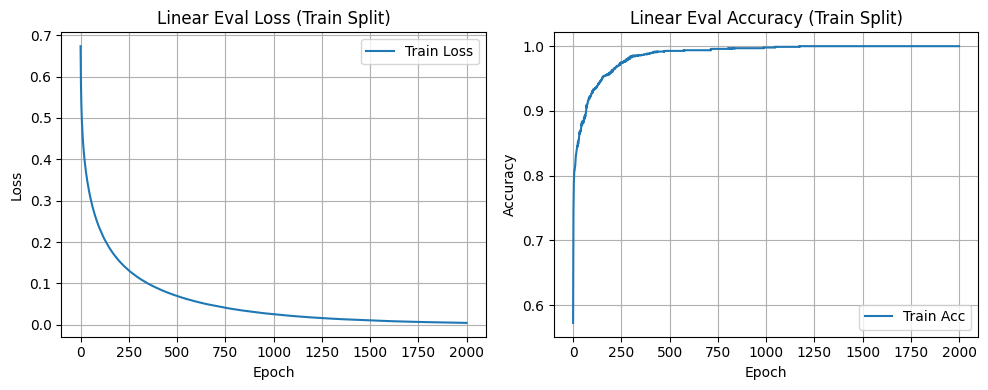

In [15]:
# Cell 15: Linear Eval Curves (Train Split Only)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lin_train_losses, label='Train Loss')
plt.title('Linear Eval Loss (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()

plt.subplot(1,2,2)
plt.plot(lin_train_accs, label='Train Acc')
plt.title('Linear Eval Accuracy (Train Split)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()


In [16]:
# Cell 16: Testing on 70% Test Split

classifier.eval()
test_labels_all, test_probs_all, test_preds_all = [], [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        feats = encoder_linear(imgs)
        logits = classifier(feats)
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(1)

        test_labels_all.append(labels.cpu().numpy())
        test_probs_all.append(probs.cpu().numpy())
        test_preds_all.append(preds.cpu().numpy())

test_labels_all = np.concatenate(test_labels_all)
test_probs_all = np.concatenate(test_probs_all)
test_preds_all  = np.concatenate(test_preds_all)

print("\nTest (70%) Classification Report:")
print(classification_report(test_labels_all, test_preds_all,
                            target_names=[IDX_TO_CLASS[i] for i in range(NUM_CLASSES)]))



Test (70%) Classification Report:
                     precision    recall  f1-score   support

Monkeypox_augmented       0.96      0.92      0.94      1013
   Others_augmented       0.94      0.97      0.95      1222

           accuracy                           0.95      2235
          macro avg       0.95      0.95      0.95      2235
       weighted avg       0.95      0.95      0.95      2235



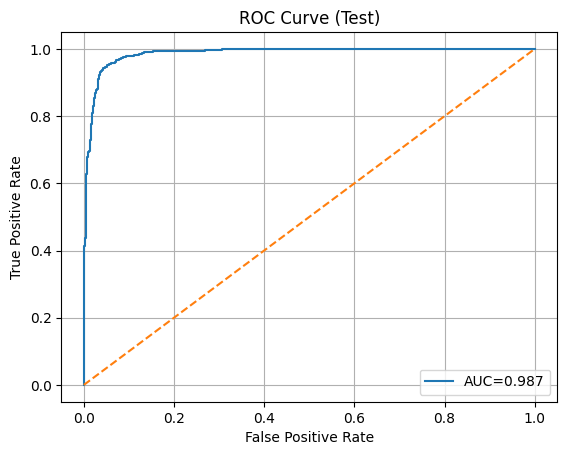

In [17]:
# Cell 17: ROC Curves (Multi-class or Binary)

if NUM_CLASSES == 2:
    from sklearn.metrics import roc_curve, roc_auc_score
    fpr, tpr, _ = roc_curve(test_labels_all, test_probs_all[:,1])
    auc = roc_auc_score(test_labels_all, test_probs_all[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0,1], [0,1], '--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Test)")
    plt.grid(True); plt.legend(); plt.show()
else:
    # One-vs-Rest ROC
    y_bin = label_binarize(test_labels_all, classes=list(range(NUM_CLASSES)))
    aucs = []
    plt.figure()
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_bin[:,i], test_probs_all[:,i])
        auc_i = roc_auc_score(y_bin[:,i], test_probs_all[:,i])
        aucs.append(auc_i)
        plt.plot(fpr, tpr, label=f"{IDX_TO_CLASS[i]} (AUC={auc_i:.3f})")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("Multi-class ROC Curve (OvR) - Test")
    plt.grid(True); plt.legend(); plt.show()
    print("Per-class AUCs:", {IDX_TO_CLASS[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})


Computing t-SNE on TEST features...


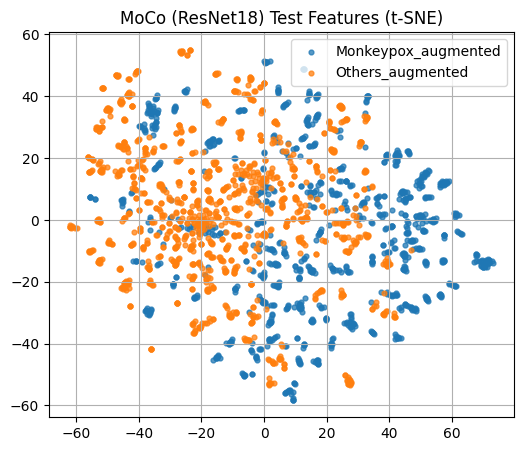

In [18]:
# Cell 18: t-SNE on TEST Features (Separability Check)

print("Computing t-SNE on TEST features...")
# Reuse the same frozen encoder (encoder_linear) for features
test_features, test_labels_for_vis = extract_features(test_loader, encoder_linear)
tsne_test = TSNE(n_components=2, init="pca", learning_rate="auto", perplexity=30, random_state=SEED)
tsne_test_2d = tsne_test.fit_transform(test_features)
plt.figure(figsize=(6,5))
for c in np.unique(test_labels_for_vis):
    idx = test_labels_for_vis == c
    plt.scatter(tsne_test_2d[idx,0], tsne_test_2d[idx,1], s=12, label=IDX_TO_CLASS[c], alpha=0.75)
plt.legend(); plt.title("MoCo (ResNet18) Test Features (t-SNE)"); plt.grid(True); plt.show()
